The Rashomon ratio, as a property of a data set and a hypothesis space, serves as gauge of simplicity of the
learning problem. If the Rashomon set is large, many different reasonable optimization procedures could lead
to a model from the Rashomon set. Therefore, for large Rashomon sets, accurate models tend to be easier
to find (since optimization procedures can find them). In other words, if the Rashomon ratio is large, the
Rashomon set could contain many accurate and simple models, and the learning problem becomes simpler.
On the other hand, smaller Rashomon ratios might imply a harder learning problem, especially in the case
of few deep and narrow local minima.

We expect that in many real-world applications of machine learning, properties similar to the assumptions
behind our theorems hold, i.e., that large enough Rashomon sets intersect simpler hypothesis spaces in ways
that lead to or explain good performance. This conjecture is difficult to verify theoretically because it is not
a mathematical conjecture about the structure of two specific function spaces, but a statement about many
function spaces, and how they interact with commonly occurring data sets. Thus, we consider this question
empirically.

In [1]:
from sklearn import datasets 
import logging
import sys
import os
%cd ..
from bds.meel import approx_mc2, approx_mc2_core
from bds.rule import Rule
from bds.utils import bin_random , bin_array, randints, solutions_to_dict

#from bds.bb import BranchAndBoundNaive, BranchAndBoundV1, BranchAndBoundV0, BranchAndBoundV2
from logzero import logger
import gmpy2 as gmp
from gmpy2 import mpz , mpfr
from bds.sat.min_freq import construct_min_freq_program
from bds.sat.solver import construct_solver
from bds.gf2 import GF
from bds.rule import Rule
from bds.utils import mpz_set_bits
from tests.utils import assert_dict_allclose, assert_close_mpfr

#from bds.bounds_utils import find_equivalence_classes
import numpy as np 

import random
import gmpy2 as gmp
import pandas as pd 
from bds.fpgrowth import preprocess_transaction_list, build_fptree, fpgrowth_on_tree

logger.setLevel(logging.DEBUG)

num_pts = 500

from gmpy2 import mpz, mpfr
import pickle 
import math 

show_progres = True
rand_seed = 1234

/u/50/ciaperm1/unix/sampling-rashomon-decision-set-code


In [2]:

def read_pickle(filepath_y): 
    objects = []
    with (open(filepath_y, "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break

    return objects 

def mpz_set_bits(n: mpz, bits: np.ndarray) -> mpz:
    """return a copy of n and set `bits` to 1 in `n`"""
    for i in bits:
        n = gmp.bit_set(n, int(i))
    return n



def compute_union(vectors):
    result = vectors[0]  # Initialize result with the first vector
    for vector in vectors[1:]:
        result = result | vector   # Perform bitwise OR operation
    return result


def _captured_by_rules(rules): 
    return compute_union([rule.truthtable for rule in rules])

def compute_false_positives(covered, y): 
    return gmp.popcount( covered &  ~y ) 
    
def compute_false_negatives(covered, y): 
    return gmp.popcount( ~covered & y) 
    

def random_sample_rule_sets(rules, y, max_size, n, N_rep = 100000, lmbd = 1, ub = 1): 
    #
    
    y_mpz = mpz_set_bits(mpz(), y.nonzero()[0])
    rashomon_counter = 0
    for _ in range(N_rep): 
        #
        size = random.randint(1, max_size)
        random.shuffle(rules)
        this_sample = rules[:size] 
        #
        # compute loss function for the sample 
        # 
        cov = _captured_by_rules(this_sample) 
        
        fp = compute_false_positives(cov, y_mpz) / n 
        fn = compute_false_negatives(cov, y_mpz) / n 
   
        loss = fp + fn + lmbd * size 
        
        if loss <= ub: 
            rashomon_counter+=1 
            
    return rashomon_counter
    
    

In [3]:
def count_total(max_subset_size, set_size): 
    total_subsets= 0
    for subset_size in range(1, max_subset_size):  # Sizes 1, 2, and 3
        num_subsets = math.comb(set_size, subset_size)
        total_subsets += num_subsets

    return total_subsets

### compas dataset 

In [4]:
# Load the CSV file using Pandas
data = pd.read_csv('data/compas_test-binary.csv')

# Print the data
data.head()

,sex:Male,age:18-20,age:21-22,age:23-25,age:26-45,age:>45,juvenile-felonies:>0,juvenile-misdemeanors:>0,juvenile-crimes:>0,priors:2-3,priors:=0,priors:=1,priors:>3,current-charge-degree:Misdemeanor,recidivate-within-two-years:1
0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,1
2,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1
3,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1
4,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0


In [5]:
# read labels 
f = open("data/compas_test.label", "r")
labels = []
for row in f.readlines(): 
    labels.append(list(map(int, row.split(" ")[1:])))
    
y = np.array(labels[1], dtype = bool) 
X = data.to_numpy()
assert len(y) == X.shape[0]
# now we need to extract rules 
X_bag = [set([j for j, x in enumerate(row) if x]) for row in X]

In [6]:
def compute_truthtable(X,itemset): 
    ''' poorly optimized function '''
    support_list = [] 
    for i in range(X.shape[0]): 
        if sum([X[i][j] for j in itemset]) == len(itemset): 
            support_list.append(i)
                
    truthtable = mpz_set_bits(mpz(), support_list)
    
    return truthtable

In [7]:
min_support = 50 

    
ordered_input_data = preprocess_transaction_list(
    X_bag, min_support
)
tree = build_fptree(ordered_input_data)
frequent_itemsets = set(fpgrowth_on_tree(tree, set(), min_support))


# Now create rules 
rules = [] 
for i,itemset in enumerate(frequent_itemsets):
    tt = compute_truthtable(X,itemset)
    this_Rule = Rule(id = i+1, name = "rule_" + str(i), cardinality=len(itemset), truthtable=tt)
    # we need the truthtable for this itemset 
    rules.append(this_Rule)
    


In [8]:
max_subset_size = 8
lmbd = 0.1 
ub = 0.3 
counts = random_sample_rule_sets(rules, y, max_size=max_subset_size, n = X.shape[0], N_rep = 500000, lmbd = 0.1, ub = 0.3) 
ratio = counts / count_total(max_subset_size, len(rules))
ratio

8.683436241016509e-06

In [10]:
from bds.bb import get_ground_truth_count
from bds.bbSampleTreeApproxCounting import BranchAndBoundNaive
import time 
import random

all_n_rules = [] 
lmbd = 0.1 
ub = 0.5 
rand_seed = 1234
n_reps = 1

delta = .8
eps = .8

show_progres = True

all_averages_times_MC = [] 

all_averages_counts_MC = [] 
all_averages_counts_GT = []


for min_support in [7, 10, 20, 30, 40, 50][::-1]: 
    
    ordered_input_data = preprocess_transaction_list(
        X_bag, min_support
    )
    tree = build_fptree(ordered_input_data)
    frequent_itemsets = set(fpgrowth_on_tree(tree, set(), min_support))
    
    all_n_rules.append(len(frequent_itemsets)) 
    
    # Now create rules 
    rules = [] 
    for i,itemset in enumerate(frequent_itemsets):
        tt = compute_truthtable(X,itemset)
        this_Rule = Rule(id = i+1, name = "rule_" + str(i), cardinality=len(itemset), truthtable=tt)
        # we need the truthtable for this itemset 
        rules.append(this_Rule)
            
    pickle.dump(rules, open("rules/rules_compas_05_" + str(len(rules)), "wb" ))
    
    # approxMC
    all_times_MC = [] 
    all_counts_MC = [] 
    
    all_times_GT = [] 
    all_counts_GT = [] 
    
    t0 = count_total( len(rules), len(rules))
    
    for _ in range(n_reps):
    
        t = time.time() 
        test_cnt = approx_mc2(
                    rules, y, lmbd=lmbd, ub=ub,
                    delta=delta, eps=eps, rand_seed=rand_seed, show_progress=show_progres,
                    parallel=False, log_level=logging.WARN
                ) / t0 
        
        
        elapsed = time.time() - t 
        all_times_MC.append(elapsed) 
        all_counts_MC.append(test_cnt)

        
        # complete enumeration 
        ref_count = get_ground_truth_count(rules, y, lmbd, ub) / t0
        all_times_GT.append(elapsed) 
        all_counts_GT.append(ref_count) 
    
    all_averages_times_MC.append(np.mean(all_times_MC))
    all_averages_times_GT.append(np.mean(all_times_GT))
    
    all_averages_counts_MC.append(np.mean(all_counts_MC))
    all_averages_counts_GT.append(np.mean(all_counts_GT))
    
    pickle.dump(all_averages_counts_MC, open("all_averages_ratios_MC_" + str(len(rules)), "wb" ))
    pickle.dump(all_averages_counts_GT, open("all_averages_ratios_GT_" + str(len(rules)), "wb" ))
    

[D 230815 23:56:15 meel:362] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230815 23:56:15 meel:365] thresh = 72.95
[D 230815 23:56:15 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230815 23:56:15 meel:376] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230815 23:56:15 meel:388] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230815 23:56:15 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:15 meel:280] initial solving under 60 constraints
[D 230815 23:56:15 cbb:160] setting up the parity constraint system
[D 230815 23:56:15 cbb_v2:328] abort the search since the linear system is not solvable
[D 230815 23:56:15 meel:283] solving takes 0.01 secs
[D 230815 23:56:15 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230815 23:56:15 meel:98] calling log_search with thresh=72
[D 230815 23:56:

m (to return): 8
time_cost_info: 
|1|0.029281374998390675|
|2|0.013663200996234082|
|3|0.018608752987347543|
|4|0.05304137300117873|
|8|0.4009755099978065|
|6|0.09220512099273037|
|7|0.39119456699700095|


[D 230815 23:56:17 meel:149] search tree size: 8417
[D 230815 23:56:17 meel:150] number of prefix evaluations: 131949
[D 230815 23:56:17 meel:152] solving takes 0.55 secs
[D 230815 23:56:17 meel:198] |Y| < thresh (49 < 72)
[D 230815 23:56:17 meel:137] ---- solve m = 7----
[D 230815 23:56:17 cbb:160] setting up the parity constraint system
[D 230815 23:56:17 meel:149] search tree size: 9465
[D 230815 23:56:17 meel:150] number of prefix evaluations: 156707
[D 230815 23:56:17 meel:152] solving takes 0.38 secs
[D 230815 23:56:17 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:17 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:17 meel:411] running approx_mc2_core takes 0.97s
[D 230815 23:56:17 meel:414] num_cells: 256, num_sols: 49
  6%|██▊                                         | 2/32 [00:02<00:30,  1.00s/it][D 230815 23:56:17 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:17 meel:280] initial solving under 60 constraints
[D 230815 23:56:17 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.5524986929958686|
|7|0.37827876200026367|


[D 230815 23:56:18 meel:149] search tree size: 8850
[D 230815 23:56:18 meel:150] number of prefix evaluations: 129376
[D 230815 23:56:18 meel:152] solving takes 0.56 secs
[D 230815 23:56:18 meel:198] |Y| < thresh (63 < 72)
[D 230815 23:56:18 meel:137] ---- solve m = 7----
[D 230815 23:56:18 cbb:160] setting up the parity constraint system
[D 230815 23:56:18 meel:149] search tree size: 9245
[D 230815 23:56:18 meel:150] number of prefix evaluations: 152247
[D 230815 23:56:18 meel:152] solving takes 0.25 secs
[D 230815 23:56:18 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:18 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:18 meel:411] running approx_mc2_core takes 0.86s
[D 230815 23:56:18 meel:414] num_cells: 256, num_sols: 63
  9%|████▏                                       | 3/32 [00:02<00:27,  1.07it/s][D 230815 23:56:18 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:18 meel:280] initial solving under 60 constraints
[D 230815 23:56:18 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.5615061760036042|
|7|0.25047050100693014|


[D 230815 23:56:19 meel:149] search tree size: 9030
[D 230815 23:56:19 meel:150] number of prefix evaluations: 132121
[D 230815 23:56:19 meel:152] solving takes 0.78 secs
[D 230815 23:56:19 meel:198] |Y| < thresh (71 < 72)
[D 230815 23:56:19 meel:137] ---- solve m = 7----
[D 230815 23:56:19 cbb:160] setting up the parity constraint system
[D 230815 23:56:19 meel:149] search tree size: 9327
[D 230815 23:56:19 meel:150] number of prefix evaluations: 157375
[D 230815 23:56:19 meel:152] solving takes 0.23 secs
[D 230815 23:56:19 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:19 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:19 meel:411] running approx_mc2_core takes 1.05s
[D 230815 23:56:19 meel:414] num_cells: 256, num_sols: 71
 12%|█████▌                                      | 4/32 [00:03<00:27,  1.01it/s][D 230815 23:56:19 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:19 meel:280] initial solving under 60 constraints
[D 230815 23:56:19 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.7763152569968952|
|7|0.23000636699725874|


[D 230815 23:56:20 meel:149] search tree size: 8379
[D 230815 23:56:20 meel:150] number of prefix evaluations: 131367
[D 230815 23:56:20 meel:152] solving takes 0.68 secs
[D 230815 23:56:20 meel:198] |Y| < thresh (59 < 72)
[D 230815 23:56:20 meel:137] ---- solve m = 7----
[D 230815 23:56:20 cbb:160] setting up the parity constraint system
[D 230815 23:56:20 meel:149] search tree size: 8126
[D 230815 23:56:20 meel:150] number of prefix evaluations: 151850
[D 230815 23:56:20 meel:152] solving takes 0.21 secs
[D 230815 23:56:20 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:20 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:20 meel:411] running approx_mc2_core takes 0.93s
[D 230815 23:56:20 meel:414] num_cells: 256, num_sols: 59
 16%|██████▉                                     | 5/32 [00:04<00:26,  1.04it/s][D 230815 23:56:20 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:20 meel:280] initial solving under 60 constraints
[D 230815 23:56:20 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.6844789440074237|
|7|0.20796493299712893|


[D 230815 23:56:20 meel:149] search tree size: 8363
[D 230815 23:56:20 meel:150] number of prefix evaluations: 121017
[D 230815 23:56:20 meel:152] solving takes 0.53 secs
[D 230815 23:56:20 meel:198] |Y| < thresh (61 < 72)
[D 230815 23:56:20 meel:137] ---- solve m = 7----
[D 230815 23:56:20 cbb:160] setting up the parity constraint system
[D 230815 23:56:21 meel:149] search tree size: 9380
[D 230815 23:56:21 meel:150] number of prefix evaluations: 147170
[D 230815 23:56:21 meel:152] solving takes 0.39 secs
[D 230815 23:56:21 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:21 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:21 meel:411] running approx_mc2_core takes 0.96s
[D 230815 23:56:21 meel:414] num_cells: 256, num_sols: 61
 19%|████████▎                                   | 6/32 [00:05<00:25,  1.04it/s][D 230815 23:56:21 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:21 meel:280] initial solving under 60 constraints
[D 230815 23:56:21 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.5321624760108534|
|7|0.38994236299186014|


[D 230815 23:56:21 meel:149] search tree size: 8196
[D 230815 23:56:21 meel:150] number of prefix evaluations: 125859
[D 230815 23:56:21 meel:152] solving takes 0.52 secs
[D 230815 23:56:21 meel:198] |Y| < thresh (60 < 72)
[D 230815 23:56:21 meel:137] ---- solve m = 7----
[D 230815 23:56:21 cbb:160] setting up the parity constraint system
[D 230815 23:56:21 meel:149] search tree size: 7210
[D 230815 23:56:21 meel:150] number of prefix evaluations: 142764
[D 230815 23:56:21 meel:152] solving takes 0.19 secs
[D 230815 23:56:21 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:21 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:21 meel:411] running approx_mc2_core takes 0.75s
[D 230815 23:56:21 meel:414] num_cells: 256, num_sols: 60
 22%|█████████▋                                  | 7/32 [00:06<00:22,  1.12it/s][D 230815 23:56:21 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:22 meel:280] initial solving under 60 constraints
[D 230815 23:56:22 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.519792987004621|
|7|0.19128304200421553|


[D 230815 23:56:22 meel:149] search tree size: 8960
[D 230815 23:56:22 meel:150] number of prefix evaluations: 122344
[D 230815 23:56:22 meel:152] solving takes 0.67 secs
[D 230815 23:56:22 meel:198] |Y| < thresh (67 < 72)
[D 230815 23:56:22 meel:137] ---- solve m = 7----
[D 230815 23:56:22 cbb:160] setting up the parity constraint system
[D 230815 23:56:22 meel:149] search tree size: 4328
[D 230815 23:56:22 meel:150] number of prefix evaluations: 128289
[D 230815 23:56:22 meel:152] solving takes 0.08 secs
[D 230815 23:56:22 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:22 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:22 meel:411] running approx_mc2_core takes 0.78s
[D 230815 23:56:22 meel:414] num_cells: 256, num_sols: 67
 25%|███████████                                 | 8/32 [00:07<00:20,  1.16it/s][D 230815 23:56:22 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:22 meel:280] initial solving under 60 constraints
[D 230815 23:56:22 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.6697272019955562|
|7|0.08027446300548036|


[D 230815 23:56:23 meel:149] search tree size: 8882
[D 230815 23:56:23 meel:150] number of prefix evaluations: 131944
[D 230815 23:56:23 meel:152] solving takes 0.53 secs
[D 230815 23:56:23 meel:198] |Y| < thresh (58 < 72)
[D 230815 23:56:23 meel:137] ---- solve m = 7----
[D 230815 23:56:23 cbb:160] setting up the parity constraint system
[D 230815 23:56:23 meel:149] search tree size: 8333
[D 230815 23:56:23 meel:150] number of prefix evaluations: 149249
[D 230815 23:56:23 meel:152] solving takes 0.35 secs
[D 230815 23:56:23 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:23 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:23 meel:411] running approx_mc2_core takes 0.92s
[D 230815 23:56:23 meel:414] num_cells: 256, num_sols: 58
 28%|████████████▍                               | 9/32 [00:08<00:20,  1.13it/s][D 230815 23:56:23 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:23 meel:280] initial solving under 60 constraints
[D 230815 23:56:23 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.5337622990045929|
|7|0.34556950100522954|


[D 230815 23:56:24 meel:149] search tree size: 8285
[D 230815 23:56:24 meel:150] number of prefix evaluations: 120940
[D 230815 23:56:24 meel:152] solving takes 0.50 secs
[D 230815 23:56:24 meel:198] |Y| < thresh (53 < 72)
[D 230815 23:56:24 meel:137] ---- solve m = 7----
[D 230815 23:56:24 cbb:160] setting up the parity constraint system
[D 230815 23:56:24 meel:149] search tree size: 9616
[D 230815 23:56:24 meel:150] number of prefix evaluations: 146614
[D 230815 23:56:24 meel:152] solving takes 0.24 secs
[D 230815 23:56:24 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:24 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:24 meel:411] running approx_mc2_core takes 0.78s
[D 230815 23:56:24 meel:414] num_cells: 256, num_sols: 53
 31%|█████████████▍                             | 10/32 [00:09<00:18,  1.17it/s][D 230815 23:56:24 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:24 meel:280] initial solving under 60 constraints
[D 230815 23:56:24 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.49675801799457986|
|7|0.23513315099989995|


[D 230815 23:56:25 meel:149] search tree size: 7862
[D 230815 23:56:25 meel:150] number of prefix evaluations: 120071
[D 230815 23:56:25 meel:152] solving takes 0.63 secs
[D 230815 23:56:25 meel:198] |Y| < thresh (65 < 72)
[D 230815 23:56:25 meel:137] ---- solve m = 7----
[D 230815 23:56:25 cbb:160] setting up the parity constraint system
[D 230815 23:56:25 meel:149] search tree size: 8366
[D 230815 23:56:25 meel:150] number of prefix evaluations: 140773
[D 230815 23:56:25 meel:152] solving takes 0.19 secs
[D 230815 23:56:25 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:25 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:25 meel:411] running approx_mc2_core takes 0.86s
[D 230815 23:56:25 meel:414] num_cells: 256, num_sols: 65
 34%|██████████████▊                            | 11/32 [00:09<00:18,  1.17it/s][D 230815 23:56:25 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:25 meel:280] initial solving under 60 constraints
[D 230815 23:56:25 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.632939670002088|
|7|0.19489151499874424|


[D 230815 23:56:25 meel:149] search tree size: 8341
[D 230815 23:56:25 meel:150] number of prefix evaluations: 123203
[D 230815 23:56:25 meel:152] solving takes 0.51 secs
[D 230815 23:56:25 meel:198] |Y| < thresh (64 < 72)
[D 230815 23:56:25 meel:137] ---- solve m = 7----
[D 230815 23:56:25 cbb:160] setting up the parity constraint system
[D 230815 23:56:26 meel:149] search tree size: 8684
[D 230815 23:56:26 meel:150] number of prefix evaluations: 143816
[D 230815 23:56:26 meel:152] solving takes 0.34 secs
[D 230815 23:56:26 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:26 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:26 meel:411] running approx_mc2_core takes 0.89s
[D 230815 23:56:26 meel:414] num_cells: 256, num_sols: 64
 38%|████████████████▏                          | 12/32 [00:10<00:17,  1.15it/s][D 230815 23:56:26 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:26 meel:280] initial solving under 60 constraints
[D 230815 23:56:26 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.5137768350105034|
|7|0.3434208260005107|


[D 230815 23:56:26 meel:149] search tree size: 7806
[D 230815 23:56:26 meel:150] number of prefix evaluations: 119533
[D 230815 23:56:26 meel:152] solving takes 0.54 secs
[D 230815 23:56:26 meel:198] |Y| < thresh (63 < 72)
[D 230815 23:56:26 meel:137] ---- solve m = 7----
[D 230815 23:56:26 cbb:160] setting up the parity constraint system
[D 230815 23:56:27 meel:149] search tree size: 8769
[D 230815 23:56:27 meel:150] number of prefix evaluations: 145252
[D 230815 23:56:27 meel:152] solving takes 0.36 secs
[D 230815 23:56:27 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:27 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:27 meel:411] running approx_mc2_core takes 0.94s
[D 230815 23:56:27 meel:414] num_cells: 256, num_sols: 63
 41%|█████████████████▍                         | 13/32 [00:11<00:16,  1.12it/s][D 230815 23:56:27 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:27 meel:280] initial solving under 60 constraints
[D 230815 23:56:27 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.5380869219952729|
|7|0.36206067200691905|


[D 230815 23:56:27 meel:149] search tree size: 7237
[D 230815 23:56:27 meel:150] number of prefix evaluations: 118326
[D 230815 23:56:27 meel:152] solving takes 0.46 secs
[D 230815 23:56:27 meel:198] |Y| < thresh (65 < 72)
[D 230815 23:56:27 meel:137] ---- solve m = 7----
[D 230815 23:56:27 cbb:160] setting up the parity constraint system
[D 230815 23:56:27 meel:149] search tree size: 9141
[D 230815 23:56:27 meel:150] number of prefix evaluations: 142887
[D 230815 23:56:27 meel:152] solving takes 0.26 secs
[D 230815 23:56:27 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:27 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:27 meel:411] running approx_mc2_core takes 0.75s
[D 230815 23:56:27 meel:414] num_cells: 256, num_sols: 65
 44%|██████████████████▊                        | 14/32 [00:12<00:15,  1.18it/s][D 230815 23:56:27 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:27 meel:280] initial solving under 60 constraints
[D 230815 23:56:27 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.4569618370005628|
|7|0.2554244749917416|


[D 230815 23:56:28 meel:149] search tree size: 7940
[D 230815 23:56:28 meel:150] number of prefix evaluations: 120290
[D 230815 23:56:28 meel:152] solving takes 0.63 secs
[D 230815 23:56:28 meel:198] |Y| < thresh (65 < 72)
[D 230815 23:56:28 meel:137] ---- solve m = 7----
[D 230815 23:56:28 cbb:160] setting up the parity constraint system
[D 230815 23:56:28 meel:149] search tree size: 8212
[D 230815 23:56:28 meel:150] number of prefix evaluations: 145261
[D 230815 23:56:28 meel:152] solving takes 0.23 secs
[D 230815 23:56:28 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:28 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:28 meel:411] running approx_mc2_core takes 0.90s
[D 230815 23:56:28 meel:414] num_cells: 256, num_sols: 65
 47%|████████████████████▏                      | 15/32 [00:13<00:14,  1.15it/s][D 230815 23:56:28 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:28 meel:280] initial solving under 60 constraints
[D 230815 23:56:28 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.6322371229907731|
|7|0.23166116699576378|


[D 230815 23:56:29 meel:149] search tree size: 9409
[D 230815 23:56:29 meel:150] number of prefix evaluations: 123921
[D 230815 23:56:29 meel:152] solving takes 0.53 secs
[D 230815 23:56:29 meel:198] |Y| < thresh (65 < 72)
[D 230815 23:56:29 meel:137] ---- solve m = 7----
[D 230815 23:56:29 cbb:160] setting up the parity constraint system
[D 230815 23:56:29 meel:149] search tree size: 7274
[D 230815 23:56:29 meel:150] number of prefix evaluations: 139718
[D 230815 23:56:29 meel:152] solving takes 0.31 secs
[D 230815 23:56:29 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:29 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:29 meel:411] running approx_mc2_core takes 0.88s
[D 230815 23:56:29 meel:414] num_cells: 256, num_sols: 65
 50%|█████████████████████▌                     | 16/32 [00:14<00:13,  1.15it/s][D 230815 23:56:29 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:29 meel:280] initial solving under 60 constraints
[D 230815 23:56:29 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.5286551309982315|
|7|0.3149583260092186|


[D 230815 23:56:30 meel:149] search tree size: 7415
[D 230815 23:56:30 meel:150] number of prefix evaluations: 111937
[D 230815 23:56:30 meel:152] solving takes 0.43 secs
[D 230815 23:56:30 meel:198] |Y| < thresh (65 < 72)
[D 230815 23:56:30 meel:137] ---- solve m = 7----
[D 230815 23:56:30 cbb:160] setting up the parity constraint system
[D 230815 23:56:30 meel:149] search tree size: 4370
[D 230815 23:56:30 meel:150] number of prefix evaluations: 118800
[D 230815 23:56:30 meel:152] solving takes 0.09 secs
[D 230815 23:56:30 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:30 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:30 meel:411] running approx_mc2_core takes 0.55s
[D 230815 23:56:30 meel:414] num_cells: 256, num_sols: 65
 53%|██████████████████████▊                    | 17/32 [00:14<00:11,  1.29it/s][D 230815 23:56:30 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:30 meel:280] initial solving under 60 constraints
[D 230815 23:56:30 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.43115408399899025|
|7|0.09291069299797527|


[D 230815 23:56:31 meel:149] search tree size: 9271
[D 230815 23:56:31 meel:150] number of prefix evaluations: 136436
[D 230815 23:56:31 meel:152] solving takes 0.68 secs
[D 230815 23:56:31 meel:198] |Y| < thresh (56 < 72)
[D 230815 23:56:31 meel:137] ---- solve m = 7----
[D 230815 23:56:31 cbb:160] setting up the parity constraint system
[D 230815 23:56:31 meel:149] search tree size: 10160
[D 230815 23:56:31 meel:150] number of prefix evaluations: 165433
[D 230815 23:56:31 meel:152] solving takes 0.26 secs
[D 230815 23:56:31 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:31 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:31 meel:411] running approx_mc2_core takes 0.98s
[D 230815 23:56:31 meel:414] num_cells: 256, num_sols: 56
 56%|████████████████████████▏                  | 18/32 [00:15<00:11,  1.19it/s][D 230815 23:56:31 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:31 meel:280] initial solving under 60 constraints
[D 230815 23:56:31 cbb:160] s

m (to return): 8
time_cost_info: 
|8|0.6776260049955454|
|7|0.2583272720075911|


[D 230815 23:56:31 meel:149] search tree size: 8016
[D 230815 23:56:31 meel:150] number of prefix evaluations: 127930
[D 230815 23:56:31 meel:152] solving takes 0.50 secs
[D 230815 23:56:31 meel:198] |Y| < thresh (64 < 72)
[D 230815 23:56:31 meel:137] ---- solve m = 7----
[D 230815 23:56:31 cbb:160] setting up the parity constraint system
[D 230815 23:56:32 meel:149] search tree size: 9254
[D 230815 23:56:32 meel:150] number of prefix evaluations: 151617
[D 230815 23:56:32 meel:152] solving takes 0.40 secs
[D 230815 23:56:32 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:32 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:32 meel:411] running approx_mc2_core takes 0.94s
[D 230815 23:56:32 meel:414] num_cells: 256, num_sols: 64
 59%|█████████████████████████▌                 | 19/32 [00:16<00:11,  1.15it/s][D 230815 23:56:32 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:32 meel:280] initial solving under 60 constraints
[D 230815 23:56:32 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.4982651549944421|
|7|0.40451774800021667|


[D 230815 23:56:32 meel:149] search tree size: 8654
[D 230815 23:56:32 meel:150] number of prefix evaluations: 132673
[D 230815 23:56:32 meel:152] solving takes 0.53 secs
[D 230815 23:56:32 meel:198] |Y| < thresh (57 < 72)
[D 230815 23:56:32 meel:137] ---- solve m = 7----
[D 230815 23:56:32 cbb:160] setting up the parity constraint system
[D 230815 23:56:33 meel:149] search tree size: 8015
[D 230815 23:56:33 meel:150] number of prefix evaluations: 149565
[D 230815 23:56:33 meel:152] solving takes 0.32 secs
[D 230815 23:56:33 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:33 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:33 meel:411] running approx_mc2_core takes 0.89s
[D 230815 23:56:33 meel:414] num_cells: 256, num_sols: 57
 62%|██████████████████████████▉                | 20/32 [00:17<00:10,  1.14it/s][D 230815 23:56:33 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:33 meel:280] initial solving under 60 constraints
[D 230815 23:56:33 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.5300243879901245|
|7|0.31962495199695695|


[D 230815 23:56:33 meel:149] search tree size: 7477
[D 230815 23:56:33 meel:150] number of prefix evaluations: 111548
[D 230815 23:56:33 meel:152] solving takes 0.44 secs
[D 230815 23:56:33 meel:198] |Y| < thresh (66 < 72)
[D 230815 23:56:33 meel:137] ---- solve m = 7----
[D 230815 23:56:33 cbb:160] setting up the parity constraint system
[D 230815 23:56:33 meel:149] search tree size: 3647
[D 230815 23:56:33 meel:150] number of prefix evaluations: 117958
[D 230815 23:56:33 meel:152] solving takes 0.08 secs
[D 230815 23:56:33 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:33 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:33 meel:411] running approx_mc2_core takes 0.55s
[D 230815 23:56:33 meel:414] num_cells: 256, num_sols: 66
 66%|████████████████████████████▏              | 21/32 [00:18<00:08,  1.28it/s][D 230815 23:56:33 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:33 meel:280] initial solving under 60 constraints
[D 230815 23:56:33 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.4418756659870269|
|7|0.08338415999605786|


[D 230815 23:56:34 meel:149] search tree size: 8371
[D 230815 23:56:34 meel:150] number of prefix evaluations: 123235
[D 230815 23:56:34 meel:152] solving takes 0.49 secs
[D 230815 23:56:34 meel:198] |Y| < thresh (62 < 72)
[D 230815 23:56:34 meel:137] ---- solve m = 7----
[D 230815 23:56:34 cbb:160] setting up the parity constraint system
[D 230815 23:56:34 meel:149] search tree size: 8917
[D 230815 23:56:34 meel:150] number of prefix evaluations: 143497
[D 230815 23:56:34 meel:152] solving takes 0.35 secs
[D 230815 23:56:34 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:34 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:34 meel:411] running approx_mc2_core takes 0.87s
[D 230815 23:56:34 meel:414] num_cells: 256, num_sols: 62
 69%|█████████████████████████████▌             | 22/32 [00:19<00:08,  1.24it/s][D 230815 23:56:34 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:34 meel:280] initial solving under 60 constraints
[D 230815 23:56:34 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.48562163299357053|
|7|0.3538552200043341|


[D 230815 23:56:35 meel:149] search tree size: 8224
[D 230815 23:56:35 meel:150] number of prefix evaluations: 130302
[D 230815 23:56:35 meel:152] solving takes 0.54 secs
[D 230815 23:56:35 meel:198] |Y| < thresh (66 < 72)
[D 230815 23:56:35 meel:137] ---- solve m = 7----
[D 230815 23:56:35 cbb:160] setting up the parity constraint system
[D 230815 23:56:35 meel:149] search tree size: 7878
[D 230815 23:56:35 meel:150] number of prefix evaluations: 149382
[D 230815 23:56:35 meel:152] solving takes 0.32 secs
[D 230815 23:56:35 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:35 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:35 meel:411] running approx_mc2_core takes 0.90s
[D 230815 23:56:35 meel:414] num_cells: 256, num_sols: 66
 72%|██████████████████████████████▉            | 23/32 [00:20<00:07,  1.19it/s][D 230815 23:56:35 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:35 meel:280] initial solving under 60 constraints
[D 230815 23:56:35 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.5436714969982859|
|7|0.323626344994409|


[D 230815 23:56:35 meel:149] search tree size: 8179
[D 230815 23:56:35 meel:150] number of prefix evaluations: 121855
[D 230815 23:56:35 meel:152] solving takes 0.48 secs
[D 230815 23:56:35 meel:198] |Y| < thresh (56 < 72)
[D 230815 23:56:35 meel:137] ---- solve m = 7----
[D 230815 23:56:35 cbb:160] setting up the parity constraint system
[D 230815 23:56:36 meel:149] search tree size: 8498
[D 230815 23:56:36 meel:150] number of prefix evaluations: 153880
[D 230815 23:56:36 meel:152] solving takes 0.24 secs
[D 230815 23:56:36 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:36 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:36 meel:411] running approx_mc2_core takes 0.76s
[D 230815 23:56:36 meel:414] num_cells: 256, num_sols: 56
 75%|████████████████████████████████▎          | 24/32 [00:20<00:06,  1.23it/s][D 230815 23:56:36 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:36 meel:280] initial solving under 60 constraints
[D 230815 23:56:36 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.4774662290001288|
|7|0.24494674999732524|


[D 230815 23:56:36 meel:149] search tree size: 8381
[D 230815 23:56:36 meel:150] number of prefix evaluations: 129566
[D 230815 23:56:36 meel:152] solving takes 0.74 secs
[D 230815 23:56:36 meel:198] |Y| < thresh (55 < 72)
[D 230815 23:56:36 meel:137] ---- solve m = 7----
[D 230815 23:56:36 cbb:160] setting up the parity constraint system
[D 230815 23:56:37 meel:149] search tree size: 9563
[D 230815 23:56:37 meel:150] number of prefix evaluations: 162921
[D 230815 23:56:37 meel:152] solving takes 0.26 secs
[D 230815 23:56:37 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:37 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:37 meel:411] running approx_mc2_core takes 1.04s
[D 230815 23:56:37 meel:414] num_cells: 256, num_sols: 55
 78%|█████████████████████████████████▌         | 25/32 [00:21<00:06,  1.13it/s][D 230815 23:56:37 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:37 meel:280] initial solving under 60 constraints
[D 230815 23:56:37 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.7441335109906504|
|7|0.25911915399774443|


[D 230815 23:56:37 meel:149] search tree size: 8377
[D 230815 23:56:37 meel:150] number of prefix evaluations: 131753
[D 230815 23:56:37 meel:152] solving takes 0.52 secs
[D 230815 23:56:37 meel:198] |Y| < thresh (50 < 72)
[D 230815 23:56:37 meel:137] ---- solve m = 7----
[D 230815 23:56:37 cbb:160] setting up the parity constraint system
[D 230815 23:56:38 meel:149] search tree size: 8984
[D 230815 23:56:38 meel:150] number of prefix evaluations: 157455
[D 230815 23:56:38 meel:152] solving takes 0.38 secs
[D 230815 23:56:38 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:38 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:38 meel:411] running approx_mc2_core takes 0.94s
[D 230815 23:56:38 meel:414] num_cells: 256, num_sols: 50
 81%|██████████████████████████████████▉        | 26/32 [00:22<00:05,  1.11it/s][D 230815 23:56:38 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:38 meel:280] initial solving under 60 constraints
[D 230815 23:56:38 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.5249556210037554|
|7|0.37859492999268696|


[D 230815 23:56:38 meel:149] search tree size: 7724
[D 230815 23:56:38 meel:150] number of prefix evaluations: 118721
[D 230815 23:56:38 meel:152] solving takes 0.46 secs
[D 230815 23:56:38 meel:198] |Y| < thresh (53 < 72)
[D 230815 23:56:38 meel:137] ---- solve m = 7----
[D 230815 23:56:38 cbb:160] setting up the parity constraint system
[D 230815 23:56:39 meel:149] search tree size: 9327
[D 230815 23:56:39 meel:150] number of prefix evaluations: 150861
[D 230815 23:56:39 meel:152] solving takes 0.39 secs
[D 230815 23:56:39 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:39 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:39 meel:411] running approx_mc2_core takes 0.89s
[D 230815 23:56:39 meel:414] num_cells: 256, num_sols: 53
 84%|████████████████████████████████████▎      | 27/32 [00:23<00:04,  1.11it/s][D 230815 23:56:39 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:39 meel:280] initial solving under 60 constraints
[D 230815 23:56:39 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.4639750089991139|
|7|0.39200793000054546|


[D 230815 23:56:39 meel:149] search tree size: 9186
[D 230815 23:56:39 meel:150] number of prefix evaluations: 133526
[D 230815 23:56:39 meel:152] solving takes 0.55 secs
[D 230815 23:56:39 meel:198] |Y| < thresh (62 < 72)
[D 230815 23:56:39 meel:137] ---- solve m = 7----
[D 230815 23:56:39 cbb:160] setting up the parity constraint system
[D 230815 23:56:39 meel:149] search tree size: 9347
[D 230815 23:56:39 meel:150] number of prefix evaluations: 155501
[D 230815 23:56:39 meel:152] solving takes 0.23 secs
[D 230815 23:56:39 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:39 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:39 meel:411] running approx_mc2_core takes 0.82s
[D 230815 23:56:39 meel:414] num_cells: 256, num_sols: 62
 88%|█████████████████████████████████████▋     | 28/32 [00:24<00:03,  1.14it/s][D 230815 23:56:39 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:39 meel:280] initial solving under 60 constraints
[D 230815 23:56:39 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.5547871500020847|
|7|0.22908610200101975|


[D 230815 23:56:40 meel:149] search tree size: 8110
[D 230815 23:56:40 meel:150] number of prefix evaluations: 121944
[D 230815 23:56:40 meel:152] solving takes 0.69 secs
[D 230815 23:56:40 meel:198] |Y| < thresh (64 < 72)
[D 230815 23:56:40 meel:137] ---- solve m = 7----
[D 230815 23:56:40 cbb:160] setting up the parity constraint system
[D 230815 23:56:40 meel:149] search tree size: 3012
[D 230815 23:56:40 meel:150] number of prefix evaluations: 125776
[D 230815 23:56:40 meel:152] solving takes 0.07 secs
[D 230815 23:56:40 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:40 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:40 meel:411] running approx_mc2_core takes 0.79s
[D 230815 23:56:40 meel:414] num_cells: 256, num_sols: 64
 91%|██████████████████████████████████████▉    | 29/32 [00:25<00:02,  1.17it/s][D 230815 23:56:40 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:40 meel:280] initial solving under 60 constraints
[D 230815 23:56:40 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.6869432279927423|
|7|0.07188731299538631|


[D 230815 23:56:41 meel:149] search tree size: 7627
[D 230815 23:56:41 meel:150] number of prefix evaluations: 121095
[D 230815 23:56:41 meel:152] solving takes 0.56 secs
[D 230815 23:56:41 meel:198] |Y| < thresh (62 < 72)
[D 230815 23:56:41 meel:137] ---- solve m = 7----
[D 230815 23:56:41 cbb:160] setting up the parity constraint system
[D 230815 23:56:41 meel:149] search tree size: 8585
[D 230815 23:56:41 meel:150] number of prefix evaluations: 143896
[D 230815 23:56:41 meel:152] solving takes 0.38 secs
[D 230815 23:56:41 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:41 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:41 meel:411] running approx_mc2_core takes 0.97s
[D 230815 23:56:41 meel:414] num_cells: 256, num_sols: 62
 94%|████████████████████████████████████████▎  | 30/32 [00:26<00:01,  1.13it/s][D 230815 23:56:41 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:41 meel:280] initial solving under 60 constraints
[D 230815 23:56:41 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.5583331749949139|
|7|0.37684337599785067|


[D 230815 23:56:42 meel:149] search tree size: 8712
[D 230815 23:56:42 meel:150] number of prefix evaluations: 121085
[D 230815 23:56:42 meel:152] solving takes 0.57 secs
[D 230815 23:56:42 meel:198] |Y| < thresh (64 < 72)
[D 230815 23:56:42 meel:137] ---- solve m = 7----
[D 230815 23:56:42 cbb:160] setting up the parity constraint system
[D 230815 23:56:42 meel:149] search tree size: 9069
[D 230815 23:56:42 meel:150] number of prefix evaluations: 140105
[D 230815 23:56:42 meel:152] solving takes 0.23 secs
[D 230815 23:56:42 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:42 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:42 meel:411] running approx_mc2_core takes 0.84s
[D 230815 23:56:42 meel:414] num_cells: 256, num_sols: 64
 97%|█████████████████████████████████████████▋ | 31/32 [00:27<00:00,  1.14it/s][D 230815 23:56:42 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:42 meel:280] initial solving under 60 constraints
[D 230815 23:56:42 cbb:160] se

m (to return): 8
time_cost_info: 
|8|0.5679506129963556|
|7|0.23429593900800683|


[D 230815 23:56:43 meel:149] search tree size: 9020
[D 230815 23:56:43 meel:150] number of prefix evaluations: 133190
[D 230815 23:56:43 meel:152] solving takes 0.72 secs
[D 230815 23:56:43 meel:198] |Y| < thresh (71 < 72)
[D 230815 23:56:43 meel:137] ---- solve m = 7----
[D 230815 23:56:43 cbb:160] setting up the parity constraint system
[D 230815 23:56:43 meel:149] search tree size: 9251
[D 230815 23:56:43 meel:150] number of prefix evaluations: 155199
[D 230815 23:56:43 meel:152] solving takes 0.28 secs
[D 230815 23:56:43 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:43 meel:174] big_cell[8]=0, return 8
[D 230815 23:56:43 meel:411] running approx_mc2_core takes 1.04s
[D 230815 23:56:43 meel:414] num_cells: 256, num_sols: 71
100%|███████████████████████████████████████████| 32/32 [00:28<00:00,  1.14it/s]
[D 230815 23:56:43 meel:491] final estimate: 16000.0
[D 230815 23:56:43 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


m (to return): 8
time_cost_info: 
|8|0.7188545090029947|
|7|0.2824804659903748|


[D 230815 23:56:45 meel:362] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230815 23:56:45 meel:365] thresh = 72.95
[D 230815 23:56:45 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230815 23:56:45 meel:376] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230815 23:56:45 meel:388] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230815 23:56:45 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:45 meel:280] initial solving under 76 constraints
[D 230815 23:56:45 cbb:160] setting up the parity constraint system
[D 230815 23:56:45 meel:283] solving takes 0.01 secs
[D 230815 23:56:45 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230815 23:56:45 meel:98] calling log_search with thresh=72
[D 230815 23:56:45 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:45 mee

m (to return): 10
time_cost_info: 
|1|0.009881164995022118|
|2|0.016386748000513762|
|3|0.025763666999409907|
|4|0.01719856300042011|
|8|0.1990801990032196|
|16|1.2761159710062202|
|12|2.0421333250124007|
|10|2.1429418189945864|
|9|1.8429530870052986|


[D 230815 23:56:55 meel:149] search tree size: 27916
[D 230815 23:56:55 meel:150] number of prefix evaluations: 510036
[D 230815 23:56:55 meel:152] solving takes 2.19 secs
[D 230815 23:56:55 meel:198] |Y| < thresh (36 < 72)
[D 230815 23:56:55 meel:137] ---- solve m = 9----
[D 230815 23:56:55 cbb:160] setting up the parity constraint system
[D 230815 23:56:57 meel:149] search tree size: 31029
[D 230815 23:56:57 meel:150] number of prefix evaluations: 857633
[D 230815 23:56:57 meel:152] solving takes 1.97 secs
[D 230815 23:56:57 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:56:57 meel:174] big_cell[10]=0, return 10
[D 230815 23:56:57 meel:411] running approx_mc2_core takes 4.22s
[D 230815 23:56:57 meel:414] num_cells: 1024, num_sols: 36
  6%|██▊                                         | 2/32 [00:11<02:48,  5.63s/it][D 230815 23:56:57 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:56:57 meel:280] initial solving under 76 constraints
[D 230815 23:56:57 cbb:16

m (to return): 10
time_cost_info: 
|10|2.190598996996414|
|9|1.9709944959904533|


[D 230815 23:56:59 meel:149] search tree size: 25898
[D 230815 23:56:59 meel:150] number of prefix evaluations: 501921
[D 230815 23:56:59 meel:152] solving takes 2.07 secs
[D 230815 23:56:59 meel:198] |Y| < thresh (35 < 72)
[D 230815 23:56:59 meel:137] ---- solve m = 9----
[D 230815 23:56:59 cbb:160] setting up the parity constraint system
[D 230815 23:57:01 meel:149] search tree size: 28454
[D 230815 23:57:01 meel:150] number of prefix evaluations: 801895
[D 230815 23:57:01 meel:152] solving takes 1.67 secs
[D 230815 23:57:01 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:01 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:01 meel:411] running approx_mc2_core takes 3.82s
[D 230815 23:57:01 meel:414] num_cells: 1024, num_sols: 35
  9%|████▏                                       | 3/32 [00:15<02:19,  4.80s/it][D 230815 23:57:01 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:01 meel:280] initial solving under 76 constraints
[D 230815 23:57:01 cbb:16

m (to return): 10
time_cost_info: 
|10|2.0737766359961824|
|9|1.674888698005816|


[D 230815 23:57:03 meel:149] search tree size: 27470
[D 230815 23:57:03 meel:150] number of prefix evaluations: 511708
[D 230815 23:57:03 meel:152] solving takes 2.13 secs
[D 230815 23:57:03 meel:198] |Y| < thresh (37 < 72)
[D 230815 23:57:03 meel:137] ---- solve m = 9----
[D 230815 23:57:03 cbb:160] setting up the parity constraint system
[D 230815 23:57:04 meel:149] search tree size: 27550
[D 230815 23:57:04 meel:150] number of prefix evaluations: 730965
[D 230815 23:57:04 meel:152] solving takes 1.43 secs
[D 230815 23:57:04 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:04 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:04 meel:411] running approx_mc2_core takes 3.62s
[D 230815 23:57:04 meel:414] num_cells: 1024, num_sols: 37
 12%|█████▌                                      | 4/32 [00:19<02:01,  4.34s/it][D 230815 23:57:04 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:04 meel:280] initial solving under 76 constraints
[D 230815 23:57:04 cbb:16

m (to return): 10
time_cost_info: 
|10|2.1310558680124814|
|9|1.4283309330057818|


[D 230815 23:57:06 meel:149] search tree size: 27234
[D 230815 23:57:06 meel:150] number of prefix evaluations: 488002
[D 230815 23:57:06 meel:152] solving takes 1.99 secs
[D 230815 23:57:06 meel:198] |Y| < thresh (46 < 72)
[D 230815 23:57:06 meel:137] ---- solve m = 9----
[D 230815 23:57:06 cbb:160] setting up the parity constraint system
[D 230815 23:57:08 meel:149] search tree size: 26705
[D 230815 23:57:08 meel:150] number of prefix evaluations: 757729
[D 230815 23:57:08 meel:152] solving takes 1.66 secs
[D 230815 23:57:08 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:08 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:08 meel:411] running approx_mc2_core takes 3.70s
[D 230815 23:57:08 meel:414] num_cells: 1024, num_sols: 46
 16%|██████▉                                     | 5/32 [00:23<01:51,  4.11s/it][D 230815 23:57:08 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:08 meel:280] initial solving under 76 constraints
[D 230815 23:57:08 cbb:16

m (to return): 10
time_cost_info: 
|10|1.9918302959995344|
|9|1.659633502989891|


[D 230815 23:57:11 meel:149] search tree size: 28309
[D 230815 23:57:11 meel:150] number of prefix evaluations: 515372
[D 230815 23:57:11 meel:152] solving takes 2.57 secs
[D 230815 23:57:11 meel:198] |Y| < thresh (56 < 72)
[D 230815 23:57:11 meel:137] ---- solve m = 9----
[D 230815 23:57:11 cbb:160] setting up the parity constraint system
[D 230815 23:57:12 meel:149] search tree size: 29832
[D 230815 23:57:12 meel:150] number of prefix evaluations: 706057
[D 230815 23:57:12 meel:152] solving takes 1.37 secs
[D 230815 23:57:12 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:12 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:12 meel:411] running approx_mc2_core takes 4.00s
[D 230815 23:57:12 meel:414] num_cells: 1024, num_sols: 56
 19%|████████▎                                   | 6/32 [00:27<01:45,  4.07s/it][D 230815 23:57:12 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:12 meel:280] initial solving under 76 constraints
[D 230815 23:57:12 cbb:16

m (to return): 10
time_cost_info: 
|10|2.5683224359963788|
|9|1.3650227309990441|


[D 230815 23:57:14 meel:149] search tree size: 26850
[D 230815 23:57:14 meel:150] number of prefix evaluations: 479874
[D 230815 23:57:14 meel:152] solving takes 2.09 secs
[D 230815 23:57:14 meel:198] |Y| < thresh (44 < 72)
[D 230815 23:57:14 meel:137] ---- solve m = 9----
[D 230815 23:57:14 cbb:160] setting up the parity constraint system
[D 230815 23:57:15 meel:149] search tree size: 26175
[D 230815 23:57:15 meel:150] number of prefix evaluations: 572848
[D 230815 23:57:15 meel:152] solving takes 0.97 secs
[D 230815 23:57:15 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:15 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:15 meel:411] running approx_mc2_core takes 3.12s
[D 230815 23:57:15 meel:414] num_cells: 1024, num_sols: 44
 22%|█████████▋                                  | 7/32 [00:30<01:34,  3.77s/it][D 230815 23:57:15 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:15 meel:280] initial solving under 76 constraints
[D 230815 23:57:15 cbb:16

m (to return): 10
time_cost_info: 
|10|2.088444035005523|
|9|0.9704456750041572|


[D 230815 23:57:18 meel:149] search tree size: 28776
[D 230815 23:57:18 meel:150] number of prefix evaluations: 531172
[D 230815 23:57:18 meel:152] solving takes 2.35 secs
[D 230815 23:57:18 meel:198] |Y| < thresh (43 < 72)
[D 230815 23:57:18 meel:137] ---- solve m = 9----
[D 230815 23:57:18 cbb:160] setting up the parity constraint system
[D 230815 23:57:19 meel:149] search tree size: 30622
[D 230815 23:57:19 meel:150] number of prefix evaluations: 635188
[D 230815 23:57:19 meel:152] solving takes 0.96 secs
[D 230815 23:57:19 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:19 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:19 meel:411] running approx_mc2_core takes 3.38s
[D 230815 23:57:19 meel:414] num_cells: 1024, num_sols: 43
 25%|███████████                                 | 8/32 [00:33<01:27,  3.65s/it][D 230815 23:57:19 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:19 meel:280] initial solving under 76 constraints
[D 230815 23:57:19 cbb:16

m (to return): 10
time_cost_info: 
|10|2.3531522460107226|
|9|0.9606866520043695|


[D 230815 23:57:21 meel:149] search tree size: 28395
[D 230815 23:57:21 meel:150] number of prefix evaluations: 518023
[D 230815 23:57:21 meel:152] solving takes 2.22 secs
[D 230815 23:57:21 meel:198] |Y| < thresh (46 < 72)
[D 230815 23:57:21 meel:137] ---- solve m = 9----
[D 230815 23:57:21 cbb:160] setting up the parity constraint system
[D 230815 23:57:22 meel:149] search tree size: 28175
[D 230815 23:57:22 meel:150] number of prefix evaluations: 674495
[D 230815 23:57:22 meel:152] solving takes 1.12 secs
[D 230815 23:57:22 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:22 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:22 meel:411] running approx_mc2_core takes 3.40s
[D 230815 23:57:22 meel:414] num_cells: 1024, num_sols: 46
 28%|████████████▍                               | 9/32 [00:36<01:22,  3.57s/it][D 230815 23:57:22 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:22 meel:280] initial solving under 76 constraints
[D 230815 23:57:22 cbb:16

m (to return): 10
time_cost_info: 
|10|2.215058190995478|
|9|1.1170116569992388|


[D 230815 23:57:24 meel:149] search tree size: 27648
[D 230815 23:57:24 meel:150] number of prefix evaluations: 528303
[D 230815 23:57:24 meel:152] solving takes 2.09 secs
[D 230815 23:57:24 meel:198] |Y| < thresh (50 < 72)
[D 230815 23:57:24 meel:137] ---- solve m = 9----
[D 230815 23:57:24 cbb:160] setting up the parity constraint system
[D 230815 23:57:25 meel:149] search tree size: 30099
[D 230815 23:57:25 meel:150] number of prefix evaluations: 652515
[D 230815 23:57:25 meel:152] solving takes 1.10 secs
[D 230815 23:57:25 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:25 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:25 meel:411] running approx_mc2_core takes 3.27s
[D 230815 23:57:25 meel:414] num_cells: 1024, num_sols: 50
 31%|█████████████▍                             | 10/32 [00:40<01:16,  3.48s/it][D 230815 23:57:25 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:25 meel:280] initial solving under 76 constraints
[D 230815 23:57:25 cbb:16

m (to return): 10
time_cost_info: 
|10|2.0918789120041765|
|9|1.0960316200071247|


[D 230815 23:57:27 meel:149] search tree size: 23290
[D 230815 23:57:27 meel:150] number of prefix evaluations: 445883
[D 230815 23:57:27 meel:152] solving takes 1.81 secs
[D 230815 23:57:27 meel:198] |Y| < thresh (39 < 72)
[D 230815 23:57:27 meel:137] ---- solve m = 9----
[D 230815 23:57:27 cbb:160] setting up the parity constraint system
[D 230815 23:57:28 meel:149] search tree size: 26882
[D 230815 23:57:28 meel:150] number of prefix evaluations: 619191
[D 230815 23:57:28 meel:152] solving takes 1.22 secs
[D 230815 23:57:28 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:28 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:28 meel:411] running approx_mc2_core takes 3.11s
[D 230815 23:57:28 meel:414] num_cells: 1024, num_sols: 39
 34%|██████████████▊                            | 11/32 [00:43<01:10,  3.37s/it][D 230815 23:57:28 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:28 meel:280] initial solving under 76 constraints
[D 230815 23:57:28 cbb:16

m (to return): 10
time_cost_info: 
|10|1.8071240349963773|
|9|1.2243887780059595|


[D 230815 23:57:31 meel:149] search tree size: 25445
[D 230815 23:57:31 meel:150] number of prefix evaluations: 451932
[D 230815 23:57:31 meel:152] solving takes 2.13 secs
[D 230815 23:57:31 meel:198] |Y| < thresh (37 < 72)
[D 230815 23:57:31 meel:137] ---- solve m = 9----
[D 230815 23:57:31 cbb:160] setting up the parity constraint system
[D 230815 23:57:32 meel:149] search tree size: 26555
[D 230815 23:57:32 meel:150] number of prefix evaluations: 758240
[D 230815 23:57:32 meel:152] solving takes 1.55 secs
[D 230815 23:57:32 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:32 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:32 meel:411] running approx_mc2_core takes 3.74s
[D 230815 23:57:32 meel:414] num_cells: 1024, num_sols: 37
 38%|████████████████▏                          | 12/32 [00:47<01:09,  3.48s/it][D 230815 23:57:32 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:32 meel:280] initial solving under 76 constraints
[D 230815 23:57:32 cbb:16

m (to return): 10
time_cost_info: 
|10|2.127382757011219|
|9|1.554440349995275|


[D 230815 23:57:34 meel:149] search tree size: 23548
[D 230815 23:57:34 meel:150] number of prefix evaluations: 446757
[D 230815 23:57:34 meel:152] solving takes 1.80 secs
[D 230815 23:57:34 meel:198] |Y| < thresh (43 < 72)
[D 230815 23:57:34 meel:137] ---- solve m = 9----
[D 230815 23:57:34 cbb:160] setting up the parity constraint system
[D 230815 23:57:35 meel:149] search tree size: 25500
[D 230815 23:57:35 meel:150] number of prefix evaluations: 668967
[D 230815 23:57:35 meel:152] solving takes 1.24 secs
[D 230815 23:57:35 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:35 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:35 meel:411] running approx_mc2_core takes 3.10s
[D 230815 23:57:35 meel:414] num_cells: 1024, num_sols: 43
 41%|█████████████████▍                         | 13/32 [00:50<01:04,  3.37s/it][D 230815 23:57:35 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:35 meel:280] initial solving under 76 constraints
[D 230815 23:57:35 cbb:16

m (to return): 10
time_cost_info: 
|10|1.8040355190023547|
|9|1.2438004510040628|


[D 230815 23:57:37 meel:149] search tree size: 28237
[D 230815 23:57:37 meel:150] number of prefix evaluations: 515613
[D 230815 23:57:37 meel:152] solving takes 2.05 secs
[D 230815 23:57:37 meel:198] |Y| < thresh (41 < 72)
[D 230815 23:57:37 meel:137] ---- solve m = 9----
[D 230815 23:57:37 cbb:160] setting up the parity constraint system
[D 230815 23:57:39 meel:149] search tree size: 29311
[D 230815 23:57:39 meel:150] number of prefix evaluations: 730166
[D 230815 23:57:39 meel:152] solving takes 1.31 secs
[D 230815 23:57:39 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:39 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:39 meel:411] running approx_mc2_core takes 3.43s
[D 230815 23:57:39 meel:414] num_cells: 1024, num_sols: 41
 44%|██████████████████▊                        | 14/32 [00:53<01:01,  3.39s/it][D 230815 23:57:39 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:39 meel:280] initial solving under 76 constraints
[D 230815 23:57:39 cbb:16

m (to return): 10
time_cost_info: 
|10|2.0518791310023516|
|9|1.307594843005063|


[D 230815 23:57:41 meel:149] search tree size: 26600
[D 230815 23:57:41 meel:150] number of prefix evaluations: 505385
[D 230815 23:57:41 meel:152] solving takes 1.96 secs
[D 230815 23:57:41 meel:198] |Y| < thresh (49 < 72)
[D 230815 23:57:41 meel:137] ---- solve m = 9----
[D 230815 23:57:41 cbb:160] setting up the parity constraint system
[D 230815 23:57:41 meel:149] search tree size: 28130
[D 230815 23:57:41 meel:150] number of prefix evaluations: 569718
[D 230815 23:57:41 meel:152] solving takes 0.76 secs
[D 230815 23:57:41 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:41 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:42 meel:411] running approx_mc2_core takes 2.79s
[D 230815 23:57:42 meel:414] num_cells: 1024, num_sols: 49
 47%|████████████████████▏                      | 15/32 [00:56<00:54,  3.21s/it][D 230815 23:57:42 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:42 meel:280] initial solving under 76 constraints
[D 230815 23:57:42 cbb:16

m (to return): 10
time_cost_info: 
|10|1.964848489005817|
|9|0.7588889359903987|


[D 230815 23:57:43 meel:149] search tree size: 25105
[D 230815 23:57:43 meel:150] number of prefix evaluations: 497690
[D 230815 23:57:43 meel:152] solving takes 1.90 secs
[D 230815 23:57:43 meel:198] |Y| < thresh (50 < 72)
[D 230815 23:57:43 meel:137] ---- solve m = 9----
[D 230815 23:57:43 cbb:160] setting up the parity constraint system
[D 230815 23:57:45 meel:149] search tree size: 29112
[D 230815 23:57:45 meel:150] number of prefix evaluations: 650934
[D 230815 23:57:45 meel:152] solving takes 1.07 secs
[D 230815 23:57:45 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:45 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:45 meel:411] running approx_mc2_core takes 3.04s
[D 230815 23:57:45 meel:414] num_cells: 1024, num_sols: 50
 50%|█████████████████████▌                     | 16/32 [00:59<00:50,  3.16s/it][D 230815 23:57:45 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:45 meel:280] initial solving under 76 constraints
[D 230815 23:57:45 cbb:16

m (to return): 10
time_cost_info: 
|10|1.9000080059922766|
|9|1.0702199630031828|


[D 230815 23:57:47 meel:149] search tree size: 27220
[D 230815 23:57:47 meel:150] number of prefix evaluations: 509082
[D 230815 23:57:47 meel:152] solving takes 1.97 secs
[D 230815 23:57:47 meel:198] |Y| < thresh (42 < 72)
[D 230815 23:57:47 meel:137] ---- solve m = 9----
[D 230815 23:57:47 cbb:160] setting up the parity constraint system
[D 230815 23:57:48 meel:149] search tree size: 29251
[D 230815 23:57:48 meel:150] number of prefix evaluations: 700161
[D 230815 23:57:48 meel:152] solving takes 1.34 secs
[D 230815 23:57:48 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:48 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:48 meel:411] running approx_mc2_core takes 3.38s
[D 230815 23:57:48 meel:414] num_cells: 1024, num_sols: 42
 53%|██████████████████████▊                    | 17/32 [01:02<00:48,  3.23s/it][D 230815 23:57:48 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:48 meel:280] initial solving under 76 constraints
[D 230815 23:57:48 cbb:16

m (to return): 10
time_cost_info: 
|10|1.9654960030020447|
|9|1.3400725540122949|


[D 230815 23:57:50 meel:149] search tree size: 28126
[D 230815 23:57:50 meel:150] number of prefix evaluations: 515377
[D 230815 23:57:50 meel:152] solving takes 2.06 secs
[D 230815 23:57:50 meel:198] |Y| < thresh (41 < 72)
[D 230815 23:57:50 meel:137] ---- solve m = 9----
[D 230815 23:57:50 cbb:160] setting up the parity constraint system
[D 230815 23:57:51 meel:149] search tree size: 29349
[D 230815 23:57:51 meel:150] number of prefix evaluations: 645356
[D 230815 23:57:51 meel:152] solving takes 1.00 secs
[D 230815 23:57:51 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:51 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:51 meel:411] running approx_mc2_core takes 3.14s
[D 230815 23:57:51 meel:414] num_cells: 1024, num_sols: 41
 56%|████████████████████████▏                  | 18/32 [01:06<00:44,  3.20s/it][D 230815 23:57:51 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:51 meel:280] initial solving under 76 constraints
[D 230815 23:57:51 cbb:16

m (to return): 10
time_cost_info: 
|10|2.064100513001904|
|9|1.000530859004357|


[D 230815 23:57:53 meel:149] search tree size: 26758
[D 230815 23:57:53 meel:150] number of prefix evaluations: 479799
[D 230815 23:57:53 meel:152] solving takes 1.94 secs
[D 230815 23:57:53 meel:198] |Y| < thresh (43 < 72)
[D 230815 23:57:53 meel:137] ---- solve m = 9----
[D 230815 23:57:53 cbb:160] setting up the parity constraint system
[D 230815 23:57:54 meel:149] search tree size: 26263
[D 230815 23:57:54 meel:150] number of prefix evaluations: 673625
[D 230815 23:57:54 meel:152] solving takes 1.19 secs
[D 230815 23:57:54 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:54 meel:174] big_cell[10]=0, return 10
[D 230815 23:57:54 meel:411] running approx_mc2_core takes 3.19s
[D 230815 23:57:54 meel:414] num_cells: 1024, num_sols: 43
 59%|█████████████████████████▌                 | 19/32 [01:09<00:41,  3.20s/it][D 230815 23:57:54 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:57:54 meel:280] initial solving under 76 constraints
[D 230815 23:57:54 cbb:16

m (to return): 10
time_cost_info: 
|10|1.9365580340090673|
|9|1.1854745570017258|


[D 230815 23:57:56 meel:149] search tree size: 28223
[D 230815 23:57:56 meel:150] number of prefix evaluations: 512856
[D 230815 23:57:56 meel:152] solving takes 2.06 secs
[D 230815 23:57:56 meel:198] |Y| < thresh (34 < 72)
[D 230815 23:57:56 meel:137] ---- solve m = 9----
[D 230815 23:57:56 cbb:160] setting up the parity constraint system
[D 230815 23:57:58 meel:149] search tree size: 29630
[D 230815 23:57:58 meel:150] number of prefix evaluations: 1055583
[D 230815 23:57:58 meel:152] solving takes 2.09 secs
[D 230815 23:57:58 meel:198] |Y| < thresh (67 < 72)
[D 230815 23:57:58 meel:137] ---- solve m = 8----
[D 230815 23:57:58 cbb:160] setting up the parity constraint system
[D 230815 23:57:59 meel:149] search tree size: 16497
[D 230815 23:57:59 meel:150] number of prefix evaluations: 1079587
[D 230815 23:57:59 meel:152] solving takes 0.48 secs
[D 230815 23:57:59 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:57:59 meel:174] big_cell[9]=0, return 9
[D 230815 23:57:59 meel:411] runnin

m (to return): 9
time_cost_info: 
|10|2.0603391629992984|
|9|2.089004320994718|
|8|0.47503872799279634|


[D 230815 23:58:00 meel:149] search tree size: 26768
[D 230815 23:58:00 meel:150] number of prefix evaluations: 123646
[D 230815 23:58:00 meel:152] solving takes 0.94 secs
[D 230815 23:58:00 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:58:00 meel:137] ---- solve m = 10----
[D 230815 23:58:00 cbb:160] setting up the parity constraint system
[D 230815 23:58:02 meel:149] search tree size: 26210
[D 230815 23:58:02 meel:150] number of prefix evaluations: 602187
[D 230815 23:58:02 meel:152] solving takes 1.95 secs
[D 230815 23:58:02 meel:198] |Y| < thresh (50 < 72)
[D 230815 23:58:02 meel:204] big_cell[9]=1, return 10
[D 230815 23:58:02 meel:411] running approx_mc2_core takes 2.92s
[D 230815 23:58:02 meel:414] num_cells: 1024, num_sols: 50
 66%|████████████████████████████▏              | 21/32 [01:16<00:37,  3.43s/it][D 230815 23:58:02 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:58:02 meel:280] initial solving under 76 constraints
[D 230815 23:58:02 cbb:16

time_cost_info: 
|9|0.9391897290042834|
|10|1.9468720549921272|


[D 230815 23:58:04 meel:149] search tree size: 24257
[D 230815 23:58:04 meel:150] number of prefix evaluations: 470580
[D 230815 23:58:04 meel:152] solving takes 1.86 secs
[D 230815 23:58:04 meel:198] |Y| < thresh (49 < 72)
[D 230815 23:58:04 meel:137] ---- solve m = 9----
[D 230815 23:58:04 cbb:160] setting up the parity constraint system
[D 230815 23:58:05 meel:149] search tree size: 27067
[D 230815 23:58:05 meel:150] number of prefix evaluations: 603026
[D 230815 23:58:05 meel:152] solving takes 1.02 secs
[D 230815 23:58:05 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:58:05 meel:174] big_cell[10]=0, return 10
[D 230815 23:58:05 meel:411] running approx_mc2_core takes 2.95s
[D 230815 23:58:05 meel:414] num_cells: 1024, num_sols: 49
 69%|█████████████████████████████▌             | 22/32 [01:19<00:32,  3.29s/it][D 230815 23:58:05 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:58:05 meel:280] initial solving under 76 constraints
[D 230815 23:58:05 cbb:16

m (to return): 10
time_cost_info: 
|10|1.8637380419968395|
|9|1.01986607699655|


[D 230815 23:58:07 meel:149] search tree size: 28678
[D 230815 23:58:07 meel:150] number of prefix evaluations: 516185
[D 230815 23:58:07 meel:152] solving takes 2.07 secs
[D 230815 23:58:07 meel:198] |Y| < thresh (37 < 72)
[D 230815 23:58:07 meel:137] ---- solve m = 9----
[D 230815 23:58:07 cbb:160] setting up the parity constraint system
[D 230815 23:58:08 meel:149] search tree size: 26807
[D 230815 23:58:08 meel:150] number of prefix evaluations: 722478
[D 230815 23:58:08 meel:152] solving takes 1.25 secs
[D 230815 23:58:08 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:58:08 meel:174] big_cell[10]=0, return 10
[D 230815 23:58:08 meel:411] running approx_mc2_core takes 3.40s
[D 230815 23:58:08 meel:414] num_cells: 1024, num_sols: 37
 72%|██████████████████████████████▉            | 23/32 [01:23<00:29,  3.32s/it][D 230815 23:58:08 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:58:08 meel:280] initial solving under 76 constraints
[D 230815 23:58:08 cbb:16

m (to return): 10
time_cost_info: 
|10|2.0711191240116023|
|9|1.248629758003517|


[D 230815 23:58:10 meel:149] search tree size: 27089
[D 230815 23:58:10 meel:150] number of prefix evaluations: 480199
[D 230815 23:58:10 meel:152] solving takes 1.98 secs
[D 230815 23:58:10 meel:198] |Y| < thresh (43 < 72)
[D 230815 23:58:10 meel:137] ---- solve m = 9----
[D 230815 23:58:10 cbb:160] setting up the parity constraint system
[D 230815 23:58:12 meel:149] search tree size: 30167
[D 230815 23:58:12 meel:150] number of prefix evaluations: 694732
[D 230815 23:58:12 meel:152] solving takes 1.31 secs
[D 230815 23:58:12 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:58:12 meel:174] big_cell[10]=0, return 10
[D 230815 23:58:12 meel:411] running approx_mc2_core takes 3.37s
[D 230815 23:58:12 meel:414] num_cells: 1024, num_sols: 43
 75%|████████████████████████████████▎          | 24/32 [01:26<00:26,  3.34s/it][D 230815 23:58:12 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:58:12 meel:280] initial solving under 76 constraints
[D 230815 23:58:12 cbb:16

m (to return): 10
time_cost_info: 
|10|1.978888597994228|
|9|1.31173524800397|


[D 230815 23:58:14 meel:149] search tree size: 26047
[D 230815 23:58:14 meel:150] number of prefix evaluations: 506665
[D 230815 23:58:14 meel:152] solving takes 1.94 secs
[D 230815 23:58:14 meel:198] |Y| < thresh (42 < 72)
[D 230815 23:58:14 meel:137] ---- solve m = 9----
[D 230815 23:58:14 cbb:160] setting up the parity constraint system
[D 230815 23:58:15 meel:149] search tree size: 29850
[D 230815 23:58:15 meel:150] number of prefix evaluations: 815574
[D 230815 23:58:15 meel:152] solving takes 1.60 secs
[D 230815 23:58:15 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:58:15 meel:174] big_cell[10]=0, return 10
[D 230815 23:58:15 meel:411] running approx_mc2_core takes 3.61s
[D 230815 23:58:15 meel:414] num_cells: 1024, num_sols: 42
 78%|█████████████████████████████████▌         | 25/32 [01:30<00:23,  3.42s/it][D 230815 23:58:15 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:58:15 meel:280] initial solving under 76 constraints
[D 230815 23:58:15 cbb:16

m (to return): 10
time_cost_info: 
|10|1.9444017930072732|
|9|1.6004287429968826|


[D 230815 23:58:17 meel:149] search tree size: 27439
[D 230815 23:58:17 meel:150] number of prefix evaluations: 495021
[D 230815 23:58:17 meel:152] solving takes 2.01 secs
[D 230815 23:58:17 meel:198] |Y| < thresh (46 < 72)
[D 230815 23:58:17 meel:137] ---- solve m = 9----
[D 230815 23:58:17 cbb:160] setting up the parity constraint system
[D 230815 23:58:18 meel:149] search tree size: 28640
[D 230815 23:58:18 meel:150] number of prefix evaluations: 583419
[D 230815 23:58:18 meel:152] solving takes 0.87 secs
[D 230815 23:58:18 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:58:18 meel:174] big_cell[10]=0, return 10
[D 230815 23:58:18 meel:411] running approx_mc2_core takes 2.96s
[D 230815 23:58:18 meel:414] num_cells: 1024, num_sols: 46
 81%|██████████████████████████████████▉        | 26/32 [01:33<00:19,  3.28s/it][D 230815 23:58:18 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:58:18 meel:280] initial solving under 76 constraints
[D 230815 23:58:18 cbb:16

m (to return): 10
time_cost_info: 
|10|2.007806651003193|
|9|0.8732822610036237|


[D 230815 23:58:20 meel:149] search tree size: 28598
[D 230815 23:58:20 meel:150] number of prefix evaluations: 518241
[D 230815 23:58:20 meel:152] solving takes 2.14 secs
[D 230815 23:58:20 meel:198] |Y| < thresh (46 < 72)
[D 230815 23:58:20 meel:137] ---- solve m = 9----
[D 230815 23:58:20 cbb:160] setting up the parity constraint system
[D 230815 23:58:21 meel:149] search tree size: 28403
[D 230815 23:58:21 meel:150] number of prefix evaluations: 623614
[D 230815 23:58:21 meel:152] solving takes 0.92 secs
[D 230815 23:58:21 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:58:21 meel:174] big_cell[10]=0, return 10
[D 230815 23:58:21 meel:411] running approx_mc2_core takes 3.13s
[D 230815 23:58:21 meel:414] num_cells: 1024, num_sols: 46
 84%|████████████████████████████████████▎      | 27/32 [01:36<00:16,  3.24s/it][D 230815 23:58:21 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:58:21 meel:280] initial solving under 76 constraints
[D 230815 23:58:21 cbb:16

m (to return): 10
time_cost_info: 
|10|2.1366736790077994|
|9|0.9191249220020836|


[D 230815 23:58:23 meel:149] search tree size: 28918
[D 230815 23:58:23 meel:150] number of prefix evaluations: 513806
[D 230815 23:58:23 meel:152] solving takes 2.03 secs
[D 230815 23:58:23 meel:198] |Y| < thresh (46 < 72)
[D 230815 23:58:23 meel:137] ---- solve m = 9----
[D 230815 23:58:23 cbb:160] setting up the parity constraint system
[D 230815 23:58:25 meel:149] search tree size: 28212
[D 230815 23:58:25 meel:150] number of prefix evaluations: 695483
[D 230815 23:58:25 meel:152] solving takes 1.18 secs
[D 230815 23:58:25 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:58:25 meel:174] big_cell[10]=0, return 10
[D 230815 23:58:25 meel:411] running approx_mc2_core takes 3.28s
[D 230815 23:58:25 meel:414] num_cells: 1024, num_sols: 46
 88%|█████████████████████████████████████▋     | 28/32 [01:39<00:13,  3.25s/it][D 230815 23:58:25 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:58:25 meel:280] initial solving under 76 constraints
[D 230815 23:58:25 cbb:16

m (to return): 10
time_cost_info: 
|10|2.032754848987679|
|9|1.1773086710018106|


[D 230815 23:58:27 meel:149] search tree size: 23873
[D 230815 23:58:27 meel:150] number of prefix evaluations: 467952
[D 230815 23:58:27 meel:152] solving takes 1.84 secs
[D 230815 23:58:27 meel:198] |Y| < thresh (43 < 72)
[D 230815 23:58:27 meel:137] ---- solve m = 9----
[D 230815 23:58:27 cbb:160] setting up the parity constraint system
[D 230815 23:58:28 meel:149] search tree size: 26599
[D 230815 23:58:28 meel:150] number of prefix evaluations: 640502
[D 230815 23:58:28 meel:152] solving takes 1.15 secs
[D 230815 23:58:28 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:58:28 meel:174] big_cell[10]=0, return 10
[D 230815 23:58:28 meel:411] running approx_mc2_core takes 3.06s
[D 230815 23:58:28 meel:414] num_cells: 1024, num_sols: 43
 91%|██████████████████████████████████████▉    | 29/32 [01:42<00:09,  3.20s/it][D 230815 23:58:28 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:58:28 meel:280] initial solving under 76 constraints
[D 230815 23:58:28 cbb:16

m (to return): 10
time_cost_info: 
|10|1.837112965004053|
|9|1.1497000620001927|


[D 230815 23:58:30 meel:149] search tree size: 26586
[D 230815 23:58:30 meel:150] number of prefix evaluations: 479539
[D 230815 23:58:30 meel:152] solving takes 1.97 secs
[D 230815 23:58:30 meel:198] |Y| < thresh (46 < 72)
[D 230815 23:58:30 meel:137] ---- solve m = 9----
[D 230815 23:58:30 cbb:160] setting up the parity constraint system
[D 230815 23:58:31 meel:149] search tree size: 24181
[D 230815 23:58:31 meel:150] number of prefix evaluations: 624499
[D 230815 23:58:31 meel:152] solving takes 1.00 secs
[D 230815 23:58:31 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:58:31 meel:174] big_cell[10]=0, return 10
[D 230815 23:58:31 meel:411] running approx_mc2_core takes 3.04s
[D 230815 23:58:31 meel:414] num_cells: 1024, num_sols: 46
 94%|████████████████████████████████████████▎  | 30/32 [01:45<00:06,  3.15s/it][D 230815 23:58:31 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:58:31 meel:280] initial solving under 76 constraints
[D 230815 23:58:31 cbb:16

m (to return): 10
time_cost_info: 
|10|1.971416207990842|
|9|1.0005817509954795|


[D 230815 23:58:33 meel:149] search tree size: 26979
[D 230815 23:58:33 meel:150] number of prefix evaluations: 508484
[D 230815 23:58:33 meel:152] solving takes 1.98 secs
[D 230815 23:58:33 meel:198] |Y| < thresh (48 < 72)
[D 230815 23:58:33 meel:137] ---- solve m = 9----
[D 230815 23:58:33 cbb:160] setting up the parity constraint system
[D 230815 23:58:34 meel:149] search tree size: 27284
[D 230815 23:58:34 meel:150] number of prefix evaluations: 660454
[D 230815 23:58:34 meel:152] solving takes 1.08 secs
[D 230815 23:58:34 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:58:34 meel:174] big_cell[10]=0, return 10
[D 230815 23:58:34 meel:411] running approx_mc2_core takes 3.12s
[D 230815 23:58:34 meel:414] num_cells: 1024, num_sols: 48
 97%|█████████████████████████████████████████▋ | 31/32 [01:48<00:03,  3.14s/it][D 230815 23:58:34 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:58:34 meel:280] initial solving under 76 constraints
[D 230815 23:58:34 cbb:16

m (to return): 10
time_cost_info: 
|10|1.9752040960011072|
|9|1.0754838930006372|


[D 230815 23:58:36 meel:149] search tree size: 25940
[D 230815 23:58:36 meel:150] number of prefix evaluations: 489445
[D 230815 23:58:36 meel:152] solving takes 2.05 secs
[D 230815 23:58:36 meel:198] |Y| < thresh (71 < 72)
[D 230815 23:58:36 meel:137] ---- solve m = 9----
[D 230815 23:58:36 cbb:160] setting up the parity constraint system
[D 230815 23:58:36 meel:149] search tree size: 13091
[D 230815 23:58:36 meel:150] number of prefix evaluations: 506782
[D 230815 23:58:36 meel:152] solving takes 0.22 secs
[D 230815 23:58:36 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:58:36 meel:174] big_cell[10]=0, return 10
[D 230815 23:58:36 meel:411] running approx_mc2_core takes 2.33s
[D 230815 23:58:36 meel:414] num_cells: 1024, num_sols: 71
100%|███████████████████████████████████████████| 32/32 [01:51<00:00,  3.47s/it]
[D 230815 23:58:36 meel:491] final estimate: 44032.0
[D 230815 23:58:36 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


m (to return): 10
time_cost_info: 
|10|2.052285797006334|
|9|0.21826016700651962|


[D 230815 23:58:41 meel:362] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230815 23:58:41 meel:365] thresh = 72.95
[D 230815 23:58:41 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230815 23:58:41 meel:376] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230815 23:58:41 meel:388] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230815 23:58:41 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:58:41 meel:280] initial solving under 103 constraints
[D 230815 23:58:41 cbb:160] setting up the parity constraint system
[D 230815 23:58:41 cbb_v2:328] abort the search since the linear system is not solvable
[D 230815 23:58:41 meel:283] solving takes 0.02 secs
[D 230815 23:58:41 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230815 23:58:41 meel:98] calling log_search with thresh=72
[D 230815 23:58

time_cost_info: 
|1|0.012042927002767101|
|2|0.018494866992114112|
|3|0.037855475005926564|
|4|0.055305948000750504|
|8|0.18314734399609733|
|16|7.92197342099098|
|12|9.127655058007804|
|10|2.7741947710019303|
|11|9.375282242006506|


[D 230815 23:59:16 meel:149] search tree size: 105649
[D 230815 23:59:16 meel:150] number of prefix evaluations: 977273
[D 230815 23:59:16 meel:152] solving takes 5.45 secs
[D 230815 23:59:16 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:59:17 meel:137] ---- solve m = 12----
[D 230815 23:59:17 cbb:160] setting up the parity constraint system
[D 230815 23:59:25 meel:149] search tree size: 102922
[D 230815 23:59:25 meel:150] number of prefix evaluations: 3396389
[D 230815 23:59:25 meel:152] solving takes 8.89 secs
[D 230815 23:59:25 meel:198] |Y| < thresh (32 < 72)
[D 230815 23:59:25 meel:204] big_cell[11]=1, return 12
[D 230815 23:59:25 meel:411] running approx_mc2_core takes 14.40s
[D 230815 23:59:25 meel:414] num_cells: 4096, num_sols: 32
  6%|██▊                                         | 2/32 [00:43<10:19, 20.65s/it][D 230815 23:59:25 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:59:25 meel:280] initial solving under 103 constraints
[D 230815 23:59:25 

time_cost_info: 
|11|5.450987576987245|
|12|8.893762409992632|


[D 230815 23:59:34 meel:149] search tree size: 100279
[D 230815 23:59:34 meel:150] number of prefix evaluations: 2399429
[D 230815 23:59:34 meel:152] solving takes 8.60 secs
[D 230815 23:59:34 meel:198] |Y| < thresh (33 < 72)
[D 230815 23:59:34 meel:137] ---- solve m = 11----
[D 230815 23:59:34 cbb:160] setting up the parity constraint system
[D 230815 23:59:43 meel:149] search tree size: 102278
[D 230815 23:59:43 meel:150] number of prefix evaluations: 4881646
[D 230815 23:59:43 meel:152] solving takes 9.10 secs
[D 230815 23:59:43 meel:198] |Y| < thresh (61 < 72)
[D 230815 23:59:43 meel:137] ---- solve m = 10----
[D 230815 23:59:43 cbb:160] setting up the parity constraint system
[D 230815 23:59:46 meel:149] search tree size: 109280
[D 230815 23:59:46 meel:150] number of prefix evaluations: 5149944
[D 230815 23:59:46 meel:152] solving takes 3.05 secs
[D 230815 23:59:46 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:59:46 meel:174] big_cell[11]=0, return 11
[D 230815 23:59:46 meel:411

m (to return): 11
time_cost_info: 
|12|8.59882807500253|
|11|9.104674179994618|
|10|3.0526855700009037|


[D 230815 23:59:55 meel:149] search tree size: 102716
[D 230815 23:59:55 meel:150] number of prefix evaluations: 2486114
[D 230815 23:59:55 meel:152] solving takes 8.69 secs
[D 230815 23:59:55 meel:198] |Y| < thresh (65 < 72)
[D 230815 23:59:55 meel:137] ---- solve m = 10----
[D 230815 23:59:55 cbb:160] setting up the parity constraint system
[D 230815 23:59:57 meel:149] search tree size: 78490
[D 230815 23:59:57 meel:150] number of prefix evaluations: 2618058
[D 230815 23:59:57 meel:152] solving takes 1.89 secs
[D 230815 23:59:57 meel:162] |Y| >= thresh (72 >= 72)
[D 230815 23:59:57 meel:174] big_cell[11]=0, return 11
[D 230815 23:59:57 meel:411] running approx_mc2_core takes 10.77s
[D 230815 23:59:57 meel:414] num_cells: 2048, num_sols: 65
 12%|█████▌                                      | 4/32 [01:15<07:51, 16.84s/it][D 230815 23:59:57 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230815 23:59:57 meel:280] initial solving under 103 constraints
[D 230815 23:59:57 

m (to return): 11
time_cost_info: 
|11|8.693088469997747|
|10|1.8890097320108907|


[D 230816 00:00:07 meel:149] search tree size: 108146
[D 230816 00:00:07 meel:150] number of prefix evaluations: 2507263
[D 230816 00:00:07 meel:152] solving takes 9.31 secs
[D 230816 00:00:07 meel:198] |Y| < thresh (56 < 72)
[D 230816 00:00:07 meel:137] ---- solve m = 10----
[D 230816 00:00:07 cbb:160] setting up the parity constraint system
[D 230816 00:00:08 meel:149] search tree size: 76390
[D 230816 00:00:08 meel:150] number of prefix evaluations: 2635175
[D 230816 00:00:08 meel:152] solving takes 1.95 secs
[D 230816 00:00:08 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:00:08 meel:174] big_cell[11]=0, return 11
[D 230816 00:00:09 meel:411] running approx_mc2_core takes 11.44s
[D 230816 00:00:09 meel:414] num_cells: 2048, num_sols: 56
 16%|██████▉                                     | 5/32 [01:27<06:42, 14.90s/it][D 230816 00:00:09 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:00:09 meel:280] initial solving under 103 constraints
[D 230816 00:00:09 

m (to return): 11
time_cost_info: 
|11|9.313791998996749|
|10|1.9485151130065788|


[D 230816 00:00:17 meel:149] search tree size: 100934
[D 230816 00:00:17 meel:150] number of prefix evaluations: 2364431
[D 230816 00:00:17 meel:152] solving takes 8.40 secs
[D 230816 00:00:17 meel:198] |Y| < thresh (65 < 72)
[D 230816 00:00:17 meel:137] ---- solve m = 10----
[D 230816 00:00:17 cbb:160] setting up the parity constraint system
[D 230816 00:00:19 meel:149] search tree size: 75633
[D 230816 00:00:19 meel:150] number of prefix evaluations: 2489156
[D 230816 00:00:19 meel:152] solving takes 1.86 secs
[D 230816 00:00:19 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:00:19 meel:174] big_cell[11]=0, return 11
[D 230816 00:00:19 meel:411] running approx_mc2_core takes 10.41s
[D 230816 00:00:19 meel:414] num_cells: 2048, num_sols: 65
 19%|████████▎                                   | 6/32 [01:37<05:47, 13.37s/it][D 230816 00:00:19 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:00:19 meel:280] initial solving under 103 constraints
[D 230816 00:00:19 

m (to return): 11
time_cost_info: 
|11|8.404528028986533|
|10|1.8632946879952215|


[D 230816 00:00:29 meel:149] search tree size: 114927
[D 230816 00:00:29 meel:150] number of prefix evaluations: 2736337
[D 230816 00:00:29 meel:152] solving takes 9.49 secs
[D 230816 00:00:29 meel:198] |Y| < thresh (56 < 72)
[D 230816 00:00:29 meel:137] ---- solve m = 10----
[D 230816 00:00:29 cbb:160] setting up the parity constraint system
[D 230816 00:00:32 meel:149] search tree size: 118510
[D 230816 00:00:32 meel:150] number of prefix evaluations: 3082448
[D 230816 00:00:32 meel:152] solving takes 3.48 secs
[D 230816 00:00:32 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:00:32 meel:174] big_cell[11]=0, return 11
[D 230816 00:00:32 meel:411] running approx_mc2_core takes 13.17s
[D 230816 00:00:32 meel:414] num_cells: 2048, num_sols: 56
 22%|█████████▋                                  | 7/32 [01:50<05:32, 13.31s/it][D 230816 00:00:32 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:00:32 meel:280] initial solving under 103 constraints
[D 230816 00:00:32

m (to return): 11
time_cost_info: 
|11|9.493918817999656|
|10|3.476590293998015|


[D 230816 00:00:42 meel:149] search tree size: 108878
[D 230816 00:00:42 meel:150] number of prefix evaluations: 2575562
[D 230816 00:00:42 meel:152] solving takes 9.26 secs
[D 230816 00:00:42 meel:198] |Y| < thresh (69 < 72)
[D 230816 00:00:42 meel:137] ---- solve m = 10----
[D 230816 00:00:42 cbb:160] setting up the parity constraint system
[D 230816 00:00:45 meel:149] search tree size: 108329
[D 230816 00:00:45 meel:150] number of prefix evaluations: 2901634
[D 230816 00:00:45 meel:152] solving takes 3.27 secs
[D 230816 00:00:45 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:00:45 meel:174] big_cell[11]=0, return 11
[D 230816 00:00:45 meel:411] running approx_mc2_core takes 12.73s
[D 230816 00:00:45 meel:414] num_cells: 2048, num_sols: 69
 25%|███████████                                 | 8/32 [02:03<05:15, 13.13s/it][D 230816 00:00:45 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:00:45 meel:280] initial solving under 103 constraints
[D 230816 00:00:45

m (to return): 11
time_cost_info: 
|11|9.263088608000544|
|10|3.269274090998806|


[D 230816 00:00:54 meel:149] search tree size: 99382
[D 230816 00:00:54 meel:150] number of prefix evaluations: 2421999
[D 230816 00:00:54 meel:152] solving takes 8.77 secs
[D 230816 00:00:54 meel:198] |Y| < thresh (67 < 72)
[D 230816 00:00:54 meel:137] ---- solve m = 10----
[D 230816 00:00:54 cbb:160] setting up the parity constraint system
[D 230816 00:00:56 meel:149] search tree size: 81762
[D 230816 00:00:56 meel:150] number of prefix evaluations: 2563548
[D 230816 00:00:56 meel:152] solving takes 2.14 secs
[D 230816 00:00:56 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:00:56 meel:174] big_cell[11]=0, return 11
[D 230816 00:00:56 meel:411] running approx_mc2_core takes 11.07s
[D 230816 00:00:56 meel:414] num_cells: 2048, num_sols: 67
 28%|████████████▍                               | 9/32 [02:14<04:47, 12.49s/it][D 230816 00:00:56 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:00:56 meel:280] initial solving under 103 constraints
[D 230816 00:00:56 c

m (to return): 11
time_cost_info: 
|11|8.773437398995156|
|10|2.139488907996565|


[D 230816 00:01:02 meel:149] search tree size: 115572
[D 230816 00:01:02 meel:150] number of prefix evaluations: 998061
[D 230816 00:01:02 meel:152] solving takes 5.56 secs
[D 230816 00:01:02 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:01:02 meel:137] ---- solve m = 12----
[D 230816 00:01:02 cbb:160] setting up the parity constraint system
[D 230816 00:01:11 meel:149] search tree size: 106905
[D 230816 00:01:11 meel:150] number of prefix evaluations: 3498262
[D 230816 00:01:11 meel:152] solving takes 9.34 secs
[D 230816 00:01:11 meel:198] |Y| < thresh (38 < 72)
[D 230816 00:01:11 meel:204] big_cell[11]=1, return 12
[D 230816 00:01:11 meel:411] running approx_mc2_core takes 14.96s
[D 230816 00:01:11 meel:414] num_cells: 4096, num_sols: 38
 31%|█████████████▍                             | 10/32 [02:29<04:51, 13.25s/it][D 230816 00:01:11 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:01:11 meel:280] initial solving under 103 constraints
[D 230816 00:01:11 

time_cost_info: 
|11|5.558634902001359|
|12|9.342545855004573|


[D 230816 00:01:20 meel:149] search tree size: 105612
[D 230816 00:01:20 meel:150] number of prefix evaluations: 2499042
[D 230816 00:01:20 meel:152] solving takes 8.94 secs
[D 230816 00:01:20 meel:198] |Y| < thresh (33 < 72)
[D 230816 00:01:20 meel:137] ---- solve m = 11----
[D 230816 00:01:20 cbb:160] setting up the parity constraint system
[D 230816 00:01:26 meel:149] search tree size: 102072
[D 230816 00:01:26 meel:150] number of prefix evaluations: 3525685
[D 230816 00:01:26 meel:152] solving takes 5.52 secs
[D 230816 00:01:26 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:01:26 meel:174] big_cell[12]=0, return 12
[D 230816 00:01:26 meel:411] running approx_mc2_core takes 14.62s
[D 230816 00:01:26 meel:414] num_cells: 4096, num_sols: 33
 34%|██████████████▊                            | 11/32 [02:44<04:47, 13.67s/it][D 230816 00:01:26 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:01:26 meel:280] initial solving under 103 constraints
[D 230816 00:01:26

m (to return): 12
time_cost_info: 
|12|8.937137465007254|
|11|5.517998952011112|


[D 230816 00:01:34 meel:149] search tree size: 97939
[D 230816 00:01:34 meel:150] number of prefix evaluations: 2462132
[D 230816 00:01:34 meel:152] solving takes 8.68 secs
[D 230816 00:01:34 meel:198] |Y| < thresh (29 < 72)
[D 230816 00:01:34 meel:137] ---- solve m = 11----
[D 230816 00:01:34 cbb:160] setting up the parity constraint system
[D 230816 00:01:43 meel:149] search tree size: 100519
[D 230816 00:01:43 meel:150] number of prefix evaluations: 4936961
[D 230816 00:01:43 meel:152] solving takes 8.53 secs
[D 230816 00:01:43 meel:198] |Y| < thresh (63 < 72)
[D 230816 00:01:43 meel:137] ---- solve m = 10----
[D 230816 00:01:43 cbb:160] setting up the parity constraint system
[D 230816 00:01:46 meel:149] search tree size: 105813
[D 230816 00:01:46 meel:150] number of prefix evaluations: 5160774
[D 230816 00:01:46 meel:152] solving takes 2.83 secs
[D 230816 00:01:46 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:01:46 meel:174] big_cell[11]=0, return 11
[D 230816 00:01:46 meel:411]

m (to return): 11
time_cost_info: 
|12|8.680382475009537|
|11|8.531337259002612|
|10|2.833679054994718|


[D 230816 00:01:55 meel:149] search tree size: 101971
[D 230816 00:01:55 meel:150] number of prefix evaluations: 2542954
[D 230816 00:01:55 meel:152] solving takes 9.00 secs
[D 230816 00:01:55 meel:198] |Y| < thresh (71 < 72)
[D 230816 00:01:55 meel:137] ---- solve m = 10----
[D 230816 00:01:55 cbb:160] setting up the parity constraint system
[D 230816 00:01:57 meel:149] search tree size: 81827
[D 230816 00:01:57 meel:150] number of prefix evaluations: 2697401
[D 230816 00:01:57 meel:152] solving takes 2.26 secs
[D 230816 00:01:57 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:01:57 meel:174] big_cell[11]=0, return 11
[D 230816 00:01:57 meel:411] running approx_mc2_core takes 11.43s
[D 230816 00:01:57 meel:414] num_cells: 2048, num_sols: 71
 41%|█████████████████▍                         | 13/32 [03:15<04:33, 14.39s/it][D 230816 00:01:57 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:01:57 meel:280] initial solving under 103 constraints
[D 230816 00:01:57 

m (to return): 11
time_cost_info: 
|11|8.998359397010063|
|10|2.2584424310043687|


[D 230816 00:02:06 meel:149] search tree size: 102802
[D 230816 00:02:06 meel:150] number of prefix evaluations: 2357846
[D 230816 00:02:06 meel:152] solving takes 8.65 secs
[D 230816 00:02:06 meel:198] |Y| < thresh (65 < 72)
[D 230816 00:02:06 meel:137] ---- solve m = 10----
[D 230816 00:02:06 cbb:160] setting up the parity constraint system
[D 230816 00:02:08 meel:149] search tree size: 65903
[D 230816 00:02:08 meel:150] number of prefix evaluations: 2448986
[D 230816 00:02:08 meel:152] solving takes 1.74 secs
[D 230816 00:02:08 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:02:08 meel:174] big_cell[11]=0, return 11
[D 230816 00:02:08 meel:411] running approx_mc2_core takes 10.53s
[D 230816 00:02:08 meel:414] num_cells: 2048, num_sols: 65
 44%|██████████████████▊                        | 14/32 [03:26<03:58, 13.23s/it][D 230816 00:02:08 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:02:08 meel:280] initial solving under 103 constraints
[D 230816 00:02:08 

m (to return): 11
time_cost_info: 
|11|8.645138866995694|
|10|1.7412663329887437|


[D 230816 00:02:17 meel:149] search tree size: 113638
[D 230816 00:02:17 meel:150] number of prefix evaluations: 2726666
[D 230816 00:02:17 meel:152] solving takes 9.33 secs
[D 230816 00:02:17 meel:198] |Y| < thresh (56 < 72)
[D 230816 00:02:17 meel:137] ---- solve m = 10----
[D 230816 00:02:17 cbb:160] setting up the parity constraint system
[D 230816 00:02:21 meel:149] search tree size: 115920
[D 230816 00:02:21 meel:150] number of prefix evaluations: 3081051
[D 230816 00:02:21 meel:152] solving takes 3.59 secs
[D 230816 00:02:21 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:02:21 meel:174] big_cell[11]=0, return 11
[D 230816 00:02:21 meel:411] running approx_mc2_core takes 13.13s
[D 230816 00:02:21 meel:414] num_cells: 2048, num_sols: 56
 47%|████████████████████▏                      | 15/32 [03:39<03:44, 13.20s/it][D 230816 00:02:21 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:02:21 meel:280] initial solving under 103 constraints
[D 230816 00:02:21

m (to return): 11
time_cost_info: 
|11|9.33196489099646|
|10|3.5899638289993163|


[D 230816 00:02:30 meel:149] search tree size: 106877
[D 230816 00:02:30 meel:150] number of prefix evaluations: 2699283
[D 230816 00:02:30 meel:152] solving takes 9.32 secs
[D 230816 00:02:30 meel:198] |Y| < thresh (48 < 72)
[D 230816 00:02:30 meel:137] ---- solve m = 10----
[D 230816 00:02:30 cbb:160] setting up the parity constraint system
[D 230816 00:02:32 meel:149] search tree size: 79307
[D 230816 00:02:32 meel:150] number of prefix evaluations: 2837202
[D 230816 00:02:32 meel:152] solving takes 2.11 secs
[D 230816 00:02:32 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:02:32 meel:174] big_cell[11]=0, return 11
[D 230816 00:02:33 meel:411] running approx_mc2_core takes 11.62s
[D 230816 00:02:33 meel:414] num_cells: 2048, num_sols: 48
 50%|█████████████████████▌                     | 16/32 [03:51<03:23, 12.72s/it][D 230816 00:02:33 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:02:33 meel:280] initial solving under 103 constraints
[D 230816 00:02:33 

m (to return): 11
time_cost_info: 
|11|9.322078919998603|
|10|2.1050344530085567|


[D 230816 00:02:42 meel:149] search tree size: 107297
[D 230816 00:02:42 meel:150] number of prefix evaluations: 2495127
[D 230816 00:02:42 meel:152] solving takes 9.01 secs
[D 230816 00:02:42 meel:198] |Y| < thresh (69 < 72)
[D 230816 00:02:42 meel:137] ---- solve m = 10----
[D 230816 00:02:42 cbb:160] setting up the parity constraint system
[D 230816 00:02:45 meel:149] search tree size: 114447
[D 230816 00:02:45 meel:150] number of prefix evaluations: 2797523
[D 230816 00:02:45 meel:152] solving takes 3.51 secs
[D 230816 00:02:45 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:02:45 meel:174] big_cell[11]=0, return 11
[D 230816 00:02:45 meel:411] running approx_mc2_core takes 12.74s
[D 230816 00:02:45 meel:414] num_cells: 2048, num_sols: 69
 53%|██████████████████████▊                    | 17/32 [04:03<03:10, 12.73s/it][D 230816 00:02:45 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:02:45 meel:280] initial solving under 103 constraints
[D 230816 00:02:45

m (to return): 11
time_cost_info: 
|11|9.008623814996099|
|10|3.5111727159965085|


[D 230816 00:02:55 meel:149] search tree size: 108248
[D 230816 00:02:55 meel:150] number of prefix evaluations: 2574396
[D 230816 00:02:55 meel:152] solving takes 9.59 secs
[D 230816 00:02:55 meel:198] |Y| < thresh (67 < 72)
[D 230816 00:02:55 meel:137] ---- solve m = 10----
[D 230816 00:02:55 cbb:160] setting up the parity constraint system
[D 230816 00:02:57 meel:149] search tree size: 84401
[D 230816 00:02:57 meel:150] number of prefix evaluations: 2717578
[D 230816 00:02:57 meel:152] solving takes 2.17 secs
[D 230816 00:02:57 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:02:57 meel:174] big_cell[11]=0, return 11
[D 230816 00:02:57 meel:411] running approx_mc2_core takes 11.95s
[D 230816 00:02:57 meel:414] num_cells: 2048, num_sols: 67
 56%|████████████████████████▏                  | 18/32 [04:15<02:54, 12.50s/it][D 230816 00:02:57 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:02:57 meel:280] initial solving under 103 constraints
[D 230816 00:02:57 

m (to return): 11
time_cost_info: 
|11|9.592391723999754|
|10|2.166865658989991|


[D 230816 00:03:06 meel:149] search tree size: 105842
[D 230816 00:03:06 meel:150] number of prefix evaluations: 2556950
[D 230816 00:03:06 meel:152] solving takes 9.03 secs
[D 230816 00:03:06 meel:198] |Y| < thresh (61 < 72)
[D 230816 00:03:06 meel:137] ---- solve m = 10----
[D 230816 00:03:06 cbb:160] setting up the parity constraint system
[D 230816 00:03:09 meel:149] search tree size: 86408
[D 230816 00:03:09 meel:150] number of prefix evaluations: 2713417
[D 230816 00:03:09 meel:152] solving takes 2.15 secs
[D 230816 00:03:09 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:03:09 meel:174] big_cell[11]=0, return 11
[D 230816 00:03:09 meel:411] running approx_mc2_core takes 11.37s
[D 230816 00:03:09 meel:414] num_cells: 2048, num_sols: 61
 59%|█████████████████████████▌                 | 19/32 [04:27<02:38, 12.16s/it][D 230816 00:03:09 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:03:09 meel:280] initial solving under 103 constraints
[D 230816 00:03:09 

m (to return): 11
time_cost_info: 
|11|9.029158398989239|
|10|2.1479627450025873|


[D 230816 00:03:15 meel:149] search tree size: 105238
[D 230816 00:03:15 meel:150] number of prefix evaluations: 1177547
[D 230816 00:03:15 meel:152] solving takes 6.00 secs
[D 230816 00:03:15 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:03:15 meel:137] ---- solve m = 12----
[D 230816 00:03:15 cbb:160] setting up the parity constraint system
[D 230816 00:03:24 meel:149] search tree size: 103048
[D 230816 00:03:24 meel:150] number of prefix evaluations: 3597073
[D 230816 00:03:24 meel:152] solving takes 8.98 secs
[D 230816 00:03:24 meel:198] |Y| < thresh (36 < 72)
[D 230816 00:03:24 meel:204] big_cell[11]=1, return 12
[D 230816 00:03:24 meel:411] running approx_mc2_core takes 15.06s
[D 230816 00:03:24 meel:414] num_cells: 4096, num_sols: 36
 62%|██████████████████████████▉                | 20/32 [04:42<02:36, 13.03s/it][D 230816 00:03:24 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:03:24 meel:280] initial solving under 103 constraints
[D 230816 00:03:24

time_cost_info: 
|11|5.999850916006835|
|12|8.982471833005548|


[D 230816 00:03:33 meel:149] search tree size: 106675
[D 230816 00:03:33 meel:150] number of prefix evaluations: 2501114
[D 230816 00:03:33 meel:152] solving takes 9.03 secs
[D 230816 00:03:33 meel:198] |Y| < thresh (35 < 72)
[D 230816 00:03:33 meel:137] ---- solve m = 11----
[D 230816 00:03:33 cbb:160] setting up the parity constraint system
[D 230816 00:03:42 meel:149] search tree size: 110102
[D 230816 00:03:42 meel:150] number of prefix evaluations: 5078286
[D 230816 00:03:42 meel:152] solving takes 9.37 secs
[D 230816 00:03:42 meel:198] |Y| < thresh (71 < 72)
[D 230816 00:03:42 meel:137] ---- solve m = 10----
[D 230816 00:03:42 cbb:160] setting up the parity constraint system
[D 230816 00:03:45 meel:149] search tree size: 103084
[D 230816 00:03:45 meel:150] number of prefix evaluations: 5276080
[D 230816 00:03:45 meel:152] solving takes 2.74 secs
[D 230816 00:03:45 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:03:45 meel:174] big_cell[11]=0, return 11
[D 230816 00:03:45 meel:411

m (to return): 11
time_cost_info: 
|12|9.034447906000423|
|11|9.366827086996636|
|10|2.7447548210038804|


[D 230816 00:03:54 meel:149] search tree size: 107665
[D 230816 00:03:54 meel:150] number of prefix evaluations: 2488411
[D 230816 00:03:54 meel:152] solving takes 9.09 secs
[D 230816 00:03:54 meel:198] |Y| < thresh (64 < 72)
[D 230816 00:03:54 meel:137] ---- solve m = 10----
[D 230816 00:03:54 cbb:160] setting up the parity constraint system
[D 230816 00:03:57 meel:149] search tree size: 96904
[D 230816 00:03:57 meel:150] number of prefix evaluations: 2676833
[D 230816 00:03:57 meel:152] solving takes 2.67 secs
[D 230816 00:03:57 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:03:57 meel:174] big_cell[11]=0, return 11
[D 230816 00:03:57 meel:411] running approx_mc2_core takes 11.96s
[D 230816 00:03:57 meel:414] num_cells: 2048, num_sols: 64
 69%|█████████████████████████████▌             | 22/32 [05:15<02:24, 14.46s/it][D 230816 00:03:57 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:03:57 meel:280] initial solving under 103 constraints
[D 230816 00:03:57 

m (to return): 11
time_cost_info: 
|11|9.085762524002348|
|10|2.667558461005683|


[D 230816 00:04:06 meel:149] search tree size: 102276
[D 230816 00:04:06 meel:150] number of prefix evaluations: 2481405
[D 230816 00:04:06 meel:152] solving takes 8.81 secs
[D 230816 00:04:06 meel:198] |Y| < thresh (66 < 72)
[D 230816 00:04:06 meel:137] ---- solve m = 10----
[D 230816 00:04:06 cbb:160] setting up the parity constraint system
[D 230816 00:04:09 meel:149] search tree size: 104651
[D 230816 00:04:09 meel:150] number of prefix evaluations: 2718966
[D 230816 00:04:09 meel:152] solving takes 3.03 secs
[D 230816 00:04:09 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:04:09 meel:174] big_cell[11]=0, return 11
[D 230816 00:04:09 meel:411] running approx_mc2_core takes 12.05s
[D 230816 00:04:09 meel:414] num_cells: 2048, num_sols: 66
 72%|██████████████████████████████▉            | 23/32 [05:27<02:03, 13.74s/it][D 230816 00:04:09 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:04:09 meel:280] initial solving under 103 constraints
[D 230816 00:04:09

m (to return): 11
time_cost_info: 
|11|8.811899595006253|
|10|3.0329866689862683|


[D 230816 00:04:18 meel:149] search tree size: 100446
[D 230816 00:04:18 meel:150] number of prefix evaluations: 2355444
[D 230816 00:04:18 meel:152] solving takes 8.75 secs
[D 230816 00:04:18 meel:198] |Y| < thresh (70 < 72)
[D 230816 00:04:18 meel:137] ---- solve m = 10----
[D 230816 00:04:18 cbb:160] setting up the parity constraint system
[D 230816 00:04:20 meel:149] search tree size: 93394
[D 230816 00:04:20 meel:150] number of prefix evaluations: 2535035
[D 230816 00:04:20 meel:152] solving takes 2.35 secs
[D 230816 00:04:20 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:04:20 meel:174] big_cell[11]=0, return 11
[D 230816 00:04:20 meel:411] running approx_mc2_core takes 11.29s
[D 230816 00:04:20 meel:414] num_cells: 2048, num_sols: 70
 75%|████████████████████████████████▎          | 24/32 [05:38<01:44, 13.01s/it][D 230816 00:04:20 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:04:20 meel:280] initial solving under 103 constraints
[D 230816 00:04:20 

m (to return): 11
time_cost_info: 
|11|8.75029870501021|
|10|2.346321695993538|


[D 230816 00:04:29 meel:149] search tree size: 97219
[D 230816 00:04:29 meel:150] number of prefix evaluations: 2443368
[D 230816 00:04:29 meel:152] solving takes 8.51 secs
[D 230816 00:04:29 meel:198] |Y| < thresh (71 < 72)
[D 230816 00:04:29 meel:137] ---- solve m = 10----
[D 230816 00:04:29 cbb:160] setting up the parity constraint system
[D 230816 00:04:31 meel:149] search tree size: 85306
[D 230816 00:04:31 meel:150] number of prefix evaluations: 2601235
[D 230816 00:04:31 meel:152] solving takes 2.15 secs
[D 230816 00:04:31 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:04:31 meel:174] big_cell[11]=0, return 11
[D 230816 00:04:31 meel:411] running approx_mc2_core takes 10.85s
[D 230816 00:04:31 meel:414] num_cells: 2048, num_sols: 71
 78%|█████████████████████████████████▌         | 25/32 [05:49<01:26, 12.36s/it][D 230816 00:04:31 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:04:31 meel:280] initial solving under 103 constraints
[D 230816 00:04:31 c

m (to return): 11
time_cost_info: 
|11|8.507930184001452|
|10|2.153693236003164|


[D 230816 00:04:40 meel:149] search tree size: 102495
[D 230816 00:04:40 meel:150] number of prefix evaluations: 2367566
[D 230816 00:04:40 meel:152] solving takes 8.57 secs
[D 230816 00:04:40 meel:198] |Y| < thresh (68 < 72)
[D 230816 00:04:40 meel:137] ---- solve m = 10----
[D 230816 00:04:40 cbb:160] setting up the parity constraint system
[D 230816 00:04:42 meel:149] search tree size: 85365
[D 230816 00:04:42 meel:150] number of prefix evaluations: 2516468
[D 230816 00:04:42 meel:152] solving takes 2.23 secs
[D 230816 00:04:42 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:04:42 meel:174] big_cell[11]=0, return 11
[D 230816 00:04:42 meel:411] running approx_mc2_core takes 10.98s
[D 230816 00:04:42 meel:414] num_cells: 2048, num_sols: 68
 81%|██████████████████████████████████▉        | 26/32 [06:00<01:11, 11.95s/it][D 230816 00:04:42 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:04:42 meel:280] initial solving under 103 constraints
[D 230816 00:04:42 

m (to return): 11
time_cost_info: 
|11|8.568594637996284|
|10|2.231640433004941|


[D 230816 00:04:51 meel:149] search tree size: 98810
[D 230816 00:04:51 meel:150] number of prefix evaluations: 2454969
[D 230816 00:04:51 meel:152] solving takes 8.48 secs
[D 230816 00:04:51 meel:198] |Y| < thresh (64 < 72)
[D 230816 00:04:51 meel:137] ---- solve m = 10----
[D 230816 00:04:51 cbb:160] setting up the parity constraint system
[D 230816 00:04:53 meel:149] search tree size: 92395
[D 230816 00:04:53 meel:150] number of prefix evaluations: 2636341
[D 230816 00:04:53 meel:152] solving takes 2.42 secs
[D 230816 00:04:53 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:04:53 meel:174] big_cell[11]=0, return 11
[D 230816 00:04:53 meel:411] running approx_mc2_core takes 11.09s
[D 230816 00:04:53 meel:414] num_cells: 2048, num_sols: 64
 84%|████████████████████████████████████▎      | 27/32 [06:11<00:58, 11.69s/it][D 230816 00:04:53 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:04:53 meel:280] initial solving under 103 constraints
[D 230816 00:04:53 c

m (to return): 11
time_cost_info: 
|11|8.484873259993037|
|10|2.421543289005058|


[D 230816 00:05:01 meel:149] search tree size: 110086
[D 230816 00:05:01 meel:150] number of prefix evaluations: 1545964
[D 230816 00:05:01 meel:152] solving takes 7.10 secs
[D 230816 00:05:01 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:05:01 meel:137] ---- solve m = 12----
[D 230816 00:05:01 cbb:160] setting up the parity constraint system
[D 230816 00:05:10 meel:149] search tree size: 106574
[D 230816 00:05:10 meel:150] number of prefix evaluations: 4052083
[D 230816 00:05:10 meel:152] solving takes 9.26 secs
[D 230816 00:05:10 meel:198] |Y| < thresh (37 < 72)
[D 230816 00:05:10 meel:204] big_cell[11]=1, return 12
[D 230816 00:05:10 meel:411] running approx_mc2_core takes 16.43s
[D 230816 00:05:10 meel:414] num_cells: 4096, num_sols: 37
 88%|█████████████████████████████████████▋     | 28/32 [06:28<00:52, 13.12s/it][D 230816 00:05:10 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:05:10 meel:280] initial solving under 103 constraints
[D 230816 00:05:10

time_cost_info: 
|11|7.100546963993111|
|12|9.256539251990034|


[D 230816 00:05:19 meel:149] search tree size: 105389
[D 230816 00:05:19 meel:150] number of prefix evaluations: 2430837
[D 230816 00:05:19 meel:152] solving takes 8.75 secs
[D 230816 00:05:19 meel:198] |Y| < thresh (31 < 72)
[D 230816 00:05:19 meel:137] ---- solve m = 11----
[D 230816 00:05:19 cbb:160] setting up the parity constraint system
[D 230816 00:05:27 meel:149] search tree size: 104786
[D 230816 00:05:27 meel:150] number of prefix evaluations: 4921646
[D 230816 00:05:27 meel:152] solving takes 8.86 secs
[D 230816 00:05:27 meel:198] |Y| < thresh (70 < 72)
[D 230816 00:05:27 meel:137] ---- solve m = 10----
[D 230816 00:05:27 cbb:160] setting up the parity constraint system
[D 230816 00:05:30 meel:149] search tree size: 81891
[D 230816 00:05:30 meel:150] number of prefix evaluations: 5068124
[D 230816 00:05:30 meel:152] solving takes 2.11 secs
[D 230816 00:05:30 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:05:30 meel:174] big_cell[11]=0, return 11
[D 230816 00:05:30 meel:411]

m (to return): 11
time_cost_info: 
|12|8.745374379999703|
|11|8.85894386000291|
|10|2.1122803070029477|


[D 230816 00:05:39 meel:149] search tree size: 109384
[D 230816 00:05:39 meel:150] number of prefix evaluations: 2585229
[D 230816 00:05:39 meel:152] solving takes 9.27 secs
[D 230816 00:05:39 meel:198] |Y| < thresh (61 < 72)
[D 230816 00:05:39 meel:137] ---- solve m = 10----
[D 230816 00:05:39 cbb:160] setting up the parity constraint system
[D 230816 00:05:42 meel:149] search tree size: 113032
[D 230816 00:05:42 meel:150] number of prefix evaluations: 2945532
[D 230816 00:05:42 meel:152] solving takes 3.44 secs
[D 230816 00:05:42 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:05:42 meel:174] big_cell[11]=0, return 11
[D 230816 00:05:43 meel:411] running approx_mc2_core takes 12.92s
[D 230816 00:05:43 meel:414] num_cells: 2048, num_sols: 61
 94%|████████████████████████████████████████▎  | 30/32 [07:01<00:28, 14.48s/it][D 230816 00:05:43 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:05:43 meel:280] initial solving under 103 constraints
[D 230816 00:05:43

m (to return): 11
time_cost_info: 
|11|9.267315862001851|
|10|3.440010131991585|


[D 230816 00:05:52 meel:149] search tree size: 106701
[D 230816 00:05:52 meel:150] number of prefix evaluations: 2564696
[D 230816 00:05:52 meel:152] solving takes 9.32 secs
[D 230816 00:05:52 meel:198] |Y| < thresh (56 < 72)
[D 230816 00:05:52 meel:137] ---- solve m = 10----
[D 230816 00:05:52 cbb:160] setting up the parity constraint system
[D 230816 00:05:55 meel:149] search tree size: 103474
[D 230816 00:05:55 meel:150] number of prefix evaluations: 2776175
[D 230816 00:05:55 meel:152] solving takes 2.78 secs
[D 230816 00:05:55 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:05:55 meel:174] big_cell[11]=0, return 11
[D 230816 00:05:55 meel:411] running approx_mc2_core takes 12.32s
[D 230816 00:05:55 meel:414] num_cells: 2048, num_sols: 56
 97%|█████████████████████████████████████████▋ | 31/32 [07:13<00:13, 13.83s/it][D 230816 00:05:55 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:05:55 meel:280] initial solving under 103 constraints
[D 230816 00:05:55

m (to return): 11
time_cost_info: 
|11|9.32257329300046|
|10|2.784417062997818|


[D 230816 00:06:04 meel:149] search tree size: 104024
[D 230816 00:06:04 meel:150] number of prefix evaluations: 2545866
[D 230816 00:06:04 meel:152] solving takes 9.04 secs
[D 230816 00:06:04 meel:198] |Y| < thresh (47 < 72)
[D 230816 00:06:04 meel:137] ---- solve m = 10----
[D 230816 00:06:04 cbb:160] setting up the parity constraint system
[D 230816 00:06:06 meel:149] search tree size: 90338
[D 230816 00:06:06 meel:150] number of prefix evaluations: 2714362
[D 230816 00:06:06 meel:152] solving takes 2.25 secs
[D 230816 00:06:06 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:06:06 meel:174] big_cell[11]=0, return 11
[D 230816 00:06:06 meel:411] running approx_mc2_core takes 11.49s
[D 230816 00:06:06 meel:414] num_cells: 2048, num_sols: 47
100%|███████████████████████████████████████████| 32/32 [07:24<00:00, 13.91s/it]
[D 230816 00:06:06 meel:491] final estimate: 133120.0
[D 230816 00:06:06 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


m (to return): 11
time_cost_info: 
|11|9.036751891995664|
|10|2.2539615540008526|


[D 230816 00:06:28 meel:362] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230816 00:06:28 meel:365] thresh = 72.95
[D 230816 00:06:28 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 00:06:28 meel:376] BB solving (thresh=72) takes 0.01 secs
    and gave 72 solutions
[D 230816 00:06:28 meel:388] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230816 00:06:28 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:06:28 meel:280] initial solving under 150 constraints
[D 230816 00:06:28 cbb:160] setting up the parity constraint system
[D 230816 00:06:28 meel:283] solving takes 0.03 secs
[D 230816 00:06:28 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 00:06:28 meel:98] calling log_search with thresh=72
[D 230816 00:06:28 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:06:28 me

time_cost_info: 
|1|0.017339031997835264|
|2|0.02131005300907418|
|3|0.017246950999833643|
|4|0.0589301439904375|
|8|0.3825404450035421|
|16|48.99685510598647|
|12|17.287093535007443|
|14|52.47600768899429|
|13|54.92428899600054|


[D 230816 00:10:03 meel:149] search tree size: 495386
[D 230816 00:10:03 meel:150] number of prefix evaluations: 9976559
[D 230816 00:10:03 meel:152] solving takes 41.26 secs
[D 230816 00:10:03 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:10:03 meel:137] ---- solve m = 14----
[D 230816 00:10:03 cbb:160] setting up the parity constraint system
[D 230816 00:10:54 meel:149] search tree size: 481118
[D 230816 00:10:54 meel:150] number of prefix evaluations: 25578002
[D 230816 00:10:54 meel:152] solving takes 50.84 secs
[D 230816 00:10:54 meel:198] |Y| < thresh (38 < 72)
[D 230816 00:10:54 meel:204] big_cell[13]=1, return 14
[D 230816 00:10:54 meel:411] running approx_mc2_core takes 92.25s
[D 230816 00:10:54 meel:414] num_cells: 16384, num_sols: 38
  6%|██▌                                      | 2/32 [04:26<1:03:00, 126.02s/it][D 230816 00:10:54 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:10:54 meel:280] initial solving under 150 constraints
[D 230816 00:1

time_cost_info: 
|13|41.262411356990924|
|14|50.84359125699848|


[D 230816 00:11:44 meel:149] search tree size: 483757
[D 230816 00:11:44 meel:150] number of prefix evaluations: 15606719
[D 230816 00:11:44 meel:152] solving takes 49.68 secs
[D 230816 00:11:44 meel:198] |Y| < thresh (34 < 72)
[D 230816 00:11:44 meel:137] ---- solve m = 13----
[D 230816 00:11:44 cbb:160] setting up the parity constraint system
[D 230816 00:12:38 meel:149] search tree size: 512598
[D 230816 00:12:38 meel:150] number of prefix evaluations: 32184683
[D 230816 00:12:38 meel:152] solving takes 54.08 secs
[D 230816 00:12:38 meel:198] |Y| < thresh (71 < 72)
[D 230816 00:12:38 meel:137] ---- solve m = 12----
[D 230816 00:12:38 cbb:160] setting up the parity constraint system
[D 230816 00:12:58 meel:149] search tree size: 539693
[D 230816 00:12:58 meel:150] number of prefix evaluations: 34799874
[D 230816 00:12:58 meel:152] solving takes 19.57 secs
[D 230816 00:12:58 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:12:58 meel:174] big_cell[13]=0, return 13
[D 230816 00:12:58 me

m (to return): 13
time_cost_info: 
|14|49.67510104599933|
|13|54.08420145699347|
|12|19.568583973989007|


[D 230816 00:13:52 meel:149] search tree size: 505654
[D 230816 00:13:52 meel:150] number of prefix evaluations: 16565988
[D 230816 00:13:52 meel:152] solving takes 53.46 secs
[D 230816 00:13:52 meel:198] |Y| < thresh (68 < 72)
[D 230816 00:13:52 meel:137] ---- solve m = 12----
[D 230816 00:13:52 cbb:160] setting up the parity constraint system
[D 230816 00:14:09 meel:149] search tree size: 535464
[D 230816 00:14:09 meel:150] number of prefix evaluations: 18371402
[D 230816 00:14:09 meel:152] solving takes 16.90 secs
[D 230816 00:14:09 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:14:09 meel:174] big_cell[13]=0, return 13
[D 230816 00:14:10 meel:411] running approx_mc2_core takes 71.34s
[D 230816 00:14:10 meel:414] num_cells: 8192, num_sols: 68
 12%|█████▍                                     | 4/32 [07:42<48:31, 103.97s/it][D 230816 00:14:10 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:14:10 meel:280] initial solving under 150 constraints
[D 230816 00:1

m (to return): 13
time_cost_info: 
|13|53.45796721399529|
|12|16.898903332999907|


[D 230816 00:15:05 meel:149] search tree size: 527644
[D 230816 00:15:05 meel:150] number of prefix evaluations: 17267570
[D 230816 00:15:05 meel:152] solving takes 54.59 secs
[D 230816 00:15:05 meel:198] |Y| < thresh (57 < 72)
[D 230816 00:15:05 meel:137] ---- solve m = 12----
[D 230816 00:15:05 cbb:160] setting up the parity constraint system
[D 230816 00:15:23 meel:149] search tree size: 534924
[D 230816 00:15:23 meel:150] number of prefix evaluations: 19645498
[D 230816 00:15:23 meel:152] solving takes 18.36 secs
[D 230816 00:15:23 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:15:23 meel:174] big_cell[13]=0, return 13
[D 230816 00:15:24 meel:411] running approx_mc2_core takes 73.87s
[D 230816 00:15:24 meel:414] num_cells: 8192, num_sols: 57
 16%|██████▉                                     | 5/32 [08:56<41:54, 93.12s/it][D 230816 00:15:24 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:15:24 meel:280] initial solving under 150 constraints
[D 230816 00:1

m (to return): 13
time_cost_info: 
|13|54.592576820999966|
|12|18.36489983800857|


[D 230816 00:16:18 meel:149] search tree size: 527325
[D 230816 00:16:18 meel:150] number of prefix evaluations: 17268297
[D 230816 00:16:18 meel:152] solving takes 53.81 secs
[D 230816 00:16:18 meel:198] |Y| < thresh (69 < 72)
[D 230816 00:16:18 meel:137] ---- solve m = 12----
[D 230816 00:16:18 cbb:160] setting up the parity constraint system
[D 230816 00:16:33 meel:149] search tree size: 553808
[D 230816 00:16:33 meel:150] number of prefix evaluations: 18634443
[D 230816 00:16:33 meel:152] solving takes 15.37 secs
[D 230816 00:16:33 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:16:33 meel:174] big_cell[13]=0, return 13
[D 230816 00:16:34 meel:411] running approx_mc2_core takes 70.19s
[D 230816 00:16:34 meel:414] num_cells: 8192, num_sols: 69
 19%|████████▎                                   | 6/32 [10:06<36:58, 85.33s/it][D 230816 00:16:34 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:16:34 meel:280] initial solving under 150 constraints
[D 230816 00:1

m (to return): 13
time_cost_info: 
|13|53.811144997001975|
|12|15.37132592999842|


[D 230816 00:17:30 meel:149] search tree size: 537019
[D 230816 00:17:30 meel:150] number of prefix evaluations: 17994249
[D 230816 00:17:30 meel:152] solving takes 55.73 secs
[D 230816 00:17:30 meel:198] |Y| < thresh (62 < 72)
[D 230816 00:17:30 meel:137] ---- solve m = 12----
[D 230816 00:17:30 cbb:160] setting up the parity constraint system
[D 230816 00:17:47 meel:149] search tree size: 555577
[D 230816 00:17:47 meel:150] number of prefix evaluations: 19730945
[D 230816 00:17:47 meel:152] solving takes 17.20 secs
[D 230816 00:17:47 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:17:47 meel:174] big_cell[13]=0, return 13
[D 230816 00:17:48 meel:411] running approx_mc2_core takes 74.03s
[D 230816 00:17:48 meel:414] num_cells: 8192, num_sols: 62
 22%|█████████▋                                  | 7/32 [11:20<34:00, 81.64s/it][D 230816 00:17:48 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:17:48 meel:280] initial solving under 150 constraints
[D 230816 00:1

m (to return): 13
time_cost_info: 
|13|55.72757336999348|
|12|17.19582761899801|


[D 230816 00:18:42 meel:149] search tree size: 506601
[D 230816 00:18:42 meel:150] number of prefix evaluations: 16568591
[D 230816 00:18:42 meel:152] solving takes 53.75 secs
[D 230816 00:18:42 meel:198] |Y| < thresh (47 < 72)
[D 230816 00:18:42 meel:137] ---- solve m = 12----
[D 230816 00:18:42 cbb:160] setting up the parity constraint system
[D 230816 00:19:02 meel:149] search tree size: 522056
[D 230816 00:19:02 meel:150] number of prefix evaluations: 19393151
[D 230816 00:19:02 meel:152] solving takes 19.82 secs
[D 230816 00:19:02 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:19:02 meel:174] big_cell[13]=0, return 13
[D 230816 00:19:02 meel:411] running approx_mc2_core takes 74.53s
[D 230816 00:19:02 meel:414] num_cells: 8192, num_sols: 47
 25%|███████████                                 | 8/32 [12:34<31:45, 79.38s/it][D 230816 00:19:02 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:19:03 meel:280] initial solving under 150 constraints
[D 230816 00:1

m (to return): 13
time_cost_info: 
|13|53.746670713997446|
|12|19.824147993000224|


[D 230816 00:19:58 meel:149] search tree size: 529225
[D 230816 00:19:58 meel:150] number of prefix evaluations: 17582090
[D 230816 00:19:58 meel:152] solving takes 54.87 secs
[D 230816 00:19:58 meel:198] |Y| < thresh (64 < 72)
[D 230816 00:19:58 meel:137] ---- solve m = 12----
[D 230816 00:19:58 cbb:160] setting up the parity constraint system
[D 230816 00:20:12 meel:149] search tree size: 539937
[D 230816 00:20:12 meel:150] number of prefix evaluations: 18861226
[D 230816 00:20:12 meel:152] solving takes 14.82 secs
[D 230816 00:20:12 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:20:12 meel:174] big_cell[13]=0, return 13
[D 230816 00:20:13 meel:411] running approx_mc2_core takes 70.66s
[D 230816 00:20:13 meel:414] num_cells: 8192, num_sols: 64
 28%|████████████▍                               | 9/32 [13:45<29:23, 76.65s/it][D 230816 00:20:13 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:20:13 meel:280] initial solving under 150 constraints
[D 230816 00:2

m (to return): 13
time_cost_info: 
|13|54.87375739100389|
|12|14.821770113994717|


[D 230816 00:21:09 meel:149] search tree size: 519863
[D 230816 00:21:09 meel:150] number of prefix evaluations: 17528273
[D 230816 00:21:09 meel:152] solving takes 55.34 secs
[D 230816 00:21:09 meel:198] |Y| < thresh (63 < 72)
[D 230816 00:21:09 meel:137] ---- solve m = 12----
[D 230816 00:21:09 cbb:160] setting up the parity constraint system
[D 230816 00:21:24 meel:149] search tree size: 541104
[D 230816 00:21:24 meel:150] number of prefix evaluations: 19152051
[D 230816 00:21:24 meel:152] solving takes 15.81 secs
[D 230816 00:21:24 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:21:24 meel:174] big_cell[13]=0, return 13
[D 230816 00:21:25 meel:411] running approx_mc2_core takes 72.22s
[D 230816 00:21:25 meel:414] num_cells: 8192, num_sols: 63
 31%|█████████████▍                             | 10/32 [14:57<27:36, 75.29s/it][D 230816 00:21:25 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:21:25 meel:280] initial solving under 150 constraints
[D 230816 00:2

m (to return): 13
time_cost_info: 
|13|55.338736978999805|
|12|15.812271418995806|


[D 230816 00:22:20 meel:149] search tree size: 520792
[D 230816 00:22:20 meel:150] number of prefix evaluations: 17875611
[D 230816 00:22:20 meel:152] solving takes 54.39 secs
[D 230816 00:22:20 meel:198] |Y| < thresh (69 < 72)
[D 230816 00:22:20 meel:137] ---- solve m = 12----
[D 230816 00:22:20 cbb:160] setting up the parity constraint system
[D 230816 00:22:29 meel:149] search tree size: 361647
[D 230816 00:22:29 meel:150] number of prefix evaluations: 18443681
[D 230816 00:22:29 meel:152] solving takes 9.01 secs
[D 230816 00:22:29 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:22:29 meel:174] big_cell[13]=0, return 13
[D 230816 00:22:30 meel:411] running approx_mc2_core takes 64.18s
[D 230816 00:22:30 meel:414] num_cells: 8192, num_sols: 69
 34%|██████████████▊                            | 11/32 [16:01<25:09, 71.89s/it][D 230816 00:22:30 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:22:30 meel:280] initial solving under 150 constraints
[D 230816 00:22

m (to return): 13
time_cost_info: 
|13|54.39448437000101|
|12|9.005846154002938|


[D 230816 00:23:23 meel:149] search tree size: 521839
[D 230816 00:23:23 meel:150] number of prefix evaluations: 17252286
[D 230816 00:23:23 meel:152] solving takes 53.16 secs
[D 230816 00:23:23 meel:198] |Y| < thresh (42 < 72)
[D 230816 00:23:23 meel:137] ---- solve m = 12----
[D 230816 00:23:23 cbb:160] setting up the parity constraint system
[D 230816 00:23:41 meel:149] search tree size: 554367
[D 230816 00:23:41 meel:150] number of prefix evaluations: 19487093
[D 230816 00:23:41 meel:152] solving takes 18.26 secs
[D 230816 00:23:41 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:23:41 meel:174] big_cell[13]=0, return 13
[D 230816 00:23:42 meel:411] running approx_mc2_core takes 72.37s
[D 230816 00:23:42 meel:414] num_cells: 8192, num_sols: 42
 38%|████████████████▏                          | 12/32 [17:14<24:00, 72.04s/it][D 230816 00:23:42 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:23:42 meel:280] initial solving under 150 constraints
[D 230816 00:2

m (to return): 13
time_cost_info: 
|13|53.16451711799891|
|12|18.261421038012486|


[D 230816 00:24:36 meel:149] search tree size: 528827
[D 230816 00:24:36 meel:150] number of prefix evaluations: 17297921
[D 230816 00:24:36 meel:152] solving takes 53.84 secs
[D 230816 00:24:36 meel:198] |Y| < thresh (65 < 72)
[D 230816 00:24:36 meel:137] ---- solve m = 12----
[D 230816 00:24:36 cbb:160] setting up the parity constraint system
[D 230816 00:24:54 meel:149] search tree size: 557152
[D 230816 00:24:54 meel:150] number of prefix evaluations: 19532803
[D 230816 00:24:54 meel:152] solving takes 18.49 secs
[D 230816 00:24:54 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:24:54 meel:174] big_cell[13]=0, return 13
[D 230816 00:24:55 meel:411] running approx_mc2_core takes 73.39s
[D 230816 00:24:55 meel:414] num_cells: 8192, num_sols: 65
 41%|█████████████████▍                         | 13/32 [18:27<22:56, 72.45s/it][D 230816 00:24:55 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:24:55 meel:280] initial solving under 150 constraints
[D 230816 00:2

m (to return): 13
time_cost_info: 
|13|53.836921195004834|
|12|18.4860080179933|


[D 230816 00:25:51 meel:149] search tree size: 508097
[D 230816 00:25:51 meel:150] number of prefix evaluations: 16571947
[D 230816 00:25:51 meel:152] solving takes 55.69 secs
[D 230816 00:25:51 meel:198] |Y| < thresh (56 < 72)
[D 230816 00:25:51 meel:137] ---- solve m = 12----
[D 230816 00:25:51 cbb:160] setting up the parity constraint system
[D 230816 00:26:06 meel:149] search tree size: 533126
[D 230816 00:26:06 meel:150] number of prefix evaluations: 17965753
[D 230816 00:26:06 meel:152] solving takes 15.26 secs
[D 230816 00:26:06 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:26:06 meel:174] big_cell[13]=0, return 13
[D 230816 00:26:07 meel:411] running approx_mc2_core takes 71.84s
[D 230816 00:26:07 meel:414] num_cells: 8192, num_sols: 56
 44%|██████████████████▊                        | 14/32 [19:39<21:40, 72.27s/it][D 230816 00:26:07 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:26:07 meel:280] initial solving under 150 constraints
[D 230816 00:2

m (to return): 13
time_cost_info: 
|13|55.688873403007165|
|12|15.259373319000588|


[D 230816 00:26:42 meel:149] search tree size: 492111
[D 230816 00:26:42 meel:150] number of prefix evaluations: 7593629
[D 230816 00:26:42 meel:152] solving takes 35.05 secs
[D 230816 00:26:42 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:26:42 meel:137] ---- solve m = 14----
[D 230816 00:26:42 cbb:160] setting up the parity constraint system
[D 230816 00:27:36 meel:149] search tree size: 499312
[D 230816 00:27:36 meel:150] number of prefix evaluations: 23866429
[D 230816 00:27:36 meel:152] solving takes 53.19 secs
[D 230816 00:27:36 meel:198] |Y| < thresh (47 < 72)
[D 230816 00:27:36 meel:204] big_cell[13]=1, return 14
[D 230816 00:27:36 meel:411] running approx_mc2_core takes 88.42s
[D 230816 00:27:36 meel:414] num_cells: 16384, num_sols: 47
 47%|████████████████████▏                      | 15/32 [21:07<21:51, 77.14s/it][D 230816 00:27:36 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:27:36 meel:280] initial solving under 150 constraints
[D 230816 00:2

time_cost_info: 
|13|35.047475508996285|
|14|53.18775993800955|


[D 230816 00:28:28 meel:149] search tree size: 505126
[D 230816 00:28:28 meel:150] number of prefix evaluations: 16881967
[D 230816 00:28:28 meel:152] solving takes 52.24 secs
[D 230816 00:28:28 meel:198] |Y| < thresh (34 < 72)
[D 230816 00:28:28 meel:137] ---- solve m = 13----
[D 230816 00:28:28 cbb:160] setting up the parity constraint system
[D 230816 00:29:23 meel:149] search tree size: 524316
[D 230816 00:29:23 meel:150] number of prefix evaluations: 34140120
[D 230816 00:29:23 meel:152] solving takes 55.20 secs
[D 230816 00:29:23 meel:198] |Y| < thresh (67 < 72)
[D 230816 00:29:23 meel:137] ---- solve m = 12----
[D 230816 00:29:23 cbb:160] setting up the parity constraint system
[D 230816 00:29:33 meel:149] search tree size: 400868
[D 230816 00:29:33 meel:150] number of prefix evaluations: 34844321
[D 230816 00:29:33 meel:152] solving takes 9.72 secs
[D 230816 00:29:33 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:29:33 meel:174] big_cell[13]=0, return 13
[D 230816 00:29:33 mee

m (to return): 13
time_cost_info: 
|14|52.240987112003495|
|13|55.20432077300211|
|12|9.718248467004742|


[D 230816 00:30:27 meel:149] search tree size: 510006
[D 230816 00:30:27 meel:150] number of prefix evaluations: 16575374
[D 230816 00:30:27 meel:152] solving takes 53.83 secs
[D 230816 00:30:27 meel:198] |Y| < thresh (68 < 72)
[D 230816 00:30:27 meel:137] ---- solve m = 12----
[D 230816 00:30:27 cbb:160] setting up the parity constraint system
[D 230816 00:30:36 meel:149] search tree size: 345630
[D 230816 00:30:36 meel:150] number of prefix evaluations: 17112325
[D 230816 00:30:36 meel:152] solving takes 9.08 secs
[D 230816 00:30:36 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 00:30:36 meel:174] big_cell[13]=0, return 13
[D 230816 00:30:37 meel:411] running approx_mc2_core takes 63.67s
[D 230816 00:30:37 meel:414] num_cells: 8192, num_sols: 68
 53%|██████████████████████▊                    | 17/32 [24:09<20:24, 81.64s/it][D 230816 00:30:37 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 00:30:37 meel:280] initial solving under 150 constraints
[D 230816 00:30

m (to return): 13
time_cost_info: 
|13|53.828902852998|
|12|9.079191366996383|


 53%|██████████████████████▊                    | 17/32 [24:40<21:46, 87.11s/it]


KeyboardInterrupt: 

In [11]:
all_averages_counts_MC

[9.455521659687183e-06, 2.602159514312503e-05, 7.866993339634897e-05]

In [15]:
results_sampleTree_counts = dict() 
results_sampleTree_times = dict() 
lmbd = 0.1 
ub = 0.5
rand_seed = 1234
n_reps = 1

delta = .8
eps = .8

all_n_rules = [61, 77, 104] #151, 262, 312]
        

for l in [2]: 
    for k in  [5764]: #[100, 225, 506, 1139, 2562, 2562, 5764]:
        
        times_by_rules = []
        counts_by_rules = [] 
        
        for n_rules in all_n_rules: 
            
            rules = read_pickle("rules/rules_compas_05_" + str(n_rules))[0]

            all_times = [] 
            all_counts = []

            for h in range(10):

                ts = time.time() 
                bb = BranchAndBoundNaive(rules, ub, y, lmbd, l=l, k=k) 
                Z = bb.runST() 
                elapsed =  (time.time() - ts) 
                all_times.append(elapsed) 
                all_counts.append(Z / t0) 

            times_by_rules.append(np.mean(all_times)) 
            counts_by_rules.append(np.mean(all_counts))


        pickle.dump(times_by_rules, open("times_by_rules_2_" + str(len(rules)) + "_" + str(l) + "_" + str(k), "wb" ), )
        pickle.dump(counts_by_rules, open("counts_by_rules_2_" + str(len(rules)) + "_" + str(l) + "_" + str(k), "wb" ), )


[D 230816 00:48:49 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 00:49:07 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 00:49:20 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 00:49:33 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 00:49:46 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 00:49:59 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 00:50:13 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 00:50:26 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 00:50:38 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 00:50:51 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


In [17]:
counts_by_rules_naive = [] 
all_n_rules = [61, 77, 104]

for n_rule in all_n_rules: 
    
    rules = read_pickle("rules/rules_compas_05_" + str(n_rules))[0]
    all_counts = []
    
    for h in range(10):
          
        max_subset_size = 8
        counts = random_sample_rule_sets(rules, y, max_size=max_subset_size, n = X.shape[0], N_rep = 250000, lmbd = lmbd, ub = ub) 
        ratio = counts / count_total(max_subset_size, len(rules))
        all_counts.append(ratio)
        
        
    counts_by_rules_naive.append(np.mean(all_counts))



h 0
h 1
h 2
h 3
h 4
h 5
h 6
h 7
h 8
h 9
h 0
h 1
h 2
h 3
h 4
h 5
h 6
h 7
h 8
h 9
h 0
h 1
h 2
h 3
h 4
h 5
h 6
h 7
h 8
h 9


/tmp/ipykernel_160500/3734976588.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
/tmp/ipykernel_160500/3734976588.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])


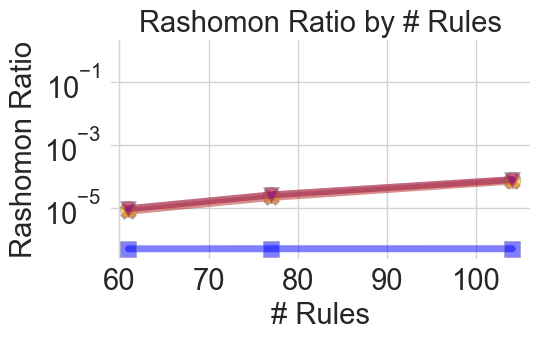

In [18]:
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = 'lightgray'
mpl.rcParams["mathtext.default"] = "regular"

plt.figure(figsize=((5.5, 3.5)))
# Plot the first data on the first subplot
#ax1.plot([61 , 77, 104], y1, color='red')
#ax1.set_title('Plot 1')

x = [61, 77, 104]
plt.xlim(x[0]-2, x[-1]+2)

#print(times_MC)

plt.plot(x, counts_by_rules,  marker='X', color = "firebrick" , linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 
# this is below 

plt.plot(x, all_averages_counts_MC, marker='o', color = "orange" ,   linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

plt.plot(x, all_averages_counts_GT, marker='v', 
        color = "purple",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

plt.plot(x, counts_by_rules_naive , marker='s', 
        color = "blue",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

#ax1.legend(fontsize = 16)

#ax1.set_title('Runtime VS # Rules ( l = ' + str(l) + " k = " + str(k) + " )" , fontsize = 16)
plt.title("Rashomon Ratio by # Rules" , fontsize = 21)

plt.xlabel(" # Rules ", fontsize = 21 )

plt.ylabel(" Rashomon Ratio " , fontsize = 21 ) 

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xticks(fontsize=21)  # Change the fontsize to your desired value
plt.yticks(fontsize=21)

hB, = plot([1,1],'firebrick' , marker='X', linewidth=3 , markersize = 10, markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
hHP, = plot([1,1], "orange", marker='o',  linewidth=3 , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.8)
hS, = plot([1,1],'purple' , marker='v' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#   hD, = plot([1,1],'salmon' , marker='D' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#   hF, = plot([1,1], 'brown' , marker='P' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#legend(( hB, hHP, hS,), ( "SampleTree-RS" , "ApproxMC-RS",   "FullBB-RS") ,loc='upper center', bbox_to_anchor=(-1, 1.25 ), ncol=3, fancybox=False, shadow=False, borderaxespad=0, fontsize = 14 )
#legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.21 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
hB.set_visible(False)
hS.set_visible(False)
hHP.set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()


plt.savefig("compas_1000_runtime_vs_n_rules_with_naive" +  "_log.pdf") 

# Display the plots
plt.show()

/tmp/ipykernel_160500/1467564471.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
/tmp/ipykernel_160500/1467564471.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])


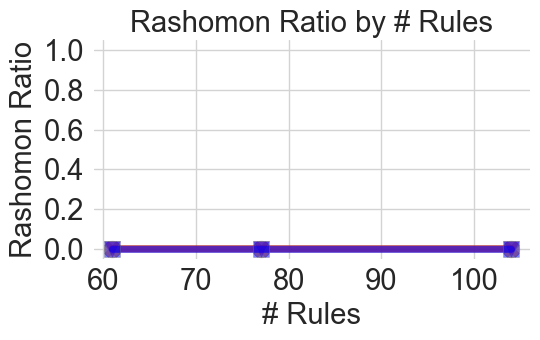

In [19]:
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = 'lightgray'
mpl.rcParams["mathtext.default"] = "regular"

plt.figure(figsize=((5.5, 3.5)))
# Plot the first data on the first subplot
#ax1.plot([61 , 77, 104], y1, color='red')
#ax1.set_title('Plot 1')

x = [61, 77, 104]
plt.xlim(x[0]-2, x[-1]+2)

#print(times_MC)

plt.plot(x, counts_by_rules,  marker='X', color = "firebrick" , linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 
# this is below 

plt.plot(x, all_averages_counts_MC, marker='o', color = "orange" ,   linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

plt.plot(x, all_averages_counts_GT, marker='v', 
        color = "purple",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

plt.plot(x, counts_by_rules_naive , marker='s', 
        color = "blue",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

#ax1.legend(fontsize = 16)

#ax1.set_title('Runtime VS # Rules ( l = ' + str(l) + " k = " + str(k) + " )" , fontsize = 16)
plt.title("Rashomon Ratio by # Rules" , fontsize = 21)

plt.xlabel(" # Rules ", fontsize = 21 )

plt.ylabel(" Rashomon Ratio " , fontsize = 21 ) 

#plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xticks(fontsize=21)  # Change the fontsize to your desired value
plt.yticks(fontsize=21)

hB, = plot([1,1],'firebrick' , marker='X', linewidth=3 , markersize = 10, markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
hHP, = plot([1,1], "orange", marker='o',  linewidth=3 , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.8)
hS, = plot([1,1],'purple' , marker='v' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#   hD, = plot([1,1],'salmon' , marker='D' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#   hF, = plot([1,1], 'brown' , marker='P' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#legend(( hB, hHP, hS,), ( "SampleTree-RS" , "ApproxMC-RS",   "FullBB-RS") ,loc='upper center', bbox_to_anchor=(-1, 1.25 ), ncol=3, fancybox=False, shadow=False, borderaxespad=0, fontsize = 14 )
#legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.21 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
hB.set_visible(False)
hS.set_visible(False)
hHP.set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()


plt.savefig("compas_1000_runtime_vs_n_rules_with_naive" +  ".pdf") 

# Display the plots
plt.show()

In [14]:
# Load the CSV file using Pandas
dataset = "mushrooms"
data = pd.read_csv('data/mushrooms.csv')

# Print the data
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [15]:
y = data["class"]
data = data.drop('class', axis=1)
data = pd.get_dummies(data).astype("int")
X = data.to_numpy()

In [16]:
y = np.array(y, dtype = bool) 
assert len(y) == X.shape[0]


In [17]:
# now we need to extract rules 
from bds.fpgrowth import preprocess_transaction_list, build_fptree, fpgrowth_on_tree
from bds.bb import get_ground_truth_count
from bds.bbSampleTreeApproxCounting import BranchAndBoundNaive
import time 
import random
from bds.rule import Rule
from time import time
#from bds.bbSampleTree import BranchAndBoundNaive
import time 
import random
from bds.bbSampleTreeApproxCounting import BranchAndBoundNaive
import time 
import random

def compute_truthtable(X,itemset): 
    ''' poorly optimized function '''
    support_list = [] 
    for i in range(X.shape[0]): 
        if sum([X[i][j] for j in itemset]) == len(itemset): 
            support_list.append(i)
                
    truthtable = mpz_set_bits(mpz(), support_list)
    
    return truthtable


X_bag = [set([j for j, x in enumerate(row) if x]) for row in X]


In [21]:
dataset = "mushroom"

n_reps = 1 
lmbd = 0.1 
ub = 0.5
rand_seed = 1234
n_reps = 1

delta = .8
eps = .8
all_averages_times_MC = [] 
all_averages_times_GT = [] 

all_averages_counts_MC = [] 
all_averages_counts_GT = []

all_n_rules = []

for min_support in [5000, 5500, 6000]:

    print("min support " + str(min_support))

    ordered_input_data = preprocess_transaction_list(
        X_bag, min_support
    )
    tree = build_fptree(ordered_input_data)
    frequent_itemsets = set(fpgrowth_on_tree(tree, set(), min_support))

    all_n_rules.append(len(frequent_itemsets)) 

    print(len(frequent_itemsets))
    
    # Now create rules 
    rules = [] 
    for i,itemset in enumerate(frequent_itemsets):
        tt = compute_truthtable(X,itemset)
        this_Rule = Rule(id = i+1, name = "rule_" + str(i), cardinality=len(itemset), truthtable=tt)
        # we need the truthtable for this itemset 
        rules.append(this_Rule)
        
        t0 = count_total( len(rules), len(rules))


    pickle.dump(rules, open("rules/rules_05_" + dataset + "_" +  str(len(rules)), "wb" ))

    # approxMC
    all_times_MC = [] 
    all_counts_MC = [] 

    all_times_GT = [] 
    all_counts_GT = [] 


    for _ in range(n_reps):


        t = time.time() 
        test_cnt = approx_mc2(
                    rules, y, lmbd=lmbd, ub=ub,
                    delta=delta, eps=eps, rand_seed=rand_seed, show_progress=show_progres,
                    parallel=False, log_level=logging.WARN
                )

        elapsed = time.time() - t 
        all_times_MC.append(elapsed) 
        all_counts_MC.append(test_cnt / t0)


        # complete enumeration 
        ref_count = get_ground_truth_count(rules, y, lmbd, ub)
        all_times_GT.append(elapsed) 
        all_counts_GT.append(ref_count / t0) 

    all_averages_times_MC.append(np.mean(all_times_MC))
    all_averages_times_GT.append(np.mean(all_times_GT))

    all_averages_counts_MC.append(np.mean(all_counts_MC))
    all_averages_counts_GT.append(np.mean(all_counts_GT))


pickle.dump(all_averages_times_MC, open("all_averages_times_MC_" + dataset + "_" + str(len(rules)) + "_" + str(eps) + "_" + str(delta), "wb" ))
pickle.dump(all_averages_times_GT, open("all_averages_times_GT_" + dataset + "_" + str(len(rules)) + "_" + str(eps) + "_" + str(delta) , "wb" ))

pickle.dump(all_averages_counts_MC, open("all_averages_counts_MC_" + dataset + "_" + "_" + str(len(rules)) + "_" + str(eps) + "_" + str(delta) , "wb" ))
pickle.dump(all_averages_counts_GT, open("all_averages_counts_GT_" + dataset + "_" + str(len(rules)) + "_" + str(eps) + "_" + str(delta), "wb" ))


min support 5000
41


[D 230816 02:35:08 meel:362] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230816 02:35:08 meel:365] thresh = 72.95
[D 230816 02:35:08 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 02:35:08 meel:376] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230816 02:35:08 meel:388] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230816 02:35:08 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:08 meel:280] initial solving under 40 constraints
[D 230816 02:35:08 cbb:160] setting up the parity constraint system
[D 230816 02:35:08 meel:283] solving takes 0.01 secs
[D 230816 02:35:08 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 02:35:08 meel:98] calling log_search with thresh=72
[D 230816 02:35:08 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:08 mee

m (to return): 12
time_cost_info: 
|1|0.00801251100006084|
|2|0.00857737299998007|
|3|0.013399734000131502|
|4|0.012730063999924823|
|8|0.02215060999992602|
|16|0.4179688729998361|
|12|1.1371832360000553|
|10|0.02457530899982885|
|11|1.0901210189999802|


[D 230816 02:35:12 meel:149] search tree size: 16960
[D 230816 02:35:12 meel:150] number of prefix evaluations: 133380
[D 230816 02:35:12 meel:152] solving takes 1.05 secs
[D 230816 02:35:12 meel:198] |Y| < thresh (28 < 72)
[D 230816 02:35:12 meel:137] ---- solve m = 11----
[D 230816 02:35:12 cbb:160] setting up the parity constraint system
[D 230816 02:35:14 meel:149] search tree size: 20482
[D 230816 02:35:14 meel:150] number of prefix evaluations: 294101
[D 230816 02:35:14 meel:152] solving takes 1.91 secs
[D 230816 02:35:14 meel:198] |Y| < thresh (56 < 72)
[D 230816 02:35:14 meel:137] ---- solve m = 10----
[D 230816 02:35:14 cbb:160] setting up the parity constraint system
[D 230816 02:35:14 meel:149] search tree size: 2305
[D 230816 02:35:14 meel:150] number of prefix evaluations: 296668
[D 230816 02:35:14 meel:152] solving takes 0.08 secs
[D 230816 02:35:14 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:14 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:14 meel:411] runni

m (to return): 11
time_cost_info: 
|12|1.0456935489999069|
|11|1.9072571799999878|
|10|0.07678755400002046|


[D 230816 02:35:15 meel:149] search tree size: 17549
[D 230816 02:35:15 meel:150] number of prefix evaluations: 152652
[D 230816 02:35:15 meel:152] solving takes 1.01 secs
[D 230816 02:35:15 meel:198] |Y| < thresh (69 < 72)
[D 230816 02:35:15 meel:137] ---- solve m = 10----
[D 230816 02:35:15 cbb:160] setting up the parity constraint system
[D 230816 02:35:15 meel:149] search tree size: 1386
[D 230816 02:35:15 meel:150] number of prefix evaluations: 154237
[D 230816 02:35:15 meel:152] solving takes 0.04 secs
[D 230816 02:35:15 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:15 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:15 meel:411] running approx_mc2_core takes 1.09s
[D 230816 02:35:15 meel:414] num_cells: 2048, num_sols: 69
  9%|████▏                                       | 3/32 [00:07<01:01,  2.12s/it][D 230816 02:35:15 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:15 meel:280] initial solving under 40 constraints
[D 230816 02:35:15 cbb:16

m (to return): 11
time_cost_info: 
|11|1.010967490999974|
|10|0.040386491999925056|


[D 230816 02:35:16 meel:149] search tree size: 19531
[D 230816 02:35:16 meel:150] number of prefix evaluations: 157803
[D 230816 02:35:16 meel:152] solving takes 1.10 secs
[D 230816 02:35:16 meel:198] |Y| < thresh (68 < 72)
[D 230816 02:35:16 meel:137] ---- solve m = 10----
[D 230816 02:35:16 cbb:160] setting up the parity constraint system
[D 230816 02:35:16 meel:149] search tree size: 1666
[D 230816 02:35:16 meel:150] number of prefix evaluations: 159631
[D 230816 02:35:16 meel:152] solving takes 0.05 secs
[D 230816 02:35:16 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:16 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:16 meel:411] running approx_mc2_core takes 1.18s
[D 230816 02:35:16 meel:414] num_cells: 2048, num_sols: 68
 12%|█████▌                                      | 4/32 [00:08<00:49,  1.75s/it][D 230816 02:35:16 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:16 meel:280] initial solving under 40 constraints
[D 230816 02:35:16 cbb:16

m (to return): 11
time_cost_info: 
|11|1.1049134830000185|
|10|0.04597980399989865|


[D 230816 02:35:17 meel:149] search tree size: 21470
[D 230816 02:35:17 meel:150] number of prefix evaluations: 26867
[D 230816 02:35:17 meel:152] solving takes 1.14 secs
[D 230816 02:35:17 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:17 meel:137] ---- solve m = 12----
[D 230816 02:35:17 cbb:160] setting up the parity constraint system
[D 230816 02:35:18 meel:149] search tree size: 18974
[D 230816 02:35:18 meel:150] number of prefix evaluations: 166209
[D 230816 02:35:18 meel:152] solving takes 1.18 secs
[D 230816 02:35:18 meel:198] |Y| < thresh (31 < 72)
[D 230816 02:35:18 meel:204] big_cell[11]=1, return 12
[D 230816 02:35:18 meel:411] running approx_mc2_core takes 2.35s
[D 230816 02:35:18 meel:414] num_cells: 4096, num_sols: 31
 16%|██████▉                                     | 5/32 [00:10<00:53,  1.97s/it][D 230816 02:35:18 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:18 meel:280] initial solving under 40 constraints
[D 230816 02:35:18 cbb:16

time_cost_info: 
|11|1.141456647000041|
|12|1.176026661999913|


[D 230816 02:35:20 meel:149] search tree size: 17876
[D 230816 02:35:20 meel:150] number of prefix evaluations: 136011
[D 230816 02:35:20 meel:152] solving takes 1.66 secs
[D 230816 02:35:20 meel:198] |Y| < thresh (29 < 72)
[D 230816 02:35:20 meel:137] ---- solve m = 11----
[D 230816 02:35:20 cbb:160] setting up the parity constraint system
[D 230816 02:35:21 meel:149] search tree size: 19101
[D 230816 02:35:21 meel:150] number of prefix evaluations: 293864
[D 230816 02:35:21 meel:152] solving takes 1.17 secs
[D 230816 02:35:21 meel:198] |Y| < thresh (65 < 72)
[D 230816 02:35:21 meel:137] ---- solve m = 10----
[D 230816 02:35:21 cbb:160] setting up the parity constraint system
[D 230816 02:35:21 meel:149] search tree size: 2175
[D 230816 02:35:21 meel:150] number of prefix evaluations: 296279
[D 230816 02:35:21 meel:152] solving takes 0.07 secs
[D 230816 02:35:21 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:21 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:21 meel:411] runni

m (to return): 11
time_cost_info: 
|12|1.6613744329999918|
|11|1.172865492000028|
|10|0.06605125800001588|


[D 230816 02:35:22 meel:149] search tree size: 17352
[D 230816 02:35:22 meel:150] number of prefix evaluations: 149657
[D 230816 02:35:22 meel:152] solving takes 1.12 secs
[D 230816 02:35:22 meel:198] |Y| < thresh (63 < 72)
[D 230816 02:35:22 meel:137] ---- solve m = 10----
[D 230816 02:35:22 cbb:160] setting up the parity constraint system
[D 230816 02:35:23 meel:149] search tree size: 2475
[D 230816 02:35:23 meel:150] number of prefix evaluations: 152448
[D 230816 02:35:23 meel:152] solving takes 0.65 secs
[D 230816 02:35:23 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:23 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:23 meel:411] running approx_mc2_core takes 1.81s
[D 230816 02:35:23 meel:414] num_cells: 2048, num_sols: 63
 22%|█████████▋                                  | 7/32 [00:15<00:53,  2.14s/it][D 230816 02:35:23 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:23 meel:280] initial solving under 40 constraints
[D 230816 02:35:23 cbb:16

m (to return): 11
time_cost_info: 
|11|1.117590736000011|
|10|0.6506937629999356|


[D 230816 02:35:24 meel:149] search tree size: 16008
[D 230816 02:35:24 meel:150] number of prefix evaluations: 143070
[D 230816 02:35:24 meel:152] solving takes 1.03 secs
[D 230816 02:35:24 meel:198] |Y| < thresh (70 < 72)
[D 230816 02:35:24 meel:137] ---- solve m = 10----
[D 230816 02:35:24 cbb:160] setting up the parity constraint system
[D 230816 02:35:24 meel:149] search tree size: 1884
[D 230816 02:35:24 meel:150] number of prefix evaluations: 145202
[D 230816 02:35:24 meel:152] solving takes 0.06 secs
[D 230816 02:35:24 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:24 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:24 meel:411] running approx_mc2_core takes 1.14s
[D 230816 02:35:24 meel:414] num_cells: 2048, num_sols: 70
 25%|███████████                                 | 8/32 [00:16<00:43,  1.83s/it][D 230816 02:35:24 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:24 meel:280] initial solving under 40 constraints
[D 230816 02:35:24 cbb:16

m (to return): 11
time_cost_info: 
|11|1.0277309180000884|
|10|0.05660508400001163|


[D 230816 02:35:25 meel:149] search tree size: 18334
[D 230816 02:35:25 meel:150] number of prefix evaluations: 27488
[D 230816 02:35:25 meel:152] solving takes 0.52 secs
[D 230816 02:35:25 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:25 meel:137] ---- solve m = 12----
[D 230816 02:35:25 cbb:160] setting up the parity constraint system
[D 230816 02:35:26 meel:149] search tree size: 16367
[D 230816 02:35:26 meel:150] number of prefix evaluations: 158530
[D 230816 02:35:26 meel:152] solving takes 1.55 secs
[D 230816 02:35:26 meel:198] |Y| < thresh (35 < 72)
[D 230816 02:35:26 meel:204] big_cell[11]=1, return 12
[D 230816 02:35:26 meel:411] running approx_mc2_core takes 2.09s
[D 230816 02:35:26 meel:414] num_cells: 4096, num_sols: 35
 28%|████████████▍                               | 9/32 [00:18<00:43,  1.91s/it][D 230816 02:35:26 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:26 meel:280] initial solving under 40 constraints
[D 230816 02:35:26 cbb:16

time_cost_info: 
|11|0.5153549899998779|
|12|1.545298707000029|


[D 230816 02:35:27 meel:149] search tree size: 16119
[D 230816 02:35:27 meel:150] number of prefix evaluations: 127276
[D 230816 02:35:27 meel:152] solving takes 0.92 secs
[D 230816 02:35:27 meel:198] |Y| < thresh (47 < 72)
[D 230816 02:35:27 meel:137] ---- solve m = 11----
[D 230816 02:35:27 cbb:160] setting up the parity constraint system
[D 230816 02:35:28 meel:149] search tree size: 16455
[D 230816 02:35:28 meel:150] number of prefix evaluations: 155737
[D 230816 02:35:28 meel:152] solving takes 0.57 secs
[D 230816 02:35:28 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:28 meel:174] big_cell[12]=0, return 12
[D 230816 02:35:28 meel:411] running approx_mc2_core takes 1.54s
[D 230816 02:35:28 meel:414] num_cells: 4096, num_sols: 47
 31%|█████████████▍                             | 10/32 [00:20<00:39,  1.80s/it][D 230816 02:35:28 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:28 meel:280] initial solving under 40 constraints
[D 230816 02:35:28 cbb:1

m (to return): 12
time_cost_info: 
|12|0.9184465940002156|
|11|0.5654732620000686|


[D 230816 02:35:29 meel:149] search tree size: 13926
[D 230816 02:35:29 meel:150] number of prefix evaluations: 122571
[D 230816 02:35:29 meel:152] solving takes 1.46 secs
[D 230816 02:35:29 meel:198] |Y| < thresh (34 < 72)
[D 230816 02:35:29 meel:137] ---- solve m = 11----
[D 230816 02:35:29 cbb:160] setting up the parity constraint system
[D 230816 02:35:31 meel:149] search tree size: 22041
[D 230816 02:35:31 meel:150] number of prefix evaluations: 288449
[D 230816 02:35:31 meel:152] solving takes 1.27 secs
[D 230816 02:35:31 meel:198] |Y| < thresh (64 < 72)
[D 230816 02:35:31 meel:137] ---- solve m = 10----
[D 230816 02:35:31 cbb:160] setting up the parity constraint system
[D 230816 02:35:31 meel:149] search tree size: 1460
[D 230816 02:35:31 meel:150] number of prefix evaluations: 290045
[D 230816 02:35:31 meel:152] solving takes 0.05 secs
[D 230816 02:35:31 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:31 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:31 meel:411] runni

m (to return): 11
time_cost_info: 
|12|1.4585364279998885|
|11|1.2713101370000004|
|10|0.048182453999970676|


[D 230816 02:35:32 meel:149] search tree size: 20494
[D 230816 02:35:32 meel:150] number of prefix evaluations: 161742
[D 230816 02:35:32 meel:152] solving takes 1.68 secs
[D 230816 02:35:32 meel:198] |Y| < thresh (68 < 72)
[D 230816 02:35:32 meel:137] ---- solve m = 10----
[D 230816 02:35:32 cbb:160] setting up the parity constraint system
[D 230816 02:35:32 meel:149] search tree size: 1463
[D 230816 02:35:32 meel:150] number of prefix evaluations: 163304
[D 230816 02:35:32 meel:152] solving takes 0.04 secs
[D 230816 02:35:32 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:32 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:32 meel:411] running approx_mc2_core takes 1.76s
[D 230816 02:35:32 meel:414] num_cells: 2048, num_sols: 68
 38%|████████████████▏                          | 12/32 [00:24<00:40,  2.01s/it][D 230816 02:35:32 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:32 meel:280] initial solving under 40 constraints
[D 230816 02:35:32 cbb:16

m (to return): 11
time_cost_info: 
|11|1.680310850000069|
|10|0.04052466300004198|


[D 230816 02:35:33 meel:149] search tree size: 13531
[D 230816 02:35:33 meel:150] number of prefix evaluations: 17671
[D 230816 02:35:33 meel:152] solving takes 0.32 secs
[D 230816 02:35:33 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:33 meel:137] ---- solve m = 12----
[D 230816 02:35:33 cbb:160] setting up the parity constraint system
[D 230816 02:35:34 meel:149] search tree size: 15286
[D 230816 02:35:34 meel:150] number of prefix evaluations: 140544
[D 230816 02:35:34 meel:152] solving takes 0.89 secs
[D 230816 02:35:34 meel:198] |Y| < thresh (45 < 72)
[D 230816 02:35:34 meel:204] big_cell[11]=1, return 12
[D 230816 02:35:34 meel:411] running approx_mc2_core takes 1.23s
[D 230816 02:35:34 meel:414] num_cells: 4096, num_sols: 45
 41%|█████████████████▍                         | 13/32 [00:25<00:33,  1.77s/it][D 230816 02:35:34 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:34 meel:280] initial solving under 40 constraints
[D 230816 02:35:34 cbb:16

time_cost_info: 
|11|0.3210060290000456|
|12|0.8888116600001013|


[D 230816 02:35:35 meel:149] search tree size: 14735
[D 230816 02:35:35 meel:150] number of prefix evaluations: 126099
[D 230816 02:35:35 meel:152] solving takes 0.86 secs
[D 230816 02:35:35 meel:198] |Y| < thresh (37 < 72)
[D 230816 02:35:35 meel:137] ---- solve m = 11----
[D 230816 02:35:35 cbb:160] setting up the parity constraint system
[D 230816 02:35:36 meel:149] search tree size: 19159
[D 230816 02:35:36 meel:150] number of prefix evaluations: 283125
[D 230816 02:35:36 meel:152] solving takes 1.77 secs
[D 230816 02:35:36 meel:198] |Y| < thresh (71 < 72)
[D 230816 02:35:36 meel:137] ---- solve m = 10----
[D 230816 02:35:36 cbb:160] setting up the parity constraint system
[D 230816 02:35:36 meel:149] search tree size: 2417
[D 230816 02:35:36 meel:150] number of prefix evaluations: 285780
[D 230816 02:35:36 meel:152] solving takes 0.06 secs
[D 230816 02:35:36 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:36 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:36 meel:411] runni

m (to return): 11
time_cost_info: 
|12|0.8591761100001349|
|11|1.7696061870001358|
|10|0.06365362099995764|


[D 230816 02:35:38 meel:149] search tree size: 20914
[D 230816 02:35:38 meel:150] number of prefix evaluations: 162628
[D 230816 02:35:38 meel:152] solving takes 1.17 secs
[D 230816 02:35:38 meel:198] |Y| < thresh (51 < 72)
[D 230816 02:35:38 meel:137] ---- solve m = 10----
[D 230816 02:35:38 cbb:160] setting up the parity constraint system
[D 230816 02:35:38 meel:149] search tree size: 2722
[D 230816 02:35:38 meel:150] number of prefix evaluations: 165645
[D 230816 02:35:38 meel:152] solving takes 0.07 secs
[D 230816 02:35:38 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:38 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:38 meel:411] running approx_mc2_core takes 1.27s
[D 230816 02:35:38 meel:414] num_cells: 2048, num_sols: 51
 47%|████████████████████▏                      | 15/32 [00:29<00:31,  1.83s/it][D 230816 02:35:38 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:38 meel:280] initial solving under 40 constraints
[D 230816 02:35:38 cbb:16

m (to return): 11
time_cost_info: 
|11|1.1691551430001255|
|10|0.06929095099985716|


[D 230816 02:35:39 meel:149] search tree size: 20688
[D 230816 02:35:39 meel:150] number of prefix evaluations: 162418
[D 230816 02:35:39 meel:152] solving takes 1.73 secs
[D 230816 02:35:39 meel:198] |Y| < thresh (69 < 72)
[D 230816 02:35:39 meel:137] ---- solve m = 10----
[D 230816 02:35:39 cbb:160] setting up the parity constraint system
[D 230816 02:35:40 meel:149] search tree size: 2013
[D 230816 02:35:40 meel:150] number of prefix evaluations: 164660
[D 230816 02:35:40 meel:152] solving takes 0.06 secs
[D 230816 02:35:40 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:40 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:40 meel:411] running approx_mc2_core takes 1.82s
[D 230816 02:35:40 meel:414] num_cells: 2048, num_sols: 69
 50%|█████████████████████▌                     | 16/32 [00:31<00:29,  1.83s/it][D 230816 02:35:40 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:40 meel:280] initial solving under 40 constraints
[D 230816 02:35:40 cbb:16

m (to return): 11
time_cost_info: 
|11|1.728804916000172|
|10|0.05867663700018966|


[D 230816 02:35:40 meel:149] search tree size: 16632
[D 230816 02:35:40 meel:150] number of prefix evaluations: 22262
[D 230816 02:35:40 meel:152] solving takes 0.39 secs
[D 230816 02:35:40 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:40 meel:137] ---- solve m = 12----
[D 230816 02:35:40 cbb:160] setting up the parity constraint system
[D 230816 02:35:42 meel:149] search tree size: 19675
[D 230816 02:35:42 meel:150] number of prefix evaluations: 163090
[D 230816 02:35:42 meel:152] solving takes 1.69 secs
[D 230816 02:35:42 meel:198] |Y| < thresh (35 < 72)
[D 230816 02:35:42 meel:204] big_cell[11]=1, return 12
[D 230816 02:35:42 meel:411] running approx_mc2_core takes 2.12s
[D 230816 02:35:42 meel:414] num_cells: 4096, num_sols: 35
 53%|██████████████████████▊                    | 17/32 [00:33<00:28,  1.91s/it][D 230816 02:35:42 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:42 meel:280] initial solving under 40 constraints
[D 230816 02:35:42 cbb:16

time_cost_info: 
|11|0.3881754390001788|
|12|1.6949637610000536|


[D 230816 02:35:43 meel:149] search tree size: 15340
[D 230816 02:35:43 meel:150] number of prefix evaluations: 128416
[D 230816 02:35:43 meel:152] solving takes 0.88 secs
[D 230816 02:35:43 meel:198] |Y| < thresh (30 < 72)
[D 230816 02:35:43 meel:137] ---- solve m = 11----
[D 230816 02:35:43 cbb:160] setting up the parity constraint system
[D 230816 02:35:44 meel:149] search tree size: 18764
[D 230816 02:35:44 meel:150] number of prefix evaluations: 284706
[D 230816 02:35:44 meel:152] solving takes 1.10 secs
[D 230816 02:35:44 meel:198] |Y| < thresh (65 < 72)
[D 230816 02:35:44 meel:137] ---- solve m = 10----
[D 230816 02:35:44 cbb:160] setting up the parity constraint system
[D 230816 02:35:44 meel:149] search tree size: 1865
[D 230816 02:35:44 meel:150] number of prefix evaluations: 286670
[D 230816 02:35:44 meel:152] solving takes 0.05 secs
[D 230816 02:35:44 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:44 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:44 meel:411] runni

m (to return): 11
time_cost_info: 
|12|0.8792086160001418|
|11|1.1012423970000782|
|10|0.05383204399981878|


[D 230816 02:35:45 meel:149] search tree size: 16470
[D 230816 02:35:45 meel:150] number of prefix evaluations: 23862
[D 230816 02:35:45 meel:152] solving takes 1.05 secs
[D 230816 02:35:45 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:45 meel:137] ---- solve m = 12----
[D 230816 02:35:45 cbb:160] setting up the parity constraint system
[D 230816 02:35:46 meel:149] search tree size: 14908
[D 230816 02:35:46 meel:150] number of prefix evaluations: 148613
[D 230816 02:35:46 meel:152] solving takes 0.87 secs
[D 230816 02:35:46 meel:198] |Y| < thresh (39 < 72)
[D 230816 02:35:46 meel:204] big_cell[11]=1, return 12
[D 230816 02:35:46 meel:411] running approx_mc2_core takes 1.96s
[D 230816 02:35:46 meel:414] num_cells: 4096, num_sols: 39
 59%|█████████████████████████▌                 | 19/32 [00:37<00:25,  1.96s/it][D 230816 02:35:46 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:46 meel:280] initial solving under 40 constraints
[D 230816 02:35:46 cbb:16

time_cost_info: 
|11|1.0542665309999393|
|12|0.8707902779999586|


[D 230816 02:35:46 meel:149] search tree size: 13312
[D 230816 02:35:47 meel:150] number of prefix evaluations: 118247
[D 230816 02:35:47 meel:152] solving takes 0.77 secs
[D 230816 02:35:47 meel:198] |Y| < thresh (30 < 72)
[D 230816 02:35:47 meel:137] ---- solve m = 11----
[D 230816 02:35:47 cbb:160] setting up the parity constraint system
[D 230816 02:35:48 meel:149] search tree size: 18197
[D 230816 02:35:48 meel:150] number of prefix evaluations: 272580
[D 230816 02:35:48 meel:152] solving takes 1.66 secs
[D 230816 02:35:48 meel:198] |Y| < thresh (66 < 72)
[D 230816 02:35:48 meel:137] ---- solve m = 10----
[D 230816 02:35:48 cbb:160] setting up the parity constraint system
[D 230816 02:35:48 meel:149] search tree size: 1333
[D 230816 02:35:48 meel:150] number of prefix evaluations: 274083
[D 230816 02:35:48 meel:152] solving takes 0.04 secs
[D 230816 02:35:48 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:48 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:48 meel:411] runni

m (to return): 11
time_cost_info: 
|12|0.7749081599999954|
|11|1.655777758999875|
|10|0.04389450799999395|


[D 230816 02:35:49 meel:149] search tree size: 21731
[D 230816 02:35:49 meel:150] number of prefix evaluations: 164241
[D 230816 02:35:49 meel:152] solving takes 1.20 secs
[D 230816 02:35:49 meel:198] |Y| < thresh (61 < 72)
[D 230816 02:35:49 meel:137] ---- solve m = 10----
[D 230816 02:35:49 cbb:160] setting up the parity constraint system
[D 230816 02:35:50 meel:149] search tree size: 1847
[D 230816 02:35:50 meel:150] number of prefix evaluations: 166291
[D 230816 02:35:50 meel:152] solving takes 0.06 secs
[D 230816 02:35:50 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:50 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:50 meel:411] running approx_mc2_core takes 1.29s
[D 230816 02:35:50 meel:414] num_cells: 2048, num_sols: 61
 66%|████████████████████████████▏              | 21/32 [00:41<00:20,  1.88s/it][D 230816 02:35:50 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:50 meel:280] initial solving under 40 constraints
[D 230816 02:35:50 cbb:16

m (to return): 11
time_cost_info: 
|11|1.2048486609999145|
|10|0.05558285400002205|


[D 230816 02:35:51 meel:149] search tree size: 19873
[D 230816 02:35:51 meel:150] number of prefix evaluations: 154902
[D 230816 02:35:51 meel:152] solving takes 1.69 secs
[D 230816 02:35:51 meel:198] |Y| < thresh (63 < 72)
[D 230816 02:35:51 meel:137] ---- solve m = 10----
[D 230816 02:35:51 cbb:160] setting up the parity constraint system
[D 230816 02:35:51 meel:149] search tree size: 2256
[D 230816 02:35:51 meel:150] number of prefix evaluations: 157295
[D 230816 02:35:51 meel:152] solving takes 0.06 secs
[D 230816 02:35:51 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:51 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:51 meel:411] running approx_mc2_core takes 1.78s
[D 230816 02:35:51 meel:414] num_cells: 2048, num_sols: 63
 69%|█████████████████████████████▌             | 22/32 [00:43<00:18,  1.85s/it][D 230816 02:35:51 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:51 meel:280] initial solving under 40 constraints
[D 230816 02:35:51 cbb:16

m (to return): 11
time_cost_info: 
|11|1.6852643080001144|
|10|0.058389446999854044|


[D 230816 02:35:52 meel:149] search tree size: 18425
[D 230816 02:35:52 meel:150] number of prefix evaluations: 154732
[D 230816 02:35:52 meel:152] solving takes 1.06 secs
[D 230816 02:35:52 meel:198] |Y| < thresh (67 < 72)
[D 230816 02:35:52 meel:137] ---- solve m = 10----
[D 230816 02:35:52 cbb:160] setting up the parity constraint system
[D 230816 02:35:52 meel:149] search tree size: 1995
[D 230816 02:35:52 meel:150] number of prefix evaluations: 157024
[D 230816 02:35:52 meel:152] solving takes 0.06 secs
[D 230816 02:35:52 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:52 meel:174] big_cell[11]=0, return 11
[D 230816 02:35:52 meel:411] running approx_mc2_core takes 1.14s
[D 230816 02:35:52 meel:414] num_cells: 2048, num_sols: 67
 72%|██████████████████████████████▉            | 23/32 [00:44<00:14,  1.64s/it][D 230816 02:35:52 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:52 meel:280] initial solving under 40 constraints
[D 230816 02:35:52 cbb:16

m (to return): 11
time_cost_info: 
|11|1.056294403000038|
|10|0.05734753499996259|


[D 230816 02:35:53 meel:149] search tree size: 17044
[D 230816 02:35:53 meel:150] number of prefix evaluations: 20623
[D 230816 02:35:53 meel:152] solving takes 0.38 secs
[D 230816 02:35:53 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:53 meel:137] ---- solve m = 12----
[D 230816 02:35:53 cbb:160] setting up the parity constraint system
[D 230816 02:35:54 meel:149] search tree size: 14213
[D 230816 02:35:54 meel:150] number of prefix evaluations: 137163
[D 230816 02:35:54 meel:152] solving takes 1.44 secs
[D 230816 02:35:54 meel:198] |Y| < thresh (43 < 72)
[D 230816 02:35:54 meel:204] big_cell[11]=1, return 12
[D 230816 02:35:54 meel:411] running approx_mc2_core takes 1.85s
[D 230816 02:35:54 meel:414] num_cells: 4096, num_sols: 43
 75%|████████████████████████████████▎          | 24/32 [00:46<00:13,  1.70s/it][D 230816 02:35:54 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:54 meel:280] initial solving under 40 constraints
[D 230816 02:35:54 cbb:16

time_cost_info: 
|11|0.37784635999992133|
|12|1.4431121520001398|


[D 230816 02:35:55 meel:149] search tree size: 14293
[D 230816 02:35:55 meel:150] number of prefix evaluations: 117694
[D 230816 02:35:55 meel:152] solving takes 0.79 secs
[D 230816 02:35:55 meel:198] |Y| < thresh (39 < 72)
[D 230816 02:35:55 meel:137] ---- solve m = 11----
[D 230816 02:35:55 cbb:160] setting up the parity constraint system
[D 230816 02:35:55 meel:149] search tree size: 13082
[D 230816 02:35:55 meel:150] number of prefix evaluations: 137356
[D 230816 02:35:55 meel:152] solving takes 0.34 secs
[D 230816 02:35:55 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:55 meel:174] big_cell[12]=0, return 12
[D 230816 02:35:55 meel:411] running approx_mc2_core takes 1.18s
[D 230816 02:35:55 meel:414] num_cells: 4096, num_sols: 39
 78%|█████████████████████████████████▌         | 25/32 [00:47<00:10,  1.55s/it][D 230816 02:35:56 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:56 meel:280] initial solving under 40 constraints
[D 230816 02:35:56 cbb:1

m (to return): 12
time_cost_info: 
|12|0.7905181520000042|
|11|0.3390863360000367|


[D 230816 02:35:57 meel:149] search tree size: 17777
[D 230816 02:35:57 meel:150] number of prefix evaluations: 135887
[D 230816 02:35:57 meel:152] solving takes 1.57 secs
[D 230816 02:35:57 meel:198] |Y| < thresh (44 < 72)
[D 230816 02:35:57 meel:137] ---- solve m = 11----
[D 230816 02:35:57 cbb:160] setting up the parity constraint system
[D 230816 02:35:58 meel:149] search tree size: 22032
[D 230816 02:35:58 meel:150] number of prefix evaluations: 166169
[D 230816 02:35:58 meel:152] solving takes 0.56 secs
[D 230816 02:35:58 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:35:58 meel:174] big_cell[12]=0, return 12
[D 230816 02:35:58 meel:411] running approx_mc2_core takes 2.21s
[D 230816 02:35:58 meel:414] num_cells: 4096, num_sols: 44
 81%|██████████████████████████████████▉        | 26/32 [00:49<00:10,  1.75s/it][D 230816 02:35:58 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:35:58 meel:280] initial solving under 40 constraints
[D 230816 02:35:58 cbb:1

m (to return): 12
time_cost_info: 
|12|1.5679527130000679|
|11|0.5648259800000233|


[D 230816 02:35:59 meel:149] search tree size: 18887
[D 230816 02:35:59 meel:150] number of prefix evaluations: 139290
[D 230816 02:35:59 meel:152] solving takes 1.62 secs
[D 230816 02:35:59 meel:198] |Y| < thresh (34 < 72)
[D 230816 02:35:59 meel:137] ---- solve m = 11----
[D 230816 02:35:59 cbb:160] setting up the parity constraint system
[D 230816 02:36:00 meel:149] search tree size: 17962
[D 230816 02:36:00 meel:150] number of prefix evaluations: 293220
[D 230816 02:36:00 meel:152] solving takes 1.01 secs
[D 230816 02:36:00 meel:198] |Y| < thresh (66 < 72)
[D 230816 02:36:00 meel:137] ---- solve m = 10----
[D 230816 02:36:00 cbb:160] setting up the parity constraint system
[D 230816 02:36:00 meel:149] search tree size: 2425
[D 230816 02:36:00 meel:150] number of prefix evaluations: 295952
[D 230816 02:36:00 meel:152] solving takes 0.06 secs
[D 230816 02:36:00 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:00 meel:174] big_cell[11]=0, return 11
[D 230816 02:36:00 meel:411] runni

m (to return): 11
time_cost_info: 
|12|1.6169644400001744|
|11|1.0071417159999783|
|10|0.06307852600002661|


[D 230816 02:36:01 meel:149] search tree size: 10502
[D 230816 02:36:01 meel:150] number of prefix evaluations: 13619
[D 230816 02:36:01 meel:152] solving takes 0.26 secs
[D 230816 02:36:01 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:01 meel:137] ---- solve m = 12----
[D 230816 02:36:01 cbb:160] setting up the parity constraint system
[D 230816 02:36:02 meel:149] search tree size: 14851
[D 230816 02:36:02 meel:150] number of prefix evaluations: 138333
[D 230816 02:36:02 meel:152] solving takes 1.45 secs
[D 230816 02:36:02 meel:198] |Y| < thresh (42 < 72)
[D 230816 02:36:02 meel:204] big_cell[11]=1, return 12
[D 230816 02:36:02 meel:411] running approx_mc2_core takes 1.74s
[D 230816 02:36:02 meel:414] num_cells: 4096, num_sols: 42
 88%|█████████████████████████████████████▋     | 28/32 [00:54<00:07,  1.96s/it][D 230816 02:36:02 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:02 meel:280] initial solving under 40 constraints
[D 230816 02:36:02 cbb:16

time_cost_info: 
|11|0.26143383700014056|
|12|1.4482358249999834|


[D 230816 02:36:03 meel:149] search tree size: 15057
[D 230816 02:36:03 meel:150] number of prefix evaluations: 122642
[D 230816 02:36:03 meel:152] solving takes 0.83 secs
[D 230816 02:36:03 meel:198] |Y| < thresh (34 < 72)
[D 230816 02:36:03 meel:137] ---- solve m = 11----
[D 230816 02:36:03 cbb:160] setting up the parity constraint system
[D 230816 02:36:03 meel:149] search tree size: 14244
[D 230816 02:36:03 meel:150] number of prefix evaluations: 148190
[D 230816 02:36:03 meel:152] solving takes 0.41 secs
[D 230816 02:36:03 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:03 meel:174] big_cell[12]=0, return 12
[D 230816 02:36:03 meel:411] running approx_mc2_core takes 1.30s
[D 230816 02:36:03 meel:414] num_cells: 4096, num_sols: 34
 91%|██████████████████████████████████████▉    | 29/32 [00:55<00:05,  1.76s/it][D 230816 02:36:04 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:04 meel:280] initial solving under 40 constraints
[D 230816 02:36:04 cbb:1

m (to return): 12
time_cost_info: 
|12|0.8303750349998609|
|11|0.40891447800004244|


[D 230816 02:36:04 meel:149] search tree size: 15359
[D 230816 02:36:04 meel:150] number of prefix evaluations: 127973
[D 230816 02:36:04 meel:152] solving takes 0.86 secs
[D 230816 02:36:04 meel:198] |Y| < thresh (28 < 72)
[D 230816 02:36:04 meel:137] ---- solve m = 11----
[D 230816 02:36:04 cbb:160] setting up the parity constraint system
[D 230816 02:36:06 meel:149] search tree size: 17897
[D 230816 02:36:06 meel:150] number of prefix evaluations: 281368
[D 230816 02:36:06 meel:152] solving takes 1.65 secs
[D 230816 02:36:06 meel:198] |Y| < thresh (55 < 72)
[D 230816 02:36:06 meel:137] ---- solve m = 10----
[D 230816 02:36:06 cbb:160] setting up the parity constraint system
[D 230816 02:36:06 meel:149] search tree size: 2225
[D 230816 02:36:06 meel:150] number of prefix evaluations: 283844
[D 230816 02:36:06 meel:152] solving takes 0.06 secs
[D 230816 02:36:06 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:06 meel:174] big_cell[11]=0, return 11
[D 230816 02:36:06 meel:411] runni

m (to return): 11
time_cost_info: 
|12|0.8611426920001577|
|11|1.6508145029999923|
|10|0.056913138000027175|


[D 230816 02:36:07 meel:149] search tree size: 22870
[D 230816 02:36:07 meel:150] number of prefix evaluations: 167969
[D 230816 02:36:07 meel:152] solving takes 1.26 secs
[D 230816 02:36:07 meel:198] |Y| < thresh (61 < 72)
[D 230816 02:36:07 meel:137] ---- solve m = 10----
[D 230816 02:36:07 cbb:160] setting up the parity constraint system
[D 230816 02:36:07 meel:149] search tree size: 2125
[D 230816 02:36:07 meel:150] number of prefix evaluations: 170345
[D 230816 02:36:07 meel:152] solving takes 0.06 secs
[D 230816 02:36:07 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:07 meel:174] big_cell[11]=0, return 11
[D 230816 02:36:07 meel:411] running approx_mc2_core takes 1.36s
[D 230816 02:36:07 meel:414] num_cells: 2048, num_sols: 61
 97%|█████████████████████████████████████████▋ | 31/32 [00:59<00:01,  1.82s/it][D 230816 02:36:07 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:07 meel:280] initial solving under 40 constraints
[D 230816 02:36:07 cbb:16

m (to return): 11
time_cost_info: 
|11|1.2637382379998598|
|10|0.061005435000197394|


[D 230816 02:36:09 meel:149] search tree size: 21289
[D 230816 02:36:09 meel:150] number of prefix evaluations: 164885
[D 230816 02:36:09 meel:152] solving takes 1.73 secs
[D 230816 02:36:09 meel:198] |Y| < thresh (68 < 72)
[D 230816 02:36:09 meel:137] ---- solve m = 10----
[D 230816 02:36:09 cbb:160] setting up the parity constraint system
[D 230816 02:36:09 meel:149] search tree size: 745
[D 230816 02:36:09 meel:150] number of prefix evaluations: 165665
[D 230816 02:36:09 meel:152] solving takes 0.02 secs
[D 230816 02:36:09 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:09 meel:174] big_cell[11]=0, return 11
[D 230816 02:36:09 meel:411] running approx_mc2_core takes 1.79s
[D 230816 02:36:09 meel:414] num_cells: 2048, num_sols: 68
100%|███████████████████████████████████████████| 32/32 [01:01<00:00,  1.92s/it]
[D 230816 02:36:09 meel:491] final estimate: 139264.0
[D 230816 02:36:09 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


m (to return): 11
time_cost_info: 
|11|1.7301753910001025|
|10|0.023926379000158704|
min support 5500
33


[D 230816 02:36:15 meel:362] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230816 02:36:15 meel:365] thresh = 72.95
[D 230816 02:36:15 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 02:36:15 meel:376] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230816 02:36:15 meel:388] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230816 02:36:15 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:15 meel:280] initial solving under 32 constraints
[D 230816 02:36:15 cbb:160] setting up the parity constraint system
[D 230816 02:36:15 meel:283] solving takes 0.01 secs
[D 230816 02:36:15 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 02:36:15 meel:98] calling log_search with thresh=72
[D 230816 02:36:15 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:15 mee

m (to return): 10
time_cost_info: 
|1|0.007819848000053753|
|2|0.005473418000065067|
|3|0.009798598000088532|
|4|0.010278706000008242|
|8|0.016118484999879|
|16|0.08696893900014402|
|12|0.17971032600007675|
|10|0.3025337110000237|
|9|0.031218531999911647|


[D 230816 02:36:16 meel:149] search tree size: 5031
[D 230816 02:36:16 meel:150] number of prefix evaluations: 34443
[D 230816 02:36:16 meel:152] solving takes 0.29 secs
[D 230816 02:36:16 meel:198] |Y| < thresh (58 < 72)
[D 230816 02:36:16 meel:137] ---- solve m = 9----
[D 230816 02:36:16 cbb:160] setting up the parity constraint system
[D 230816 02:36:16 meel:149] search tree size: 990
[D 230816 02:36:16 meel:150] number of prefix evaluations: 35551
[D 230816 02:36:16 meel:152] solving takes 0.03 secs
[D 230816 02:36:16 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:16 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:16 meel:411] running approx_mc2_core takes 0.35s
[D 230816 02:36:16 meel:414] num_cells: 1024, num_sols: 58
  6%|██▊                                         | 2/32 [00:01<00:14,  2.05it/s][D 230816 02:36:16 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:16 meel:280] initial solving under 32 constraints
[D 230816 02:36:16 cbb:160] se

m (to return): 10
time_cost_info: 
|10|0.28755867900008525|
|9|0.03376780799999324|


[D 230816 02:36:17 meel:149] search tree size: 6451
[D 230816 02:36:17 meel:150] number of prefix evaluations: 40023
[D 230816 02:36:17 meel:152] solving takes 0.35 secs
[D 230816 02:36:17 meel:198] |Y| < thresh (52 < 72)
[D 230816 02:36:17 meel:137] ---- solve m = 9----
[D 230816 02:36:17 cbb:160] setting up the parity constraint system
[D 230816 02:36:17 meel:149] search tree size: 1284
[D 230816 02:36:17 meel:150] number of prefix evaluations: 41572
[D 230816 02:36:17 meel:152] solving takes 0.04 secs
[D 230816 02:36:17 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:17 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:17 meel:411] running approx_mc2_core takes 0.41s
[D 230816 02:36:17 meel:414] num_cells: 1024, num_sols: 52
  9%|████▏                                       | 3/32 [00:01<00:13,  2.20it/s][D 230816 02:36:17 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:17 meel:280] initial solving under 32 constraints
[D 230816 02:36:17 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.34537596900008793|
|9|0.03932949400018515|


[D 230816 02:36:17 meel:149] search tree size: 4949
[D 230816 02:36:17 meel:150] number of prefix evaluations: 35071
[D 230816 02:36:17 meel:152] solving takes 0.29 secs
[D 230816 02:36:17 meel:198] |Y| < thresh (51 < 72)
[D 230816 02:36:17 meel:137] ---- solve m = 9----
[D 230816 02:36:17 cbb:160] setting up the parity constraint system
[D 230816 02:36:17 meel:149] search tree size: 1118
[D 230816 02:36:17 meel:150] number of prefix evaluations: 36328
[D 230816 02:36:17 meel:152] solving takes 0.04 secs
[D 230816 02:36:17 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:17 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:17 meel:411] running approx_mc2_core takes 0.35s
[D 230816 02:36:17 meel:414] num_cells: 1024, num_sols: 51
 12%|█████▌                                      | 4/32 [00:01<00:11,  2.42it/s][D 230816 02:36:17 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:17 meel:280] initial solving under 32 constraints
[D 230816 02:36:17 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.28561607699998603|
|9|0.03908413199997085|


[D 230816 02:36:18 meel:149] search tree size: 6505
[D 230816 02:36:18 meel:150] number of prefix evaluations: 40839
[D 230816 02:36:18 meel:152] solving takes 0.36 secs
[D 230816 02:36:18 meel:198] |Y| < thresh (54 < 72)
[D 230816 02:36:18 meel:137] ---- solve m = 9----
[D 230816 02:36:18 cbb:160] setting up the parity constraint system
[D 230816 02:36:18 meel:149] search tree size: 1703
[D 230816 02:36:18 meel:150] number of prefix evaluations: 42896
[D 230816 02:36:18 meel:152] solving takes 0.05 secs
[D 230816 02:36:18 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:18 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:18 meel:411] running approx_mc2_core takes 0.44s
[D 230816 02:36:18 meel:414] num_cells: 1024, num_sols: 54
 16%|██████▉                                     | 5/32 [00:02<00:11,  2.35it/s][D 230816 02:36:18 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:18 meel:280] initial solving under 32 constraints
[D 230816 02:36:18 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.36090323199982777|
|9|0.05200424800000292|


[D 230816 02:36:18 meel:149] search tree size: 6498
[D 230816 02:36:18 meel:150] number of prefix evaluations: 40725
[D 230816 02:36:18 meel:152] solving takes 0.36 secs
[D 230816 02:36:18 meel:198] |Y| < thresh (65 < 72)
[D 230816 02:36:18 meel:137] ---- solve m = 9----
[D 230816 02:36:18 cbb:160] setting up the parity constraint system
[D 230816 02:36:18 meel:149] search tree size: 796
[D 230816 02:36:18 meel:150] number of prefix evaluations: 41604
[D 230816 02:36:18 meel:152] solving takes 0.03 secs
[D 230816 02:36:18 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:18 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:18 meel:411] running approx_mc2_core takes 0.41s
[D 230816 02:36:18 meel:414] num_cells: 1024, num_sols: 65
 19%|████████▎                                   | 6/32 [00:02<00:10,  2.38it/s][D 230816 02:36:18 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:18 meel:280] initial solving under 32 constraints
[D 230816 02:36:18 cbb:160] se

m (to return): 10
time_cost_info: 
|10|0.3591084500001216|
|9|0.02614899500008505|


[D 230816 02:36:18 meel:149] search tree size: 5415
[D 230816 02:36:18 meel:150] number of prefix evaluations: 34992
[D 230816 02:36:18 meel:152] solving takes 0.30 secs
[D 230816 02:36:18 meel:198] |Y| < thresh (49 < 72)
[D 230816 02:36:18 meel:137] ---- solve m = 9----
[D 230816 02:36:18 cbb:160] setting up the parity constraint system
[D 230816 02:36:18 meel:149] search tree size: 1444
[D 230816 02:36:18 meel:150] number of prefix evaluations: 36562
[D 230816 02:36:18 meel:152] solving takes 0.04 secs
[D 230816 02:36:18 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:18 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:18 meel:411] running approx_mc2_core takes 0.37s
[D 230816 02:36:18 meel:414] num_cells: 1024, num_sols: 49
 22%|█████████▋                                  | 7/32 [00:03<00:10,  2.47it/s][D 230816 02:36:18 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:18 meel:280] initial solving under 32 constraints
[D 230816 02:36:18 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.3020391600000494|
|9|0.04139347199998156|


[D 230816 02:36:19 meel:149] search tree size: 6558
[D 230816 02:36:19 meel:150] number of prefix evaluations: 40444
[D 230816 02:36:19 meel:152] solving takes 0.35 secs
[D 230816 02:36:19 meel:198] |Y| < thresh (61 < 72)
[D 230816 02:36:19 meel:137] ---- solve m = 9----
[D 230816 02:36:19 cbb:160] setting up the parity constraint system
[D 230816 02:36:19 meel:149] search tree size: 1043
[D 230816 02:36:19 meel:150] number of prefix evaluations: 41602
[D 230816 02:36:19 meel:152] solving takes 0.03 secs
[D 230816 02:36:19 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:19 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:19 meel:411] running approx_mc2_core takes 0.41s
[D 230816 02:36:19 meel:414] num_cells: 1024, num_sols: 61
 25%|███████████                                 | 8/32 [00:03<00:09,  2.45it/s][D 230816 02:36:19 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:19 meel:280] initial solving under 32 constraints
[D 230816 02:36:19 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.3539732219999223|
|9|0.032316786999899705|


[D 230816 02:36:19 meel:149] search tree size: 5028
[D 230816 02:36:19 meel:150] number of prefix evaluations: 35186
[D 230816 02:36:19 meel:152] solving takes 0.29 secs
[D 230816 02:36:19 meel:198] |Y| < thresh (61 < 72)
[D 230816 02:36:19 meel:137] ---- solve m = 9----
[D 230816 02:36:19 cbb:160] setting up the parity constraint system
[D 230816 02:36:19 meel:149] search tree size: 915
[D 230816 02:36:19 meel:150] number of prefix evaluations: 36217
[D 230816 02:36:19 meel:152] solving takes 0.03 secs
[D 230816 02:36:19 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:19 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:19 meel:411] running approx_mc2_core takes 0.35s
[D 230816 02:36:19 meel:414] num_cells: 1024, num_sols: 61
 28%|████████████▍                               | 9/32 [00:03<00:08,  2.57it/s][D 230816 02:36:19 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:19 meel:280] initial solving under 32 constraints
[D 230816 02:36:19 cbb:160] se

m (to return): 10
time_cost_info: 
|10|0.2892788910000945|
|9|0.0320135609999852|


[D 230816 02:36:19 meel:149] search tree size: 3257
[D 230816 02:36:19 meel:150] number of prefix evaluations: 25644
[D 230816 02:36:19 meel:152] solving takes 0.18 secs
[D 230816 02:36:19 meel:198] |Y| < thresh (59 < 72)
[D 230816 02:36:19 meel:137] ---- solve m = 9----
[D 230816 02:36:19 cbb:160] setting up the parity constraint system
[D 230816 02:36:19 meel:149] search tree size: 947
[D 230816 02:36:19 meel:150] number of prefix evaluations: 26723
[D 230816 02:36:19 meel:152] solving takes 0.03 secs
[D 230816 02:36:19 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:19 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:19 meel:411] running approx_mc2_core takes 0.24s
[D 230816 02:36:19 meel:414] num_cells: 1024, num_sols: 59
 31%|█████████████▍                             | 10/32 [00:04<00:07,  2.90it/s][D 230816 02:36:19 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:19 meel:280] initial solving under 32 constraints
[D 230816 02:36:19 cbb:160] se

m (to return): 10
time_cost_info: 
|10|0.18444834199999605|
|9|0.02983894599992709|


[D 230816 02:36:21 meel:149] search tree size: 5622
[D 230816 02:36:21 meel:150] number of prefix evaluations: 37779
[D 230816 02:36:21 meel:152] solving takes 1.24 secs
[D 230816 02:36:21 meel:198] |Y| < thresh (63 < 72)
[D 230816 02:36:21 meel:137] ---- solve m = 9----
[D 230816 02:36:21 cbb:160] setting up the parity constraint system
[D 230816 02:36:21 meel:149] search tree size: 855
[D 230816 02:36:21 meel:150] number of prefix evaluations: 38727
[D 230816 02:36:21 meel:152] solving takes 0.03 secs
[D 230816 02:36:21 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:21 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:21 meel:411] running approx_mc2_core takes 1.29s
[D 230816 02:36:21 meel:414] num_cells: 1024, num_sols: 63
 34%|██████████████▊                            | 11/32 [00:05<00:13,  1.57it/s][D 230816 02:36:21 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:21 meel:280] initial solving under 32 constraints
[D 230816 02:36:21 cbb:160] se

m (to return): 10
time_cost_info: 
|10|1.2404585560000214|
|9|0.030055076000053305|


[D 230816 02:36:21 meel:149] search tree size: 5719
[D 230816 02:36:21 meel:150] number of prefix evaluations: 36683
[D 230816 02:36:21 meel:152] solving takes 0.31 secs
[D 230816 02:36:21 meel:198] |Y| < thresh (50 < 72)
[D 230816 02:36:21 meel:137] ---- solve m = 9----
[D 230816 02:36:21 cbb:160] setting up the parity constraint system
[D 230816 02:36:21 meel:149] search tree size: 1390
[D 230816 02:36:21 meel:150] number of prefix evaluations: 38257
[D 230816 02:36:21 meel:152] solving takes 0.04 secs
[D 230816 02:36:21 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:21 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:21 meel:411] running approx_mc2_core takes 0.38s
[D 230816 02:36:21 meel:414] num_cells: 1024, num_sols: 50
 38%|████████████████▏                          | 12/32 [00:05<00:11,  1.79it/s][D 230816 02:36:21 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:21 meel:280] initial solving under 32 constraints
[D 230816 02:36:21 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.31224541799997496|
|9|0.039842010000029404|


[D 230816 02:36:21 meel:149] search tree size: 5674
[D 230816 02:36:21 meel:150] number of prefix evaluations: 37844
[D 230816 02:36:21 meel:152] solving takes 0.31 secs
[D 230816 02:36:21 meel:198] |Y| < thresh (54 < 72)
[D 230816 02:36:21 meel:137] ---- solve m = 9----
[D 230816 02:36:21 cbb:160] setting up the parity constraint system
[D 230816 02:36:21 meel:149] search tree size: 825
[D 230816 02:36:21 meel:150] number of prefix evaluations: 38767
[D 230816 02:36:21 meel:152] solving takes 0.03 secs
[D 230816 02:36:21 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:21 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:21 meel:411] running approx_mc2_core takes 0.35s
[D 230816 02:36:21 meel:414] num_cells: 1024, num_sols: 54
 41%|█████████████████▍                         | 13/32 [00:06<00:09,  2.01it/s][D 230816 02:36:21 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:21 meel:280] initial solving under 32 constraints
[D 230816 02:36:21 cbb:160] se

m (to return): 10
time_cost_info: 
|10|0.30777187300009246|
|9|0.02623979000009058|


[D 230816 02:36:22 meel:149] search tree size: 4658
[D 230816 02:36:22 meel:150] number of prefix evaluations: 29650
[D 230816 02:36:22 meel:152] solving takes 0.25 secs
[D 230816 02:36:22 meel:198] |Y| < thresh (47 < 72)
[D 230816 02:36:22 meel:137] ---- solve m = 9----
[D 230816 02:36:22 cbb:160] setting up the parity constraint system
[D 230816 02:36:22 meel:149] search tree size: 1453
[D 230816 02:36:22 meel:150] number of prefix evaluations: 31257
[D 230816 02:36:22 meel:152] solving takes 0.04 secs
[D 230816 02:36:22 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:22 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:22 meel:411] running approx_mc2_core takes 0.31s
[D 230816 02:36:22 meel:414] num_cells: 1024, num_sols: 47
 44%|██████████████████▊                        | 14/32 [00:06<00:07,  2.26it/s][D 230816 02:36:22 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:22 meel:280] initial solving under 32 constraints
[D 230816 02:36:22 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.24745938099999876|
|9|0.040265104999889445|


[D 230816 02:36:22 meel:149] search tree size: 5932
[D 230816 02:36:22 meel:150] number of prefix evaluations: 38265
[D 230816 02:36:22 meel:152] solving takes 0.33 secs
[D 230816 02:36:22 meel:198] |Y| < thresh (55 < 72)
[D 230816 02:36:22 meel:137] ---- solve m = 9----
[D 230816 02:36:22 cbb:160] setting up the parity constraint system
[D 230816 02:36:22 meel:149] search tree size: 1255
[D 230816 02:36:22 meel:150] number of prefix evaluations: 39644
[D 230816 02:36:22 meel:152] solving takes 0.04 secs
[D 230816 02:36:22 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:22 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:22 meel:411] running approx_mc2_core takes 0.40s
[D 230816 02:36:22 meel:414] num_cells: 1024, num_sols: 55
 47%|████████████████████▏                      | 15/32 [00:06<00:07,  2.32it/s][D 230816 02:36:22 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:22 meel:280] initial solving under 32 constraints
[D 230816 02:36:22 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.332478354000159|
|9|0.03960874800009151|


[D 230816 02:36:22 meel:149] search tree size: 4710
[D 230816 02:36:22 meel:150] number of prefix evaluations: 33855
[D 230816 02:36:22 meel:152] solving takes 0.27 secs
[D 230816 02:36:22 meel:198] |Y| < thresh (67 < 72)
[D 230816 02:36:22 meel:137] ---- solve m = 9----
[D 230816 02:36:22 cbb:160] setting up the parity constraint system
[D 230816 02:36:22 meel:149] search tree size: 842
[D 230816 02:36:22 meel:150] number of prefix evaluations: 34797
[D 230816 02:36:22 meel:152] solving takes 0.03 secs
[D 230816 02:36:22 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:22 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:22 meel:411] running approx_mc2_core takes 0.32s
[D 230816 02:36:22 meel:414] num_cells: 1024, num_sols: 67
 50%|█████████████████████▌                     | 16/32 [00:07<00:06,  2.51it/s][D 230816 02:36:22 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:22 meel:280] initial solving under 32 constraints
[D 230816 02:36:22 cbb:160] se

m (to return): 10
time_cost_info: 
|10|0.2710497239997949|
|9|0.02503875100001096|


[D 230816 02:36:23 meel:149] search tree size: 7150
[D 230816 02:36:23 meel:150] number of prefix evaluations: 42029
[D 230816 02:36:23 meel:152] solving takes 0.38 secs
[D 230816 02:36:23 meel:198] |Y| < thresh (58 < 72)
[D 230816 02:36:23 meel:137] ---- solve m = 9----
[D 230816 02:36:23 cbb:160] setting up the parity constraint system
[D 230816 02:36:23 meel:149] search tree size: 1092
[D 230816 02:36:23 meel:150] number of prefix evaluations: 43234
[D 230816 02:36:23 meel:152] solving takes 0.03 secs
[D 230816 02:36:23 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:23 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:23 meel:411] running approx_mc2_core takes 0.44s
[D 230816 02:36:23 meel:414] num_cells: 1024, num_sols: 58
 53%|██████████████████████▊                    | 17/32 [00:07<00:06,  2.44it/s][D 230816 02:36:23 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:23 meel:280] initial solving under 32 constraints
[D 230816 02:36:23 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.3791043989999707|
|9|0.03280858299990541|


[D 230816 02:36:23 meel:149] search tree size: 5869
[D 230816 02:36:23 meel:150] number of prefix evaluations: 38678
[D 230816 02:36:23 meel:152] solving takes 0.33 secs
[D 230816 02:36:23 meel:198] |Y| < thresh (58 < 72)
[D 230816 02:36:23 meel:137] ---- solve m = 9----
[D 230816 02:36:23 cbb:160] setting up the parity constraint system
[D 230816 02:36:24 meel:149] search tree size: 1428
[D 230816 02:36:24 meel:150] number of prefix evaluations: 40302
[D 230816 02:36:24 meel:152] solving takes 0.56 secs
[D 230816 02:36:24 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:24 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:24 meel:411] running approx_mc2_core takes 0.92s
[D 230816 02:36:24 meel:414] num_cells: 1024, num_sols: 58
 56%|████████████████████████▏                  | 18/32 [00:08<00:07,  1.77it/s][D 230816 02:36:24 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:24 meel:280] initial solving under 32 constraints
[D 230816 02:36:24 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.32673233600007734|
|9|0.5633114790000491|


[D 230816 02:36:24 meel:149] search tree size: 5465
[D 230816 02:36:24 meel:150] number of prefix evaluations: 37080
[D 230816 02:36:24 meel:152] solving takes 0.30 secs
[D 230816 02:36:24 meel:198] |Y| < thresh (66 < 72)
[D 230816 02:36:24 meel:137] ---- solve m = 9----
[D 230816 02:36:24 cbb:160] setting up the parity constraint system
[D 230816 02:36:24 meel:149] search tree size: 779
[D 230816 02:36:24 meel:150] number of prefix evaluations: 37944
[D 230816 02:36:24 meel:152] solving takes 0.03 secs
[D 230816 02:36:24 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:24 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:24 meel:411] running approx_mc2_core takes 0.37s
[D 230816 02:36:24 meel:414] num_cells: 1024, num_sols: 66
 59%|█████████████████████████▌                 | 19/32 [00:08<00:06,  1.97it/s][D 230816 02:36:24 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:24 meel:280] initial solving under 32 constraints
[D 230816 02:36:24 cbb:160] se

m (to return): 10
time_cost_info: 
|10|0.3006594779999432|
|9|0.027332203000014488|


[D 230816 02:36:25 meel:149] search tree size: 6196
[D 230816 02:36:25 meel:150] number of prefix evaluations: 39762
[D 230816 02:36:25 meel:152] solving takes 0.35 secs
[D 230816 02:36:25 meel:198] |Y| < thresh (69 < 72)
[D 230816 02:36:25 meel:137] ---- solve m = 9----
[D 230816 02:36:25 cbb:160] setting up the parity constraint system
[D 230816 02:36:25 meel:149] search tree size: 1039
[D 230816 02:36:25 meel:150] number of prefix evaluations: 40947
[D 230816 02:36:25 meel:152] solving takes 0.03 secs
[D 230816 02:36:25 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:25 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:25 meel:411] running approx_mc2_core takes 0.41s
[D 230816 02:36:25 meel:414] num_cells: 1024, num_sols: 69
 62%|██████████████████████████▉                | 20/32 [00:09<00:05,  2.09it/s][D 230816 02:36:25 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:25 meel:280] initial solving under 32 constraints
[D 230816 02:36:25 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.34770582599981026|
|9|0.033780232000026444|


[D 230816 02:36:25 meel:149] search tree size: 6946
[D 230816 02:36:25 meel:150] number of prefix evaluations: 41480
[D 230816 02:36:25 meel:152] solving takes 0.38 secs
[D 230816 02:36:25 meel:198] |Y| < thresh (60 < 72)
[D 230816 02:36:25 meel:137] ---- solve m = 9----
[D 230816 02:36:25 cbb:160] setting up the parity constraint system
[D 230816 02:36:25 meel:149] search tree size: 1350
[D 230816 02:36:25 meel:150] number of prefix evaluations: 43034
[D 230816 02:36:25 meel:152] solving takes 0.04 secs
[D 230816 02:36:25 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:25 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:25 meel:411] running approx_mc2_core takes 0.44s
[D 230816 02:36:25 meel:414] num_cells: 1024, num_sols: 60
 66%|████████████████████████████▏              | 21/32 [00:09<00:05,  2.13it/s][D 230816 02:36:25 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:25 meel:280] initial solving under 32 constraints
[D 230816 02:36:25 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.3764183640000738|
|9|0.042331470000135596|


[D 230816 02:36:25 meel:149] search tree size: 6661
[D 230816 02:36:25 meel:150] number of prefix evaluations: 40567
[D 230816 02:36:25 meel:152] solving takes 0.36 secs
[D 230816 02:36:25 meel:198] |Y| < thresh (58 < 72)
[D 230816 02:36:25 meel:137] ---- solve m = 9----
[D 230816 02:36:25 cbb:160] setting up the parity constraint system
[D 230816 02:36:25 meel:149] search tree size: 786
[D 230816 02:36:25 meel:150] number of prefix evaluations: 41434
[D 230816 02:36:25 meel:152] solving takes 0.03 secs
[D 230816 02:36:25 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:25 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:25 meel:411] running approx_mc2_core takes 0.41s
[D 230816 02:36:25 meel:414] num_cells: 1024, num_sols: 58
 69%|█████████████████████████████▌             | 22/32 [00:10<00:04,  2.21it/s][D 230816 02:36:25 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:25 meel:280] initial solving under 32 constraints
[D 230816 02:36:25 cbb:160] se

m (to return): 10
time_cost_info: 
|10|0.36268108900003426|
|9|0.02632287999995242|


[D 230816 02:36:26 meel:149] search tree size: 6193
[D 230816 02:36:26 meel:150] number of prefix evaluations: 38851
[D 230816 02:36:26 meel:152] solving takes 0.34 secs
[D 230816 02:36:26 meel:198] |Y| < thresh (53 < 72)
[D 230816 02:36:26 meel:137] ---- solve m = 9----
[D 230816 02:36:26 cbb:160] setting up the parity constraint system
[D 230816 02:36:26 meel:149] search tree size: 1010
[D 230816 02:36:26 meel:150] number of prefix evaluations: 39985
[D 230816 02:36:26 meel:152] solving takes 0.03 secs
[D 230816 02:36:26 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:26 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:26 meel:411] running approx_mc2_core takes 0.41s
[D 230816 02:36:26 meel:414] num_cells: 1024, num_sols: 53
 72%|██████████████████████████████▉            | 23/32 [00:10<00:03,  2.28it/s][D 230816 02:36:26 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:26 meel:280] initial solving under 32 constraints
[D 230816 02:36:26 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.3431594389999191|
|9|0.0331456410001465|


[D 230816 02:36:26 meel:149] search tree size: 7022
[D 230816 02:36:26 meel:150] number of prefix evaluations: 40906
[D 230816 02:36:26 meel:152] solving takes 0.38 secs
[D 230816 02:36:26 meel:198] |Y| < thresh (64 < 72)
[D 230816 02:36:26 meel:137] ---- solve m = 9----
[D 230816 02:36:26 cbb:160] setting up the parity constraint system
[D 230816 02:36:26 meel:149] search tree size: 634
[D 230816 02:36:26 meel:150] number of prefix evaluations: 41594
[D 230816 02:36:26 meel:152] solving takes 0.02 secs
[D 230816 02:36:26 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:26 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:26 meel:411] running approx_mc2_core takes 0.43s
[D 230816 02:36:26 meel:414] num_cells: 1024, num_sols: 64
 75%|████████████████████████████████▎          | 24/32 [00:10<00:03,  2.29it/s][D 230816 02:36:26 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:26 meel:280] initial solving under 32 constraints
[D 230816 02:36:26 cbb:160] se

m (to return): 10
time_cost_info: 
|10|0.3754000410001481|
|9|0.024167863999991823|


[D 230816 02:36:27 meel:149] search tree size: 4727
[D 230816 02:36:27 meel:150] number of prefix evaluations: 35105
[D 230816 02:36:27 meel:152] solving takes 0.27 secs
[D 230816 02:36:27 meel:198] |Y| < thresh (48 < 72)
[D 230816 02:36:27 meel:137] ---- solve m = 9----
[D 230816 02:36:27 cbb:160] setting up the parity constraint system
[D 230816 02:36:27 meel:149] search tree size: 1214
[D 230816 02:36:27 meel:150] number of prefix evaluations: 36622
[D 230816 02:36:27 meel:152] solving takes 0.04 secs
[D 230816 02:36:27 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:27 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:27 meel:411] running approx_mc2_core takes 0.34s
[D 230816 02:36:27 meel:414] num_cells: 1024, num_sols: 48
 78%|█████████████████████████████████▌         | 25/32 [00:11<00:02,  2.45it/s][D 230816 02:36:27 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:27 meel:280] initial solving under 32 constraints
[D 230816 02:36:27 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.27010839499985195|
|9|0.03997452399994472|


[D 230816 02:36:27 meel:149] search tree size: 3958
[D 230816 02:36:27 meel:150] number of prefix evaluations: 30614
[D 230816 02:36:27 meel:152] solving takes 0.75 secs
[D 230816 02:36:27 meel:198] |Y| < thresh (65 < 72)
[D 230816 02:36:27 meel:137] ---- solve m = 9----
[D 230816 02:36:27 cbb:160] setting up the parity constraint system
[D 230816 02:36:27 meel:149] search tree size: 973
[D 230816 02:36:27 meel:150] number of prefix evaluations: 31810
[D 230816 02:36:27 meel:152] solving takes 0.03 secs
[D 230816 02:36:27 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:27 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:27 meel:411] running approx_mc2_core takes 0.81s
[D 230816 02:36:27 meel:414] num_cells: 1024, num_sols: 65
 81%|██████████████████████████████████▉        | 26/32 [00:12<00:03,  1.89it/s][D 230816 02:36:27 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:27 meel:280] initial solving under 32 constraints
[D 230816 02:36:27 cbb:160] se

m (to return): 10
time_cost_info: 
|10|0.7496331950001149|
|9|0.030228554999894186|


[D 230816 02:36:28 meel:149] search tree size: 7412
[D 230816 02:36:28 meel:150] number of prefix evaluations: 41299
[D 230816 02:36:28 meel:152] solving takes 0.39 secs
[D 230816 02:36:28 meel:198] |Y| < thresh (68 < 72)
[D 230816 02:36:28 meel:137] ---- solve m = 9----
[D 230816 02:36:28 cbb:160] setting up the parity constraint system
[D 230816 02:36:28 meel:149] search tree size: 1298
[D 230816 02:36:28 meel:150] number of prefix evaluations: 42999
[D 230816 02:36:28 meel:152] solving takes 0.05 secs
[D 230816 02:36:28 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:28 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:28 meel:411] running approx_mc2_core takes 0.46s
[D 230816 02:36:28 meel:414] num_cells: 1024, num_sols: 68
 84%|████████████████████████████████████▎      | 27/32 [00:12<00:02,  1.97it/s][D 230816 02:36:28 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:28 meel:280] initial solving under 32 constraints
[D 230816 02:36:28 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.386716591999857|
|9|0.04656569999997373|


[D 230816 02:36:28 meel:149] search tree size: 3588
[D 230816 02:36:28 meel:150] number of prefix evaluations: 27592
[D 230816 02:36:28 meel:152] solving takes 0.21 secs
[D 230816 02:36:28 meel:198] |Y| < thresh (51 < 72)
[D 230816 02:36:28 meel:137] ---- solve m = 9----
[D 230816 02:36:28 cbb:160] setting up the parity constraint system
[D 230816 02:36:28 meel:149] search tree size: 958
[D 230816 02:36:28 meel:150] number of prefix evaluations: 28675
[D 230816 02:36:28 meel:152] solving takes 0.04 secs
[D 230816 02:36:28 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:28 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:28 meel:411] running approx_mc2_core takes 0.27s
[D 230816 02:36:28 meel:414] num_cells: 1024, num_sols: 51
 88%|█████████████████████████████████████▋     | 28/32 [00:12<00:01,  2.28it/s][D 230816 02:36:28 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:28 meel:280] initial solving under 32 constraints
[D 230816 02:36:28 cbb:160] se

m (to return): 10
time_cost_info: 
|10|0.2128320710000935|
|9|0.03511917699984224|


[D 230816 02:36:29 meel:149] search tree size: 6218
[D 230816 02:36:29 meel:150] number of prefix evaluations: 39771
[D 230816 02:36:29 meel:152] solving takes 0.34 secs
[D 230816 02:36:29 meel:198] |Y| < thresh (46 < 72)
[D 230816 02:36:29 meel:137] ---- solve m = 9----
[D 230816 02:36:29 cbb:160] setting up the parity constraint system
[D 230816 02:36:29 meel:149] search tree size: 1562
[D 230816 02:36:29 meel:150] number of prefix evaluations: 41719
[D 230816 02:36:29 meel:152] solving takes 0.05 secs
[D 230816 02:36:29 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:29 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:29 meel:411] running approx_mc2_core takes 0.41s
[D 230816 02:36:29 meel:414] num_cells: 1024, num_sols: 46
 91%|██████████████████████████████████████▉    | 29/32 [00:13<00:01,  2.32it/s][D 230816 02:36:29 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:29 meel:280] initial solving under 32 constraints
[D 230816 02:36:29 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.3417048450000948|
|9|0.04582697899991217|


[D 230816 02:36:29 meel:149] search tree size: 3980
[D 230816 02:36:29 meel:150] number of prefix evaluations: 28488
[D 230816 02:36:29 meel:152] solving takes 0.22 secs
[D 230816 02:36:29 meel:198] |Y| < thresh (41 < 72)
[D 230816 02:36:29 meel:137] ---- solve m = 9----
[D 230816 02:36:29 cbb:160] setting up the parity constraint system
[D 230816 02:36:29 meel:149] search tree size: 5285
[D 230816 02:36:29 meel:150] number of prefix evaluations: 36854
[D 230816 02:36:29 meel:152] solving takes 0.15 secs
[D 230816 02:36:29 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:29 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:29 meel:411] running approx_mc2_core takes 0.40s
[D 230816 02:36:29 meel:414] num_cells: 1024, num_sols: 41
 94%|████████████████████████████████████████▎  | 30/32 [00:13<00:00,  2.36it/s][D 230816 02:36:29 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:29 meel:280] initial solving under 32 constraints
[D 230816 02:36:29 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.22284106099982637|
|9|0.15009086600002775|


[D 230816 02:36:29 meel:149] search tree size: 5864
[D 230816 02:36:29 meel:150] number of prefix evaluations: 38185
[D 230816 02:36:29 meel:152] solving takes 0.32 secs
[D 230816 02:36:29 meel:198] |Y| < thresh (51 < 72)
[D 230816 02:36:29 meel:137] ---- solve m = 9----
[D 230816 02:36:29 cbb:160] setting up the parity constraint system
[D 230816 02:36:29 meel:149] search tree size: 1394
[D 230816 02:36:29 meel:150] number of prefix evaluations: 39751
[D 230816 02:36:29 meel:152] solving takes 0.04 secs
[D 230816 02:36:29 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:29 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:29 meel:411] running approx_mc2_core takes 0.38s
[D 230816 02:36:29 meel:414] num_cells: 1024, num_sols: 51
 97%|█████████████████████████████████████████▋ | 31/32 [00:14<00:00,  2.42it/s][D 230816 02:36:29 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:29 meel:280] initial solving under 32 constraints
[D 230816 02:36:29 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.3158602680000513|
|9|0.040297217999977875|


[D 230816 02:36:30 meel:149] search tree size: 7722
[D 230816 02:36:30 meel:150] number of prefix evaluations: 43156
[D 230816 02:36:30 meel:152] solving takes 0.41 secs
[D 230816 02:36:30 meel:198] |Y| < thresh (47 < 72)
[D 230816 02:36:30 meel:137] ---- solve m = 9----
[D 230816 02:36:30 cbb:160] setting up the parity constraint system
[D 230816 02:36:30 meel:149] search tree size: 1124
[D 230816 02:36:30 meel:150] number of prefix evaluations: 44386
[D 230816 02:36:30 meel:152] solving takes 0.03 secs
[D 230816 02:36:30 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:30 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:30 meel:411] running approx_mc2_core takes 0.47s
[D 230816 02:36:30 meel:414] num_cells: 1024, num_sols: 47
100%|███████████████████████████████████████████| 32/32 [00:14<00:00,  2.20it/s]
[D 230816 02:36:30 meel:491] final estimate: 59392.0
[D 230816 02:36:30 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


m (to return): 10
time_cost_info: 
|10|0.41217328300012923|
|9|0.033167971000011676|
min support 6000
31


[D 230816 02:36:33 meel:362] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230816 02:36:33 meel:365] thresh = 72.95
[D 230816 02:36:33 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 02:36:33 meel:376] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230816 02:36:33 meel:388] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230816 02:36:33 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:33 meel:280] initial solving under 30 constraints
[D 230816 02:36:33 cbb:160] setting up the parity constraint system
[D 230816 02:36:33 meel:283] solving takes 0.01 secs
[D 230816 02:36:33 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 02:36:33 meel:98] calling log_search with thresh=72
[D 230816 02:36:33 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:33 mee

m (to return): 10
time_cost_info: 
|1|0.006155627999987701|
|2|0.008245574000056877|
|3|0.009248802999991312|
|4|0.009877045999928669|
|8|0.025006542000028276|
|16|0.05899991199999022|
|12|0.13575010099998508|
|10|0.23222645100008776|
|9|0.038633058999948844|


[D 230816 02:36:34 meel:149] search tree size: 3388
[D 230816 02:36:34 meel:150] number of prefix evaluations: 22104
[D 230816 02:36:34 meel:152] solving takes 0.20 secs
[D 230816 02:36:34 meel:198] |Y| < thresh (45 < 72)
[D 230816 02:36:34 meel:137] ---- solve m = 9----
[D 230816 02:36:34 cbb:160] setting up the parity constraint system
[D 230816 02:36:34 meel:149] search tree size: 2344
[D 230816 02:36:34 meel:150] number of prefix evaluations: 25363
[D 230816 02:36:34 meel:152] solving takes 0.07 secs
[D 230816 02:36:34 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:34 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:34 meel:411] running approx_mc2_core takes 0.29s
[D 230816 02:36:34 meel:414] num_cells: 1024, num_sols: 45
  6%|██▊                                         | 2/32 [00:00<00:12,  2.48it/s][D 230816 02:36:34 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:34 meel:280] initial solving under 30 constraints
[D 230816 02:36:34 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.19736689299998034|
|9|0.06660838500010868|


[D 230816 02:36:34 meel:149] search tree size: 4604
[D 230816 02:36:34 meel:150] number of prefix evaluations: 25793
[D 230816 02:36:34 meel:152] solving takes 0.26 secs
[D 230816 02:36:34 meel:198] |Y| < thresh (47 < 72)
[D 230816 02:36:34 meel:137] ---- solve m = 9----
[D 230816 02:36:34 cbb:160] setting up the parity constraint system
[D 230816 02:36:34 meel:149] search tree size: 5226
[D 230816 02:36:34 meel:150] number of prefix evaluations: 32335
[D 230816 02:36:34 meel:152] solving takes 0.14 secs
[D 230816 02:36:34 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:34 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:34 meel:411] running approx_mc2_core takes 0.43s
[D 230816 02:36:34 meel:414] num_cells: 1024, num_sols: 47
  9%|████▏                                       | 3/32 [00:01<00:12,  2.39it/s][D 230816 02:36:34 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:34 meel:280] initial solving under 30 constraints
[D 230816 02:36:34 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.25717725799995605|
|9|0.13774467100006405|


[D 230816 02:36:34 meel:149] search tree size: 3892
[D 230816 02:36:34 meel:150] number of prefix evaluations: 23428
[D 230816 02:36:34 meel:152] solving takes 0.21 secs
[D 230816 02:36:34 meel:198] |Y| < thresh (42 < 72)
[D 230816 02:36:34 meel:137] ---- solve m = 9----
[D 230816 02:36:34 cbb:160] setting up the parity constraint system
[D 230816 02:36:34 meel:149] search tree size: 3006
[D 230816 02:36:34 meel:150] number of prefix evaluations: 27221
[D 230816 02:36:34 meel:152] solving takes 0.08 secs
[D 230816 02:36:34 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:34 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:34 meel:411] running approx_mc2_core takes 0.32s
[D 230816 02:36:34 meel:414] num_cells: 1024, num_sols: 42
 12%|█████▌                                      | 4/32 [00:01<00:10,  2.62it/s][D 230816 02:36:35 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:35 meel:280] initial solving under 30 constraints
[D 230816 02:36:35 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.21268174900001213|
|9|0.07967654000003677|


[D 230816 02:36:35 meel:149] search tree size: 3634
[D 230816 02:36:35 meel:150] number of prefix evaluations: 22258
[D 230816 02:36:35 meel:152] solving takes 0.20 secs
[D 230816 02:36:35 meel:198] |Y| < thresh (39 < 72)
[D 230816 02:36:35 meel:137] ---- solve m = 9----
[D 230816 02:36:35 cbb:160] setting up the parity constraint system
[D 230816 02:36:35 meel:149] search tree size: 4464
[D 230816 02:36:35 meel:150] number of prefix evaluations: 50895
[D 230816 02:36:35 meel:152] solving takes 0.24 secs
[D 230816 02:36:35 meel:198] |Y| < thresh (71 < 72)
[D 230816 02:36:35 meel:137] ---- solve m = 8----
[D 230816 02:36:35 cbb:160] setting up the parity constraint system
[D 230816 02:36:35 meel:149] search tree size: 876
[D 230816 02:36:35 meel:150] number of prefix evaluations: 51865
[D 230816 02:36:35 meel:152] solving takes 0.03 secs
[D 230816 02:36:35 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:35 meel:174] big_cell[9]=0, return 9
[D 230816 02:36:35 meel:411] running approx_

m (to return): 9
time_cost_info: 
|10|0.20201693300009538|
|9|0.23963103999994928|
|8|0.025338246000046638|


[D 230816 02:36:36 meel:149] search tree size: 4347
[D 230816 02:36:36 meel:150] number of prefix evaluations: 31063
[D 230816 02:36:36 meel:152] solving takes 0.89 secs
[D 230816 02:36:36 meel:198] |Y| < thresh (44 < 72)
[D 230816 02:36:36 meel:204] big_cell[9]=1, return 10
[D 230816 02:36:36 meel:411] running approx_mc2_core takes 1.04s
[D 230816 02:36:36 meel:414] num_cells: 1024, num_sols: 44
 19%|████████▎                                   | 6/32 [00:03<00:16,  1.57it/s][D 230816 02:36:36 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:36 meel:280] initial solving under 30 constraints
[D 230816 02:36:36 cbb:160] setting up the parity constraint system
[D 230816 02:36:36 meel:283] solving takes 0.01 secs
[D 230816 02:36:36 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 02:36:36 meel:98] calling log_search with thresh=72
[D 230816 02:36:36 bb:53] calling ConstrainedBranchAndBound with ub=0.5

time_cost_info: 
|9|0.12763459999996485|
|10|0.8935894599999301|


[D 230816 02:36:36 meel:149] search tree size: 3855
[D 230816 02:36:36 meel:150] number of prefix evaluations: 23383
[D 230816 02:36:36 meel:152] solving takes 0.20 secs
[D 230816 02:36:36 meel:198] |Y| < thresh (36 < 72)
[D 230816 02:36:36 meel:137] ---- solve m = 9----
[D 230816 02:36:36 cbb:160] setting up the parity constraint system
[D 230816 02:36:36 meel:149] search tree size: 5981
[D 230816 02:36:36 meel:150] number of prefix evaluations: 32063
[D 230816 02:36:36 meel:152] solving takes 0.18 secs
[D 230816 02:36:36 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:36 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:36 meel:411] running approx_mc2_core takes 0.41s
[D 230816 02:36:36 meel:414] num_cells: 1024, num_sols: 36
 22%|█████████▋                                  | 7/32 [00:03<00:14,  1.77it/s][D 230816 02:36:36 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:36 meel:280] initial solving under 30 constraints
[D 230816 02:36:36 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.20287505900000724|
|9|0.17506110199997238|


[D 230816 02:36:37 meel:149] search tree size: 3708
[D 230816 02:36:37 meel:150] number of prefix evaluations: 23091
[D 230816 02:36:37 meel:152] solving takes 0.21 secs
[D 230816 02:36:37 meel:198] |Y| < thresh (37 < 72)
[D 230816 02:36:37 meel:137] ---- solve m = 9----
[D 230816 02:36:37 cbb:160] setting up the parity constraint system
[D 230816 02:36:37 meel:149] search tree size: 4578
[D 230816 02:36:37 meel:150] number of prefix evaluations: 29142
[D 230816 02:36:37 meel:152] solving takes 0.12 secs
[D 230816 02:36:37 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:37 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:37 meel:411] running approx_mc2_core takes 0.36s
[D 230816 02:36:37 meel:414] num_cells: 1024, num_sols: 37
 25%|███████████                                 | 8/32 [00:03<00:12,  2.00it/s][D 230816 02:36:37 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:37 meel:280] initial solving under 30 constraints
[D 230816 02:36:37 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.20670115799998712|
|9|0.1198602709998795|


[D 230816 02:36:37 meel:149] search tree size: 3842
[D 230816 02:36:37 meel:150] number of prefix evaluations: 23367
[D 230816 02:36:37 meel:152] solving takes 0.21 secs
[D 230816 02:36:37 meel:198] |Y| < thresh (52 < 72)
[D 230816 02:36:37 meel:137] ---- solve m = 9----
[D 230816 02:36:37 cbb:160] setting up the parity constraint system
[D 230816 02:36:37 meel:149] search tree size: 1194
[D 230816 02:36:37 meel:150] number of prefix evaluations: 24823
[D 230816 02:36:37 meel:152] solving takes 0.04 secs
[D 230816 02:36:37 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:37 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:37 meel:411] running approx_mc2_core takes 0.27s
[D 230816 02:36:37 meel:414] num_cells: 1024, num_sols: 52
 28%|████████████▍                               | 9/32 [00:04<00:09,  2.32it/s][D 230816 02:36:37 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:37 meel:280] initial solving under 30 constraints
[D 230816 02:36:37 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.21053948700000547|
|9|0.0368538959999114|


[D 230816 02:36:37 meel:149] search tree size: 3794
[D 230816 02:36:37 meel:150] number of prefix evaluations: 23869
[D 230816 02:36:37 meel:152] solving takes 0.21 secs
[D 230816 02:36:37 meel:198] |Y| < thresh (43 < 72)
[D 230816 02:36:37 meel:137] ---- solve m = 9----
[D 230816 02:36:37 cbb:160] setting up the parity constraint system
[D 230816 02:36:38 meel:149] search tree size: 3601
[D 230816 02:36:38 meel:150] number of prefix evaluations: 50027
[D 230816 02:36:38 meel:152] solving takes 0.20 secs
[D 230816 02:36:38 meel:198] |Y| < thresh (71 < 72)
[D 230816 02:36:38 meel:137] ---- solve m = 8----
[D 230816 02:36:38 cbb:160] setting up the parity constraint system
[D 230816 02:36:38 meel:149] search tree size: 728
[D 230816 02:36:38 meel:150] number of prefix evaluations: 50861
[D 230816 02:36:38 meel:152] solving takes 0.02 secs
[D 230816 02:36:38 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:38 meel:174] big_cell[9]=0, return 9
[D 230816 02:36:38 meel:411] running approx_

m (to return): 9
time_cost_info: 
|10|0.2134515109999029|
|9|0.19769578399996135|
|8|0.022976835999998002|


[D 230816 02:36:38 meel:149] search tree size: 4143
[D 230816 02:36:38 meel:150] number of prefix evaluations: 25425
[D 230816 02:36:38 meel:152] solving takes 0.22 secs
[D 230816 02:36:38 meel:198] |Y| < thresh (46 < 72)
[D 230816 02:36:38 meel:204] big_cell[9]=1, return 10
[D 230816 02:36:38 meel:411] running approx_mc2_core takes 0.29s
[D 230816 02:36:38 meel:414] num_cells: 1024, num_sols: 46
 34%|██████████████▊                            | 11/32 [00:04<00:08,  2.54it/s][D 230816 02:36:38 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:38 meel:280] initial solving under 30 constraints
[D 230816 02:36:38 cbb:160] setting up the parity constraint system
[D 230816 02:36:38 meel:283] solving takes 0.01 secs
[D 230816 02:36:38 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 02:36:38 meel:98] calling log_search with thresh=72
[D 230816 02:36:38 bb:53] calling ConstrainedBranchAndBound with ub=0.5

time_cost_info: 
|9|0.04288142100017467|
|10|0.22434421299999485|


[D 230816 02:36:38 meel:149] search tree size: 4455
[D 230816 02:36:38 meel:150] number of prefix evaluations: 25460
[D 230816 02:36:38 meel:152] solving takes 0.24 secs
[D 230816 02:36:38 meel:198] |Y| < thresh (41 < 72)
[D 230816 02:36:38 meel:137] ---- solve m = 9----
[D 230816 02:36:38 cbb:160] setting up the parity constraint system
[D 230816 02:36:38 meel:149] search tree size: 1446
[D 230816 02:36:38 meel:150] number of prefix evaluations: 27177
[D 230816 02:36:38 meel:152] solving takes 0.04 secs
[D 230816 02:36:38 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:38 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:38 meel:411] running approx_mc2_core takes 0.30s
[D 230816 02:36:38 meel:414] num_cells: 1024, num_sols: 41
 38%|████████████████▏                          | 12/32 [00:05<00:07,  2.72it/s][D 230816 02:36:38 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:38 meel:280] initial solving under 30 constraints
[D 230816 02:36:38 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.2362814979999257|
|9|0.04397060899987082|


[D 230816 02:36:38 meel:149] search tree size: 4619
[D 230816 02:36:38 meel:150] number of prefix evaluations: 25657
[D 230816 02:36:38 meel:152] solving takes 0.26 secs
[D 230816 02:36:38 meel:198] |Y| < thresh (36 < 72)
[D 230816 02:36:38 meel:137] ---- solve m = 9----
[D 230816 02:36:38 cbb:160] setting up the parity constraint system
[D 230816 02:36:39 meel:149] search tree size: 2819
[D 230816 02:36:39 meel:150] number of prefix evaluations: 29691
[D 230816 02:36:39 meel:152] solving takes 0.60 secs
[D 230816 02:36:39 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:39 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:39 meel:411] running approx_mc2_core takes 0.89s
[D 230816 02:36:39 meel:414] num_cells: 1024, num_sols: 36
 41%|█████████████████▍                         | 13/32 [00:06<00:09,  1.90it/s][D 230816 02:36:39 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:39 meel:280] initial solving under 30 constraints
[D 230816 02:36:39 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.2552180860000135|
|9|0.6034642039999198|


[D 230816 02:36:39 meel:149] search tree size: 2962
[D 230816 02:36:39 meel:150] number of prefix evaluations: 23584
[D 230816 02:36:39 meel:152] solving takes 0.10 secs
[D 230816 02:36:39 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:39 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:39 meel:411] running approx_mc2_core takes 0.29s
[D 230816 02:36:39 meel:414] num_cells: 1024, num_sols: 49
 44%|██████████████████▊                        | 14/32 [00:06<00:08,  2.20it/s][D 230816 02:36:39 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:39 meel:280] initial solving under 30 constraints
[D 230816 02:36:39 cbb:160] setting up the parity constraint system
[D 230816 02:36:39 meel:283] solving takes 0.01 secs
[D 230816 02:36:39 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 02:36:39 meel:98] calling log_search with thresh=72
[D 230816 02:36:39 bb:53] calling ConstrainedBranchAndBound with ub=

m (to return): 10
time_cost_info: 
|10|0.15221229400003722|
|9|0.10092294399987622|


[D 230816 02:36:40 meel:149] search tree size: 2892
[D 230816 02:36:40 meel:150] number of prefix evaluations: 23836
[D 230816 02:36:40 meel:152] solving takes 0.08 secs
[D 230816 02:36:40 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:40 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:40 meel:411] running approx_mc2_core takes 0.27s
[D 230816 02:36:40 meel:414] num_cells: 1024, num_sols: 38
 47%|████████████████████▏                      | 15/32 [00:06<00:06,  2.49it/s][D 230816 02:36:40 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:40 meel:280] initial solving under 30 constraints
[D 230816 02:36:40 cbb:160] setting up the parity constraint system
[D 230816 02:36:40 cbb_v2:328] abort the search since the linear system is not solvable
[D 230816 02:36:40 meel:283] solving takes 0.01 secs
[D 230816 02:36:40 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 02:36:40 meel:98] calling log_se

m (to return): 10
time_cost_info: 
|10|0.1599691400001575|
|9|0.08375865700008944|


[D 230816 02:36:40 meel:149] search tree size: 4382
[D 230816 02:36:40 meel:150] number of prefix evaluations: 25293
[D 230816 02:36:40 meel:152] solving takes 0.24 secs
[D 230816 02:36:40 meel:198] |Y| < thresh (39 < 72)
[D 230816 02:36:40 meel:137] ---- solve m = 9----
[D 230816 02:36:40 cbb:160] setting up the parity constraint system
[D 230816 02:36:40 meel:149] search tree size: 4763
[D 230816 02:36:40 meel:150] number of prefix evaluations: 56042
[D 230816 02:36:40 meel:152] solving takes 0.26 secs
[D 230816 02:36:40 meel:198] |Y| < thresh (68 < 72)
[D 230816 02:36:40 meel:137] ---- solve m = 8----
[D 230816 02:36:40 cbb:160] setting up the parity constraint system
[D 230816 02:36:40 meel:149] search tree size: 581
[D 230816 02:36:40 meel:150] number of prefix evaluations: 56689
[D 230816 02:36:40 meel:152] solving takes 0.02 secs
[D 230816 02:36:40 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:40 meel:174] big_cell[9]=0, return 9
[D 230816 02:36:40 meel:411] running approx_

m (to return): 9
time_cost_info: 
|10|0.24267093499997827|
|9|0.2622308879999764|
|8|0.02095815099983156|


[D 230816 02:36:41 meel:149] search tree size: 4412
[D 230816 02:36:41 meel:150] number of prefix evaluations: 30855
[D 230816 02:36:41 meel:152] solving takes 0.25 secs
[D 230816 02:36:41 meel:198] |Y| < thresh (42 < 72)
[D 230816 02:36:41 meel:204] big_cell[9]=1, return 10
[D 230816 02:36:41 meel:411] running approx_mc2_core takes 0.40s
[D 230816 02:36:41 meel:414] num_cells: 1024, num_sols: 42
 53%|██████████████████████▊                    | 17/32 [00:07<00:06,  2.30it/s][D 230816 02:36:41 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:41 meel:280] initial solving under 30 constraints
[D 230816 02:36:41 cbb:160] setting up the parity constraint system
[D 230816 02:36:41 cbb_v2:328] abort the search since the linear system is not solvable
[D 230816 02:36:41 meel:283] solving takes 0.01 secs
[D 230816 02:36:41 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 02:36:41 meel:98] calling log_searc

time_cost_info: 
|9|0.12604485300016677|
|10|0.2538242129999162|


[D 230816 02:36:41 meel:149] search tree size: 4378
[D 230816 02:36:41 meel:150] number of prefix evaluations: 24998
[D 230816 02:36:41 meel:152] solving takes 0.24 secs
[D 230816 02:36:41 meel:198] |Y| < thresh (41 < 72)
[D 230816 02:36:41 meel:137] ---- solve m = 9----
[D 230816 02:36:41 cbb:160] setting up the parity constraint system
[D 230816 02:36:41 meel:149] search tree size: 5136
[D 230816 02:36:41 meel:150] number of prefix evaluations: 33139
[D 230816 02:36:41 meel:152] solving takes 0.16 secs
[D 230816 02:36:41 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:41 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:41 meel:411] running approx_mc2_core takes 0.43s
[D 230816 02:36:41 meel:414] num_cells: 1024, num_sols: 41
 56%|████████████████████████▏                  | 18/32 [00:08<00:06,  2.29it/s][D 230816 02:36:41 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:41 meel:280] initial solving under 30 constraints
[D 230816 02:36:41 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.24312895400021262|
|9|0.1627309329999207|


[D 230816 02:36:41 meel:149] search tree size: 4010
[D 230816 02:36:41 meel:150] number of prefix evaluations: 22887
[D 230816 02:36:41 meel:152] solving takes 0.22 secs
[D 230816 02:36:41 meel:198] |Y| < thresh (42 < 72)
[D 230816 02:36:41 meel:137] ---- solve m = 9----
[D 230816 02:36:41 cbb:160] setting up the parity constraint system
[D 230816 02:36:42 meel:149] search tree size: 5101
[D 230816 02:36:42 meel:150] number of prefix evaluations: 52446
[D 230816 02:36:42 meel:152] solving takes 0.80 secs
[D 230816 02:36:42 meel:198] |Y| < thresh (68 < 72)
[D 230816 02:36:42 meel:137] ---- solve m = 8----
[D 230816 02:36:42 cbb:160] setting up the parity constraint system
[D 230816 02:36:42 meel:149] search tree size: 1340
[D 230816 02:36:42 meel:150] number of prefix evaluations: 53995
[D 230816 02:36:42 meel:152] solving takes 0.04 secs
[D 230816 02:36:42 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:42 meel:174] big_cell[9]=0, return 9
[D 230816 02:36:42 meel:411] running approx

m (to return): 9
time_cost_info: 
|10|0.2227490619998207|
|9|0.7979429700001219|
|8|0.04375383299998248|


[D 230816 02:36:42 meel:149] search tree size: 3580
[D 230816 02:36:42 meel:150] number of prefix evaluations: 23470
[D 230816 02:36:42 meel:152] solving takes 0.20 secs
[D 230816 02:36:42 meel:198] |Y| < thresh (46 < 72)
[D 230816 02:36:42 meel:204] big_cell[9]=1, return 10
[D 230816 02:36:42 meel:411] running approx_mc2_core takes 0.26s
[D 230816 02:36:42 meel:414] num_cells: 1024, num_sols: 46
 62%|██████████████████████████▉                | 20/32 [00:09<00:06,  1.92it/s][D 230816 02:36:42 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:42 meel:280] initial solving under 30 constraints
[D 230816 02:36:42 cbb:160] setting up the parity constraint system
[D 230816 02:36:42 meel:283] solving takes 0.01 secs
[D 230816 02:36:42 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 02:36:42 meel:98] calling log_search with thresh=72
[D 230816 02:36:42 bb:53] calling ConstrainedBranchAndBound with ub=0.5

time_cost_info: 
|9|0.03419853500008685|
|10|0.19643045900011202|


[D 230816 02:36:43 meel:149] search tree size: 4135
[D 230816 02:36:43 meel:150] number of prefix evaluations: 24517
[D 230816 02:36:43 meel:152] solving takes 0.23 secs
[D 230816 02:36:43 meel:198] |Y| < thresh (44 < 72)
[D 230816 02:36:43 meel:137] ---- solve m = 9----
[D 230816 02:36:43 cbb:160] setting up the parity constraint system
[D 230816 02:36:43 meel:149] search tree size: 5054
[D 230816 02:36:43 meel:150] number of prefix evaluations: 32465
[D 230816 02:36:43 meel:152] solving takes 0.15 secs
[D 230816 02:36:43 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:43 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:43 meel:411] running approx_mc2_core takes 0.41s
[D 230816 02:36:43 meel:414] num_cells: 1024, num_sols: 44
 66%|████████████████████████████▏              | 21/32 [00:09<00:05,  2.05it/s][D 230816 02:36:43 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:43 meel:280] initial solving under 30 constraints
[D 230816 02:36:43 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.22638857299989468|
|9|0.1502017559998876|


[D 230816 02:36:43 meel:149] search tree size: 2712
[D 230816 02:36:43 meel:150] number of prefix evaluations: 26470
[D 230816 02:36:43 meel:152] solving takes 0.11 secs
[D 230816 02:36:43 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:43 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:43 meel:411] running approx_mc2_core takes 0.30s
[D 230816 02:36:43 meel:414] num_cells: 1024, num_sols: 39
 69%|█████████████████████████████▌             | 22/32 [00:10<00:04,  2.30it/s][D 230816 02:36:43 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:43 meel:280] initial solving under 30 constraints
[D 230816 02:36:43 cbb:160] setting up the parity constraint system
[D 230816 02:36:43 meel:283] solving takes 0.01 secs
[D 230816 02:36:43 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 02:36:43 meel:98] calling log_search with thresh=72
[D 230816 02:36:43 bb:53] calling ConstrainedBranchAndBound with ub=

m (to return): 10
time_cost_info: 
|10|0.16588971000010133|
|9|0.11113807100014128|


[D 230816 02:36:43 meel:149] search tree size: 3202
[D 230816 02:36:43 meel:150] number of prefix evaluations: 21554
[D 230816 02:36:43 meel:152] solving takes 0.18 secs
[D 230816 02:36:43 meel:198] |Y| < thresh (49 < 72)
[D 230816 02:36:43 meel:137] ---- solve m = 9----
[D 230816 02:36:43 cbb:160] setting up the parity constraint system
[D 230816 02:36:43 meel:149] search tree size: 4773
[D 230816 02:36:43 meel:150] number of prefix evaluations: 28211
[D 230816 02:36:43 meel:152] solving takes 0.13 secs
[D 230816 02:36:43 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:43 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:43 meel:411] running approx_mc2_core takes 0.35s
[D 230816 02:36:43 meel:414] num_cells: 1024, num_sols: 49
 72%|██████████████████████████████▉            | 23/32 [00:10<00:03,  2.44it/s][D 230816 02:36:43 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:43 meel:280] initial solving under 30 constraints
[D 230816 02:36:43 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.18425800700015316|
|9|0.13357688399992185|


[D 230816 02:36:44 meel:149] search tree size: 4072
[D 230816 02:36:44 meel:150] number of prefix evaluations: 24034
[D 230816 02:36:44 meel:152] solving takes 0.23 secs
[D 230816 02:36:44 meel:198] |Y| < thresh (36 < 72)
[D 230816 02:36:44 meel:137] ---- solve m = 9----
[D 230816 02:36:44 cbb:160] setting up the parity constraint system
[D 230816 02:36:44 meel:149] search tree size: 5687
[D 230816 02:36:44 meel:150] number of prefix evaluations: 32303
[D 230816 02:36:44 meel:152] solving takes 0.17 secs
[D 230816 02:36:44 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:44 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:44 meel:411] running approx_mc2_core takes 0.44s
[D 230816 02:36:44 meel:414] num_cells: 1024, num_sols: 36
 75%|████████████████████████████████▎          | 24/32 [00:11<00:03,  2.38it/s][D 230816 02:36:44 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:44 meel:280] initial solving under 30 constraints
[D 230816 02:36:44 cbb:160] s

m (to return): 10
time_cost_info: 
|10|0.23177320800004964|
|9|0.1729796060001263|


[D 230816 02:36:44 meel:149] search tree size: 2719
[D 230816 02:36:44 meel:150] number of prefix evaluations: 19216
[D 230816 02:36:44 meel:152] solving takes 0.08 secs
[D 230816 02:36:44 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:44 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:44 meel:411] running approx_mc2_core takes 0.23s
[D 230816 02:36:44 meel:414] num_cells: 1024, num_sols: 43
 78%|█████████████████████████████████▌         | 25/32 [00:11<00:02,  2.74it/s][D 230816 02:36:44 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:44 meel:280] initial solving under 30 constraints
[D 230816 02:36:44 cbb:160] setting up the parity constraint system
[D 230816 02:36:44 meel:283] solving takes 0.01 secs
[D 230816 02:36:44 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 02:36:44 meel:98] calling log_search with thresh=72
[D 230816 02:36:44 bb:53] calling ConstrainedBranchAndBound with ub=

m (to return): 10
time_cost_info: 
|10|0.11336116799998308|
|9|0.08316631499997129|


[D 230816 02:36:44 meel:149] search tree size: 3380
[D 230816 02:36:44 meel:150] number of prefix evaluations: 22274
[D 230816 02:36:44 meel:152] solving takes 0.19 secs
[D 230816 02:36:44 meel:198] |Y| < thresh (34 < 72)
[D 230816 02:36:44 meel:137] ---- solve m = 9----
[D 230816 02:36:44 cbb:160] setting up the parity constraint system
[D 230816 02:36:45 meel:149] search tree size: 4339
[D 230816 02:36:45 meel:150] number of prefix evaluations: 51242
[D 230816 02:36:45 meel:152] solving takes 0.23 secs
[D 230816 02:36:45 meel:198] |Y| < thresh (61 < 72)
[D 230816 02:36:45 meel:137] ---- solve m = 8----
[D 230816 02:36:45 cbb:160] setting up the parity constraint system
[D 230816 02:36:45 meel:149] search tree size: 683
[D 230816 02:36:45 meel:150] number of prefix evaluations: 51989
[D 230816 02:36:45 meel:152] solving takes 0.02 secs
[D 230816 02:36:45 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:45 meel:174] big_cell[9]=0, return 9
[D 230816 02:36:45 meel:411] running approx_

m (to return): 9
time_cost_info: 
|10|0.18802444699986154|
|9|0.2325991459999841|
|8|0.022045922999950562|


[D 230816 02:36:45 meel:149] search tree size: 5966
[D 230816 02:36:45 meel:150] number of prefix evaluations: 33361
[D 230816 02:36:45 meel:152] solving takes 0.87 secs
[D 230816 02:36:45 meel:198] |Y| < thresh (66 < 72)
[D 230816 02:36:45 meel:137] ---- solve m = 8----
[D 230816 02:36:45 cbb:160] setting up the parity constraint system
[D 230816 02:36:46 meel:149] search tree size: 791
[D 230816 02:36:46 meel:150] number of prefix evaluations: 34225
[D 230816 02:36:46 meel:152] solving takes 0.03 secs
[D 230816 02:36:46 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:46 meel:174] big_cell[9]=0, return 9
[D 230816 02:36:46 meel:411] running approx_mc2_core takes 0.92s
[D 230816 02:36:46 meel:414] num_cells: 512, num_sols: 66
 84%|████████████████████████████████████▎      | 27/32 [00:12<00:02,  1.80it/s][D 230816 02:36:46 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:46 meel:280] initial solving under 30 constraints
[D 230816 02:36:46 cbb:160] setti

m (to return): 9
time_cost_info: 
|9|0.8682955079998464|
|8|0.02503362700008438|


[D 230816 02:36:46 meel:149] search tree size: 2951
[D 230816 02:36:46 meel:150] number of prefix evaluations: 24551
[D 230816 02:36:46 meel:152] solving takes 0.18 secs
[D 230816 02:36:46 meel:198] |Y| < thresh (39 < 72)
[D 230816 02:36:46 meel:204] big_cell[9]=1, return 10
[D 230816 02:36:46 meel:411] running approx_mc2_core takes 0.30s
[D 230816 02:36:46 meel:414] num_cells: 1024, num_sols: 39
 88%|█████████████████████████████████████▋     | 28/32 [00:12<00:01,  2.09it/s][D 230816 02:36:46 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:46 meel:280] initial solving under 30 constraints
[D 230816 02:36:46 cbb:160] setting up the parity constraint system
[D 230816 02:36:46 cbb_v2:328] abort the search since the linear system is not solvable
[D 230816 02:36:46 meel:283] solving takes 0.01 secs
[D 230816 02:36:46 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 02:36:46 meel:98] calling log_searc

time_cost_info: 
|9|0.09618895900007374|
|10|0.17751762700004292|


[D 230816 02:36:46 meel:149] search tree size: 1853
[D 230816 02:36:46 meel:150] number of prefix evaluations: 21896
[D 230816 02:36:46 meel:152] solving takes 0.06 secs
[D 230816 02:36:46 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:46 meel:174] big_cell[10]=0, return 10
[D 230816 02:36:46 meel:411] running approx_mc2_core takes 0.23s
[D 230816 02:36:46 meel:414] num_cells: 1024, num_sols: 35
 91%|██████████████████████████████████████▉    | 29/32 [00:13<00:01,  2.47it/s][D 230816 02:36:46 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:46 meel:280] initial solving under 30 constraints
[D 230816 02:36:46 cbb:160] setting up the parity constraint system
[D 230816 02:36:46 cbb_v2:328] abort the search since the linear system is not solvable
[D 230816 02:36:46 meel:283] solving takes 0.01 secs
[D 230816 02:36:46 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 02:36:46 meel:98] calling log_se

m (to return): 10
time_cost_info: 
|10|0.15491909699994721|
|9|0.05559407200007627|


[D 230816 02:36:46 meel:149] search tree size: 3739
[D 230816 02:36:46 meel:150] number of prefix evaluations: 23564
[D 230816 02:36:46 meel:152] solving takes 0.21 secs
[D 230816 02:36:46 meel:198] |Y| < thresh (39 < 72)
[D 230816 02:36:46 meel:137] ---- solve m = 9----
[D 230816 02:36:46 cbb:160] setting up the parity constraint system
[D 230816 02:36:47 meel:149] search tree size: 5096
[D 230816 02:36:47 meel:150] number of prefix evaluations: 54978
[D 230816 02:36:47 meel:152] solving takes 0.28 secs
[D 230816 02:36:47 meel:198] |Y| < thresh (68 < 72)
[D 230816 02:36:47 meel:137] ---- solve m = 8----
[D 230816 02:36:47 cbb:160] setting up the parity constraint system
[D 230816 02:36:47 meel:149] search tree size: 532
[D 230816 02:36:47 meel:150] number of prefix evaluations: 55553
[D 230816 02:36:47 meel:152] solving takes 0.02 secs
[D 230816 02:36:47 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:47 meel:174] big_cell[9]=0, return 9
[D 230816 02:36:47 meel:411] running approx_

m (to return): 9
time_cost_info: 
|10|0.20795247699993524|
|9|0.2830548389999876|
|8|0.02329316700001982|


[D 230816 02:36:47 meel:149] search tree size: 3837
[D 230816 02:36:47 meel:150] number of prefix evaluations: 27947
[D 230816 02:36:47 meel:152] solving takes 0.22 secs
[D 230816 02:36:47 meel:198] |Y| < thresh (41 < 72)
[D 230816 02:36:47 meel:204] big_cell[9]=1, return 10
[D 230816 02:36:47 meel:411] running approx_mc2_core takes 0.33s
[D 230816 02:36:47 meel:414] num_cells: 1024, num_sols: 41
 97%|█████████████████████████████████████████▋ | 31/32 [00:14<00:00,  2.43it/s][D 230816 02:36:47 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230816 02:36:47 meel:280] initial solving under 30 constraints
[D 230816 02:36:47 cbb:160] setting up the parity constraint system
[D 230816 02:36:47 meel:283] solving takes 0.01 secs
[D 230816 02:36:47 meel:290] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230816 02:36:47 meel:98] calling log_search with thresh=72
[D 230816 02:36:47 bb:53] calling ConstrainedBranchAndBound with ub=0.5

time_cost_info: 
|9|0.08500054899991483|
|10|0.2238268800001606|


[D 230816 02:36:47 meel:149] search tree size: 4600
[D 230816 02:36:47 meel:150] number of prefix evaluations: 50021
[D 230816 02:36:47 meel:152] solving takes 0.26 secs
[D 230816 02:36:47 meel:198] |Y| < thresh (68 < 72)
[D 230816 02:36:47 meel:137] ---- solve m = 8----
[D 230816 02:36:47 cbb:160] setting up the parity constraint system
[D 230816 02:36:47 meel:149] search tree size: 559
[D 230816 02:36:47 meel:150] number of prefix evaluations: 50632
[D 230816 02:36:47 meel:152] solving takes 0.02 secs
[D 230816 02:36:47 meel:162] |Y| >= thresh (72 >= 72)
[D 230816 02:36:47 meel:174] big_cell[9]=0, return 9
[D 230816 02:36:47 meel:411] running approx_mc2_core takes 0.48s
[D 230816 02:36:47 meel:414] num_cells: 512, num_sols: 68
100%|███████████████████████████████████████████| 32/32 [00:14<00:00,  2.20it/s]
[D 230816 02:36:47 meel:491] final estimate: 40960.0
[D 230816 02:36:47 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


m (to return): 9
time_cost_info: 
|10|0.16979606999984753|
|9|0.25632793399995535|
|8|0.023275963999822125|


In [27]:
all_averages_counts_

[5.008587322668071e-08, 5.189795048253097e-06, 1.5879049911982426e-05]

In [22]:
results_sampleTree_counts = dict() 
results_sampleTree_times = dict() 
#lmbd = 0.1 
#ub = 0.3 
rand_seed = 1234
n_reps = 1

all_n_rules = [31,33,41] 

for l in [2]: 
    for k in  [5764]:  #[100, 225, 506, 1139, 2562, 2562, 5764]:
        
        times_by_rules = []
        counts_by_rules = [] 
        
        for n_rules in all_n_rules: 
            
            rules = read_pickle("rules/rules_05_" + str(dataset) + "_" + str(n_rules))[0]
            
            t0 = count_total( len(rules), len(rules))
            
            all_times = [] 
            all_counts = []

            for _ in range(10):
                ts = time.time() 
                bb = BranchAndBoundNaive(rules, ub, y, lmbd, l=l, k=k) 
                Z = bb.runST()
                elapsed =  (time.time() - ts) 
                all_times.append(elapsed) 
                all_counts.append(Z / t0) 

            times_by_rules.append(np.mean(all_times)) 
            counts_by_rules.append(np.mean(all_counts))


        pickle.dump(times_by_rules, open("times_by_rules_" + dataset + "_" +  str(len(rules)) + "_" + str(l) + "_" + str(k), "wb" ), )
        pickle.dump(counts_by_rules, open("counts_by_rules_" + dataset + "_" +  str(len(rules)) + "_" + str(l) + "_" + str(k), "wb" ), )

        

[D 230816 02:44:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 02:44:53 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 02:44:58 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 02:45:03 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 02:45:08 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 02:45:13 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 02:45:18 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 02:45:23 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 02:45:28 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230816 02:45:33 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


In [28]:
counts_by_rules

[1.1979045448158746e-05, 3.9918651759545174e-06, 4.218313974771939e-08]

In [25]:
counts_by_rules_naive = [] 
all_n_rules = [31,33,41] 

for n_rule in all_n_rules: 
    
    rules = read_pickle("rules/rules_05_" + str(dataset) + "_" + str(n_rules))[0]
            
    all_counts = []
    
    for h in range(10):
          
        max_subset_size = 8
        counts = random_sample_rule_sets(rules, y, max_size=max_subset_size, n = X.shape[0], N_rep = 250000, lmbd = lmbd, ub = ub) 
        ratio = counts / count_total(max_subset_size, len(rules))
        all_counts.append(ratio)
        
        
    counts_by_rules_naive.append(np.mean(all_counts))


/tmp/ipykernel_5966/18315801.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
/tmp/ipykernel_5966/18315801.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])


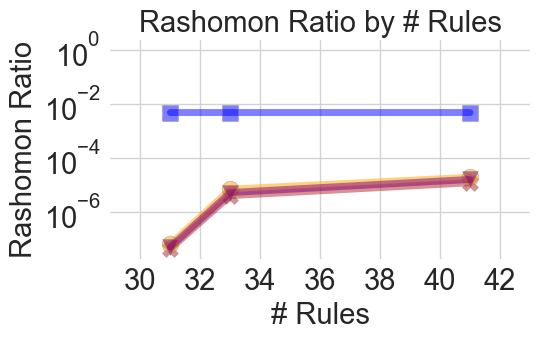

In [30]:
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = 'lightgray'
mpl.rcParams["mathtext.default"] = "regular"

plt.figure(figsize=((5.5, 3.5)))
# Plot the first data on the first subplot
#ax1.plot([61 , 77, 104], y1, color='red')
#ax1.set_title('Plot 1')

x = [31,33,41] 
plt.xlim(x[0]-2, x[-1]+2)

#print(times_MC)

plt.plot(x, counts_by_rules[::-1],  marker='X', color = "firebrick" , linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 
# this is below 

plt.plot(x, all_averages_counts_MC, marker='o', color = "orange" ,   linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

plt.plot(x, all_averages_counts_GT, marker='v', 
        color = "purple",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

plt.plot(x, counts_by_rules_naive , marker='s', 
        color = "blue",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

#ax1.legend(fontsize = 16)

#ax1.set_title('Runtime VS # Rules ( l = ' + str(l) + " k = " + str(k) + " )" , fontsize = 16)
plt.title("Rashomon Ratio by # Rules" , fontsize = 21)

plt.xlabel(" # Rules ", fontsize = 21 )

plt.ylabel(" Rashomon Ratio " , fontsize = 21 ) 

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xticks(fontsize=21)  # Change the fontsize to your desired value
plt.yticks(fontsize=21)

hB, = plot([1,1],'firebrick' , marker='X', linewidth=3 , markersize = 10, markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
hHP, = plot([1,1], "orange", marker='o',  linewidth=3 , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.8)
hS, = plot([1,1],'purple' , marker='v' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#   hD, = plot([1,1],'salmon' , marker='D' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#   hF, = plot([1,1], 'brown' , marker='P' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
#legend(( hB, hHP, hS,), ( "SampleTree-RS" , "ApproxMC-RS",   "FullBB-RS") ,loc='upper center', bbox_to_anchor=(-1, 1.25 ), ncol=3, fancybox=False, shadow=False, borderaxespad=0, fontsize = 14 )
#legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.21 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
hB.set_visible(False)
hS.set_visible(False)
hHP.set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()


plt.savefig("mushroom_1000_runtime_vs_n_rules_with_naive" +  "_log.pdf") 

# Display the plots
plt.show()

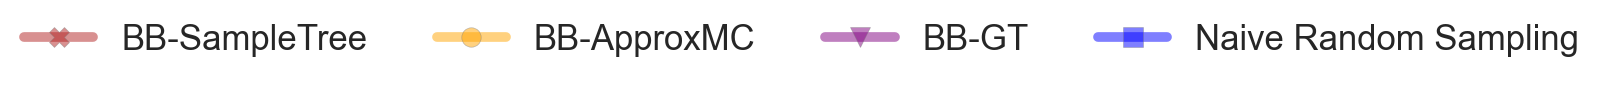

In [41]:
import pylab

figlegend = pylab.figure(figsize=(18,1))
#lines = ax.plot(range(10), pylab.randn(10), range(10), pylab.randn(10))
# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1], marker='X', color = "firebrick" , linewidth=7 , markersize = 14 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 
hHP, = plot([1,1],marker='o', color = "orange" ,   linewidth=7 , markersize = 14 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 
hS, = plot([1,1], marker='v',  color = "purple",   linewidth=7 , markersize = 14 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5)
hD, = plot([1,1],   marker='s', color = "blue",   linewidth=7 , markersize = 14 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5)

#legend(( hB, hHP, hS, hD, hF, hF2), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound", "DijkstraSpaceEfficient" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.12 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
legend(( hB, hHP, hS, hD ), ( "BB-SampleTree" , "BB-ApproxMC",   "BB-GT" , "Naive Random Sampling") ,loc='upper center', bbox_to_anchor=(0.5, 1.12 ), ncol=5, fancybox=False, shadow=False, borderaxespad=0 , fontsize=25)
#legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.12 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
hB.set_visible(False)
hS.set_visible(False)
hHP.set_visible(False)
hD.set_visible(False)

plt.axis('off')

plt.xticks([0], [""]) 
plt.yticks([1], [""]) 

figlegend.savefig('plots/legend_ratio.pdf')

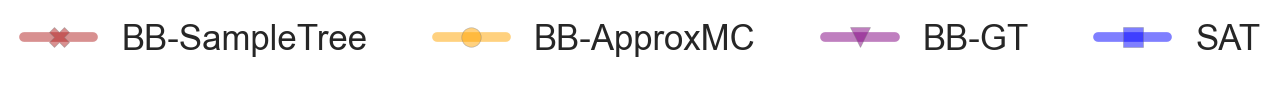

In [44]:
import pylab

figlegend = pylab.figure(figsize=(14,1))
#lines = ax.plot(range(10), pylab.randn(10), range(10), pylab.randn(10))
# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1], marker='X', color = "firebrick" , linewidth=7 , markersize = 14 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 
hHP, = plot([1,1],marker='o', color = "orange" ,   linewidth=7 , markersize = 14 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 
hS, = plot([1,1], marker='v',  color = "purple",   linewidth=7 , markersize = 14 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5)
hD, = plot([1,1],   marker='s', color = "blue",   linewidth=7 , markersize = 14 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5)

#legend(( hB, hHP, hS, hD, hF, hF2), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound", "DijkstraSpaceEfficient" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.12 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
legend(( hB, hHP, hS, hD ), ( "BB-SampleTree" , "BB-ApproxMC",   "BB-GT" , "SAT") ,loc='upper center', bbox_to_anchor=(0.5, 1.12 ), ncol=5, fancybox=False, shadow=False, borderaxespad=0 , fontsize=25)
#legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.12 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
hB.set_visible(False)
hS.set_visible(False)
hHP.set_visible(False)
hD.set_visible(False)

plt.axis('off')

plt.xticks([0], [""]) 
plt.yticks([1], [""]) 

figlegend.savefig('plots/legend_ratio_SAT.pdf')